In [25]:
import warnings

import geoarrow.pyarrow as ga
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pystac_client
import requests
import torch
import yaml
from box import Box

import stacchip.indexer
from stacchip.chipper import Chipper
from stacchip.indexer import Sentinel2Indexer
from torchvision.transforms import v2

import geopandas as gpd
import pandas as pd

from shapely.geometry import Polygon
import matplotlib.pyplot as plt

import math
import os
import random

import timm
import torch
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
from torch import nn
from torchvision.transforms import v2

from src.backbone import Transformer
from src.factory import DynamicEmbedding
from src.utils import posemb_sincos_2d_with_gsd

torch.set_float32_matmul_precision("medium")
os.environ["TORCH_CUDNN_V8_API_DISABLED"] = "1"

#from src.model import ClayMAEModule

import contextily as cx
import rasterio
from rasterio.plot import show

from shapely.geometry import box

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from shapely import wkb

from shapely.ops import unary_union
import stackstac
import pystac_client
import numpy as np
import dask
from rasterio.enums import Resampling
from rasterstats import zonal_stats
import xarray as xr
import rioxarray as rxr

import torch.nn as nn

import shapely
from shapely.geometry import Polygon
from rasterio.features import rasterize
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy

from sklearn.metrics import precision_score, recall_score, f1_score
from rasterio import features
from affine import Affine
from shapely.geometry import shape
import rioxarray
from scipy.spatial import ConvexHull
from rasterio.features import geometry_mask
from scipy.ndimage import label, binary_dilation
from rasterio import features
from affine import Affine
from shapely.geometry import shape
import rioxarray
from rasterio import features
from affine import Affine
from shapely.geometry import shape
import rioxarray
from shapely.geometry import MultiPolygon
from shapely.ops import unary_union
from scipy.spatial import ConvexHull
from rasterio.features import geometry_mask
from scipy.ndimage import label, binary_dilation

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

import seaborn as sns


warnings.filterwarnings("ignore")

### Mine proximity filtering

In [12]:
gdf = gpd.read_parquet('data/north_american_sample_predictions_1k.parquet')
gdf['area'] = gdf.geometry.area
gdf.crs

<Projected CRS: EPSG:8857>
Name: WGS 84 / Equal Earth Greenwich
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Coordinate Operation:
- name: Equal Earth Greenwich
- method: Equal Earth
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
print(len(gdf))
gdf = gdf[gdf['area'] > 212]

print(len(gdf))

16936
12859


In [15]:
gdf.to_crs(epsg=4326)['geometry'].to_file('NA_sample_pit_lakes.geojson',driver='GeoJSON')

In [23]:
NA_sample_pts = gpd.GeoDataFrame(geometry = gdf.geometry.centroid, crs = gdf.crs).to_crs(epsg = 4326)
NA_sample_pts.to_file('NA_sample_pits.geojson',driver = 'GeoJSON')

In [211]:
gdf = gdf[gdf['pit_lake_prob'] >= 0.85]
gdf.to_parquet('streamlit/north_american_sample_predictions_1k_85.parquet')

In [7]:
gdf.drop(columns = ['Area']).to_parquet('data/north_american_sample_predictions_1k.parquet')

In [3]:
testgdf = gpd.read_parquet('data/north_american_sample_predictions_1k.parquet')
testgdf

,pit_lake_prob,ground_truth,geometry,pit_lake_pred,area
0,0.998234,1.0,"POLYGON ((-7387920.016 4084930.104, -7387920.0...",1,1.992043e+04
1,0.998234,1.0,"POLYGON ((-7387140.005 4085000.105, -7387139.9...",1,5.280030e+03
2,0.998234,1.0,"POLYGON ((-7389050 4083520.105, -7389049.995 4...",1,2.369598e+03
3,0.998234,1.0,"POLYGON ((-7388729.995 4082709.895, -7388730 4...",1,1.263759e+03
4,0.998234,1.0,"POLYGON ((-7388480.015 4083220.104, -7388480.0...",1,1.810376e+04
...,...,...,...,...,...
16931,0.500697,0.0,"POLYGON ((-7734789.995 4610470.105, -7734789.9...",1,6.101743e+02
16932,0.500697,0.0,"POLYGON ((-7733509.995 4610010.105, -7733509.9...",1,8.123420e+02
16933,0.500697,0.0,"POLYGON ((-7734430.039 4609960.097, -7734297.6...",1,1.064336e+06
16934,0.500697,0.0,"POLYGON ((-7734930.063 4611580.084, -7734930.0...",1,8.288140e+05


In [ ]:
testgdf = testgdf.to_crs(epsg = 4326)
print(len(testgdf[testgdf.intersects(mn)]))
print(len(testgdf[testgdf.intersects(ont_outline.unary_union)]))
print(len(testgdf[testgdf.intersects(nm)]))


2621


C:\Users\laura\AppData\Local\Temp\ipykernel_21756\641278977.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  print(len(testgdf[testgdf.intersects(ont_outline.unary_union)]))


1163
881


### Load mining data and visualize

In [122]:
# Load mine polygons from Tang dataset and remove Z coordinate
mine_poly = gpd.read_file('data/mine_poly_shp').to_crs(epsg=4326)

def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    From : https://gist.github.com/rmania/8c88377a5c902dfbc134795a7af538d8
    '''
    new_geo = []
    for p in geometry:
        if p.has_z:
            if p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
        else:
            print('no z')
    return new_geo

mine_poly.geometry = convert_3D_2D(mine_poly.geometry) 

print('Number of mine features:')
print(len(mine_poly))


Number of mine features:
74548


In [232]:
mine_distr_polys = gpd.read_file('data/distribution_selected_mines_deposits_districts/PP1802_CritMin_polys.shp')
mine_distr_pts = gpd.read_file('data/distribution_selected_mines_deposits_districts/PP1802_CritMin_pts.shp')

In [233]:
mineral_deposits = gpd.read_file('data/major_mineral_deposits/ofr20051294.shp')
mrds = gpd.read_file('data/MRDS/mrds-trim.shp')


In [234]:
print(mineral_deposits.crs == mrds.crs)
print(mineral_deposits.crs == mine_distr_pts.crs)
print(mineral_deposits.crs == mine_poly.crs)
mine_poly = mine_poly.to_crs(mineral_deposits.crs)

mineral_regions = pd.concat([mine_distr_polys, mine_distr_pts, mineral_deposits, mrds, mine_poly.to_crs(mine_distr_polys.crs)])

print(mineral_deposits.crs)
print(mrds.crs)

print(mine_distr_polys.columns)
print(mine_distr_pts.columns)
print(mineral_deposits.columns)
print(mrds.columns)


True
True
True
EPSG:4326
EPSG:4326
Index(['DEPOSIT_NA', 'CRITICAL_M', 'DEPOSIT_TY', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'LOC_DETAIL', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')
Index(['DEPOSIT_NA', 'CRITICAL_M', 'DEPOSIT_TY', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'LOC_DETAIL', 'geometry'],
      dtype='object')
Index(['REC_ID', 'DEP_NAME', 'COUNTRY', 'STATE', 'COMMODITY', 'DEP_TYPE',
       'DETAIL', 'MODEL', 'DEP_MODEL', 'CITATION', 'CATEGORY', 'URL',
       'geometry'],
      dtype='object')
Index(['DEP_ID', 'SITE_NAME', 'DEV_STAT', 'URL', 'CODE_LIST', 'geometry'], dtype='object')


In [235]:
# Check geometry types
print(list(set(list(map(type,mine_distr_polys.geometry)))))
print(list(set(list(map(type,mine_distr_pts.geometry)))))
print(list(set(list(map(type,mineral_deposits.geometry)))))
print(list(set(list(map(type,mrds.geometry)))))

[<class 'shapely.geometry.multipolygon.MultiPolygon'>, <class 'shapely.geometry.polygon.Polygon'>]
[<class 'shapely.geometry.point.Point'>]
[<class 'shapely.geometry.point.Point'>]
[<class 'shapely.geometry.point.Point'>]


In [236]:
def MineralProximity(predictions, buffer_distance, mineral_regions):
    predictions_polys = predictions
    predictions_polys['polygon'] = predictions_polys['geometry']
    predictions_polys.geometry = predictions_polys.geometry.buffer(buffer_distance)

    mineral_regions = mineral_regions.to_crs(predictions_polys.crs)
    print(mineral_regions.crs == predictions_polys.crs)
    predictions_polys = gpd.sjoin(predictions_polys, mineral_regions, how = 'left', rsuffix = '1').drop_duplicates(subset = 'geometry')
    print('spatial join complete')
    predictions_polys['within_buffer'] = 1 
    predictions_polys.loc[predictions_polys['index_1'].isna(), 'within_buffer'] = 0 # Mark negative if no intersection with mineral regions

    return predictions_polys

In [237]:
def BufferMetrics(predictions):
    tp = (predictions['ground_truth'] == 1).sum()
    tp_post = ((predictions['ground_truth'] == 1) & ((predictions['within_buffer'] == 1))).sum()
    fp = (predictions['ground_truth'] == 0).sum()
    fp_post = ((predictions['ground_truth'] == 0) & ((predictions['within_buffer'] == 1))).sum()

    pre_filter_precision = tp / (tp + fp)
    post_filter_precision = tp_post / (tp_post + fp_post)
    #fn_post = ((predictions['ground_truth'] == 1) & ((predictions['within_buffer'] == 0))).sum()
    recall_reduction = 1 - (tp_post / tp)
    print(tp_post)
    print(tp)

    return pre_filter_precision, post_filter_precision, recall_reduction 

In [108]:
predictions_500 = MineralProximity(mn_predictions, 500, mineral_regions)
metrics_500 = BufferMetrics(predictions_500)
print(metrics_500)

predictions_1k = MineralProximity(mn_predictions, 1000, mineral_regions)
metrics_1k = BufferMetrics(predictions_1k)
print(metrics_1k)

predictions_2k = MineralProximity(mn_predictions, 2000, mineral_regions)
metrics_2k = BufferMetrics(predictions_2k)
print(metrics_2k)

predictions_3k = MineralProximity(mn_predictions, 3000, mineral_regions)
metrics_3k = BufferMetrics(predictions_3k)
print(metrics_3k)

predictions_4k = MineralProximity(mn_predictions, 4000, mineral_regions)
metrics_4k = BufferMetrics(predictions_4k)
print(metrics_4k)

predictions_5k = MineralProximity(mn_predictions, 5000, mineral_regions)
metrics_5k = BufferMetrics(predictions_5k)
print(metrics_5k)


True
spatial join complete
1050
1264
(0.083125082204393, 0.4872389791183295, 0.16930379746835444)
True
spatial join complete
1202
1264
(0.083125082204393, 0.39025974025974025, 0.049050632911392444)
True
spatial join complete
1248
1264
(0.083125082204393, 0.26672365890147465, 0.012658227848101222)
True
spatial join complete
1255
1264
(0.083125082204393, 0.18220092915214867, 0.007120253164557)
True
spatial join complete
1259
1264
(0.083125082204393, 0.12753241491085898, 0.003955696202531667)


KeyboardInterrupt: 

In [435]:
# 500
mineral_regions = pd.concat([mine_distr_polys, mine_distr_pts, mineral_deposits, mrds, mine_poly])
mn_predictions = gpd.read_parquet('data/aws_results/MinnesotaFull_predictions_polys.parquet')

predictions_500 = MineralProximity(mn_predictions, 500, mineral_regions)
metrics_500 = BufferMetrics(predictions_500)
print(metrics_500)

mn_predictions = gpd.read_parquet('data/aws_results/MinnesotaFull_predictions_polys.parquet')
mn_predictions_chips = gpd.read_parquet('data/MNFull_predictions.parquet')

mn_original = gpd.sjoin(mn_predictions_chips, mn_predictions, rsuffix = '_3', how = 'left').drop_duplicates('geometry')
mn_original.loc[~mn_original['index__3'].isna(), 'mine_prob'] = 1

predictions_500_renamed = gpd.GeoDataFrame(predictions_500, geometry = predictions_500['polygon'])
predictions_500_renamed = predictions_500_renamed.drop(columns = ['geometry']).rename(columns = {'polygon':'geometry', 'mine_prob': 'pit_lake_prob', 'within_buffer': 'pit_lake_pred'})
mn_joined_500 = gpd.sjoin(mn_predictions_chips, predictions_500_renamed, how = 'left', predicate = 'intersects', rsuffix = '_2')

mn_joined_500 = mn_joined_500.reset_index(drop = True)
mn_joined_500.loc[mn_joined_500['pit_lake_pred'].isna(), 'pit_lake_pred'] = 0
mn_joined_500 = mn_joined_500.loc[mn_joined_500.groupby('geometry')['pit_lake_pred'].idxmax()]

mn_joined_500 = mn_joined_500[['geometry', 'ground_truth_left', 'mine_prob_left','pit_lake_pred']]
mn_joined_500 = mn_joined_500.rename(columns = {'ground_truth_left': 'ground_truth', 'mine_prob_left':'mine_prob'})
BufferChipMetrics(mn_joined_500, mn_original)

True
spatial join complete
1050
1264
(0.083125082204393, 0.4872389791183295, 0.16930379746835444)
92
103


(0.03384817614196516, 0.3006535947712418, 0.10679611650485432)

In [436]:
# 2250
mineral_regions = pd.concat([mine_distr_polys, mine_distr_pts, mineral_deposits, mrds, mine_poly])
mn_predictions = gpd.read_parquet('data/aws_results/MinnesotaFull_predictions_polys.parquet')

predictions_1k = MineralProximity(mn_predictions, 1000, mineral_regions)
metrics_1k = BufferMetrics(predictions_1k)
print(metrics_1k)

mn_predictions = gpd.read_parquet('data/aws_results/MinnesotaFull_predictions_polys.parquet')
mn_predictions_chips = gpd.read_parquet('data/MNFull_predictions.parquet')

mn_original = gpd.sjoin(mn_predictions_chips, mn_predictions, rsuffix = '_3', how = 'left').drop_duplicates('geometry')
mn_original.loc[~mn_original['index__3'].isna(), 'mine_prob'] = 1

predictions_1k_renamed = gpd.GeoDataFrame(predictions_1k, geometry = predictions_1k['polygon'])
predictions_1k_renamed = predictions_1k_renamed.drop(columns = ['geometry']).rename(columns = {'polygon':'geometry', 'mine_prob': 'pit_lake_prob', 'within_buffer': 'pit_lake_pred'})
mn_joined = gpd.sjoin(mn_predictions_chips, predictions_1k_renamed, how = 'left', predicate = 'intersects', rsuffix = '_2')

mn_joined = mn_joined.reset_index(drop = True)
mn_joined.loc[mn_joined['pit_lake_pred'].isna(), 'pit_lake_pred'] = 0
mn_joined = mn_joined.loc[mn_joined.groupby('geometry')['pit_lake_pred'].idxmax()]

mn_joined = mn_joined[['geometry', 'ground_truth_left', 'mine_prob_left','pit_lake_pred']]
mn_joined = mn_joined.rename(columns = {'ground_truth_left': 'ground_truth', 'mine_prob_left':'mine_prob'})
BufferChipMetrics(mn_joined, mn_original)

True
spatial join complete
1163
1264
(0.083125082204393, 0.4437237695536055, 0.07990506329113922)
96
103


(0.03384817614196516, 0.25, 0.06796116504854366)

In [432]:
# 
mineral_regions = pd.concat([mine_distr_polys, mine_distr_pts, mineral_deposits, mrds, mine_poly])
mn_predictions = gpd.read_parquet('data/aws_results/MinnesotaFull_predictions_polys.parquet')

predictions_2k = MineralProximity(mn_predictions, 2000, mineral_regions)
metrics_2k = BufferMetrics(predictions_2k)
print(metrics_2k)

mn_predictions = gpd.read_parquet('data/aws_results/MinnesotaFull_predictions_polys.parquet')
mn_predictions_chips = gpd.read_parquet('data/MNFull_predictions.parquet')

mn_original = gpd.sjoin(mn_predictions_chips, mn_predictions, rsuffix = '_3', how = 'left').drop_duplicates('geometry')
mn_original.loc[~mn_original['index__3'].isna(), 'mine_prob'] = 1

predictions_2k_renamed = gpd.GeoDataFrame(predictions_2k, geometry = predictions_2k['polygon'])
predictions_2k_renamed = predictions_2k_renamed.drop(columns = ['geometry']).rename(columns = {'polygon':'geometry', 'mine_prob': 'pit_lake_prob', 'within_buffer': 'pit_lake_pred'})
mn_joined = gpd.sjoin(mn_predictions_chips, predictions_2k_renamed, how = 'left', predicate = 'intersects', rsuffix = '_2')

mn_joined = mn_joined.reset_index(drop = True)
mn_joined.loc[mn_joined['pit_lake_pred'].isna(), 'pit_lake_pred'] = 0
mn_joined = mn_joined.loc[mn_joined.groupby('geometry')['pit_lake_pred'].idxmax()]

mn_joined = mn_joined[['geometry', 'ground_truth_left', 'mine_prob_left','pit_lake_pred']]
mn_joined = mn_joined.rename(columns = {'ground_truth_left': 'ground_truth', 'mine_prob_left': 'mine_prob'})
BufferChipMetrics(mn_joined, mn_original)

True
spatial join complete
1230
1264
(0.083125082204393, 0.3464788732394366, 0.026898734177215222)
96
103


(0.03384817614196516, 0.17712177121771217, 0.06796116504854366)

In [433]:
# 2750
mineral_regions = pd.concat([mine_distr_polys, mine_distr_pts, mineral_deposits, mrds, mine_poly])
mn_predictions = gpd.read_parquet('data/aws_results/MinnesotaFull_predictions_polys.parquet')

predictions_3k = MineralProximity(mn_predictions, 3000, mineral_regions)
metrics_3k = BufferMetrics(predictions_3k)
print(metrics_3k)

mn_predictions = gpd.read_parquet('data/aws_results/MinnesotaFull_predictions_polys.parquet')
mn_predictions_chips = gpd.read_parquet('data/MNFull_predictions.parquet')

mn_original = gpd.sjoin(mn_predictions_chips, mn_predictions, rsuffix = '_3', how = 'left').drop_duplicates('geometry')
mn_original.loc[~mn_original['index__3'].isna(), 'mine_prob'] = 1

predictions_3k_renamed = gpd.GeoDataFrame(predictions_3k, geometry = predictions_3k['polygon'])
predictions_3k_renamed = predictions_3k_renamed.drop(columns = ['geometry']).rename(columns = {'polygon':'geometry', 'mine_prob': 'pit_lake_prob', 'within_buffer': 'pit_lake_pred'})
mn_joined = gpd.sjoin(mn_predictions_chips, predictions_3k_renamed, how = 'left', predicate = 'intersects', rsuffix = '_2')

mn_joined = mn_joined.reset_index(drop = True)
mn_joined.loc[mn_joined['pit_lake_pred'].isna(), 'pit_lake_pred'] = 0
mn_joined = mn_joined.loc[mn_joined.groupby('geometry')['pit_lake_pred'].idxmax()]

mn_joined = mn_joined[['geometry', 'ground_truth_left', 'mine_prob_left','pit_lake_pred']]
mn_joined = mn_joined.rename(columns = {'ground_truth_left': 'ground_truth', 'mine_prob_left': 'mine_prob'})
BufferChipMetrics(mn_joined, mn_original)

True
spatial join complete
1244
1264
(0.083125082204393, 0.28836346777932315, 0.015822784810126556)
98
103


(0.03384817614196516, 0.14306569343065692, 0.04854368932038833)

In [ ]:
print(f'3k: precision change {0.14306569343065692/0.03384817614196516:.4f}')
print(f'recall change {0.04854368932038833:.4f}')

print(f'2k: precision change {0.17712177121771217/0.03384817614196516:.4f}')
print(f' recall change {0.06796116504854366:.4f}')

print(f'1k: precision change {0.25/0.03384817614196516:.4f}')
print(f' recall change {0.06796116504854366:.4f}')

print(f'500: precision change {0.3006535947712418/0.03384817614196516:.4f}')
print(f' recall change {0.10679611650485432:.4f}')


3k: precision change 4.2267
recall change 0.0485
2k: precision change 5.2328
 recall change 0.0680
1k: precision change 7.3859
 recall change 0.0680
500: precision change 8.8824
 recall change 0.1068


In [ ]:
print(f'2.25k: precision change {.03384817614196516/0.007862186388902799:.4f}')
print(f'recall change {:.3439490445859873.4f}')

print(f'2.5k: precision change {.015924638331277337/0.007862186388902799:.4f}')
print(f'recall change {:.09554140127388533:.4f}')

print(f'2.75k: precision change {.010235001010032994/0.007862186388902799:.4f}')
print(f'recall change {:.031847133757961776.4f}')


In [469]:
# All, 1000
import pathlib

# Path to the folder containing Parquet files
folder_path = pathlib.Path("C:/Users/laura/Projects/minemap/aquarry/model/data/aws_results")

# Get all Parquet files in the folder
parquet_files = list(folder_path.glob("*.parquet"))
print(len(parquet_files))

# Read and concatenate all Parquet files into a single GeoDataFrame
gdfs = [gpd.read_parquet(f) for f in parquet_files]
all_predictions_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
print(all_predictions_gdf.columns)

all_predictions = all_predictions_gdf
all_predictions = all_predictions.rename(columns = {'previous_pred': 'ground_truth'})

mineral_regions = pd.concat([mine_distr_polys, mine_distr_pts, mineral_deposits, mrds, mine_poly])

predictions_1k = MineralProximity(all_predictions, 1000, mineral_regions)
metrics_1k = BufferMetrics(predictions_1k)
print(metrics_1k)

23
Index(['geometry', 'mine_prob', 'ground_truth', 'updated_preds'], dtype='object')
True
spatial join complete
7204
8274
(0.11956992976675626, 0.42536608408124704, 0.1293207638385303)


In [ ]:
predictions_1k = predictions_1k[['geometry', 'mine_prob', 'ground_truth', 'polygon', 'within_buffer']]

In [498]:
predictions_1k_renamed = gpd.GeoDataFrame(predictions_1k, geometry = predictions_1k['polygon']).drop(columns = ['geometry'])
print(predictions_1k_renamed.columns)
predictions_1k_renamed = predictions_1k_renamed.rename(columns = {'polygon':'geometry', 'mine_prob': 'pit_lake_prob', 'within_buffer': 'pit_lake_pred'})
predictions_1k_renamed = predictions_1k_renamed[predictions_1k_renamed['pit_lake_pred'] == 1].reset_index(drop=True)
predictions_1k_renamed.shape

Index(['mine_prob', 'ground_truth', 'polygon', 'within_buffer'], dtype='object')


(16936, 4)

In [505]:
predictions_1k_renamed = predictions_1k_renamed.sort_values(by = 'pit_lake_prob', ascending = False).reset_index(drop = True)
print(predictions_1k_renamed)
predictions_1k_renamed.to_parquet('data/north_american_sample_predictions_1k.parquet')

       pit_lake_prob  ground_truth  \
0           0.998234           1.0   
1           0.998234           1.0   
2           0.998234           1.0   
3           0.998234           1.0   
4           0.998234           1.0   
...              ...           ...   
16931       0.500697           0.0   
16932       0.500697           0.0   
16933       0.500697           0.0   
16934       0.500697           0.0   
16935       0.500697           0.0   

                                                geometry  pit_lake_pred  
0      POLYGON ((-7387920.016 4084930.104, -7387920.0...              1  
1      POLYGON ((-7387140.005 4085000.105, -7387139.9...              1  
2      POLYGON ((-7389050 4083520.105, -7389049.995 4...              1  
3      POLYGON ((-7388729.995 4082709.895, -7388730 4...              1  
4      POLYGON ((-7388480.015 4083220.104, -7388480.0...              1  
...                                                  ...            ...  
16931  POLYGON ((-7734789

In [16]:
def BufferChipMetrics(predictions, chip_predictions):
    tp = ((chip_predictions['ground_truth_left'] == 1) & (chip_predictions['mine_prob'] >= 0.5)).sum()
    tp_post = ((predictions['ground_truth'] == 1) & (predictions['pit_lake_pred'] == 1)).sum()
    fp = ((chip_predictions['ground_truth_left'] == 0) & (chip_predictions['mine_prob'] >= 0.5)).sum()
    fp_post = ((predictions['ground_truth'] == 0) & (predictions['pit_lake_pred'] == 1)).sum()

    pre_filter_precision = tp / (tp + fp)
    post_filter_precision = tp_post / (tp_post + fp_post)
    recall_reduction = 1 - (tp_post / tp)
    print(tp_post)
    print(tp)

    return pre_filter_precision, post_filter_precision, recall_reduction 

In [ ]:
# Get MN predictions and join to chips, calculate metrics
mn_predictions = gpd.read_parquet('data/aws_results/MinnesotaFull_predictions_polys.parquet')
mn_predictions_chips = gpd.read_parquet('data/MNFull_predictions.parquet')
print(mn_predictions_chips.shape)

mine_poly = mine_poly.to_crs(mn_predictions.crs)
mn_predictions_chips = mn_predictions_chips.to_crs(mn_predictions.crs)

# Get just Tang
mn_predictions = gpd.sjoin(mn_predictions, mine_poly, how = 'inner', rsuffix = '2').drop_duplicates('geometry')[['geometry','mine_prob', 'ground_truth','updated_preds']]
mn_predictions_chips =  gpd.sjoin(mn_predictions_chips, mine_poly, how = 'inner', rsuffix = '2').drop_duplicates('geometry')[['minx', 'miny', 'maxx', 'maxy', 'embedding', 'geometry', 'centroid_x',
       'centroid_y', 'geometry_wkt', 'index__1', 'cc', 'objectid', 'score',
       'label', 'dataset', 'area', 'volume', 'wkb_geometry', 'field_9',
       'category', 'field_11', 'wb_class', 'shape_Area', 'mine', 'emb_idx',
       'overlapping_area', 'pct_pitlake', 'mine_prob_left',
       'ground_truth_left', 'index_right', 'mine_prob_right',
       'ground_truth_right', 'updated_preds']]
                                  
print(mn_predictions_chips.shape)

predictions_1k = MineralProximity(mn_predictions, 1000, mineral_regions)
metrics_1k = BufferMetrics(predictions_1k)
print(metrics_1k)

mn_original = gpd.sjoin(mn_predictions_chips, mn_predictions, rsuffix = '_3', how = 'left').drop_duplicates('geometry')
mn_original.loc[~mn_original['index__3'].isna(), 'mine_prob'] = 1

predictions_1k_renamed = gpd.GeoDataFrame(predictions_1k, geometry = predictions_1k['polygon'])
predictions_1k_renamed = predictions_1k_renamed.drop(columns = ['geometry']).rename(columns = {'polygon':'geometry', 'mine_prob': 'pit_lake_prob', 'within_buffer': 'pit_lake_pred'})
mn_joined = gpd.sjoin(mn_predictions_chips, predictions_1k_renamed, how = 'left', predicate = 'intersects', rsuffix = '_2')
print('joined to chips')

mn_joined = mn_joined.reset_index(drop = True)
mn_joined.loc[mn_joined['pit_lake_pred'].isna(), 'pit_lake_pred'] = 0
mn_joined = mn_joined.loc[mn_joined.groupby('geometry')['pit_lake_pred'].idxmax()]

mn_joined = mn_joined[['geometry', 'ground_truth_left', 'mine_prob_left','pit_lake_pred']]
mn_joined = mn_joined.rename(columns = {'ground_truth_left': 'ground_truth', 'mine_prob_left': 'mine_prob'})
BufferChipMetrics(mn_joined, mn_original)

(34351, 33)
(211, 33)
True
spatial join complete
634
634
(0.5121163166397416, 0.5121163166397416, 0.0)
joined to chips
71
92


(0.467005076142132, 0.5035460992907801, 0.2282608695652174)

In [173]:
mn_qa_nondrypits_updated = mn_qa_nondrypits.to_crs(mn_predictions_chips.crs)
mn_original_plinio = gpd.sjoin(mn_predictions_chips, mn_qa_nondrypits_updated, rsuffix = '_3', how = 'left').drop_duplicates('geometry')
print(f"Plinio's true positives: {(~mn_original_plinio['index__3'].isna()).sum()}")

Plinio's true positives: 94


In [174]:
mn_qa_pos = mn_qa[mn_qa['score'] >= 0.5]
mn_qa_pos = mn_qa_pos.to_crs(mn_predictions_chips.crs)

In [175]:
mn_original_plinio_pos = gpd.sjoin(mn_predictions_chips, mn_qa_pos, rsuffix = '_3', how = 'left').drop_duplicates('geometry')
# Plinio's predicted positives

print(f"Plinio's predicted positives: {(~mn_original_plinio_pos['index__3'].isna()).sum()}")
(mn_original_plinio_pos['score__3'] >= 0.5).sum()

Plinio's predicted positives: 123


123

In [ ]:
#Plinio
print(94/105) # recall
print(94/123) # precision

0.8952380952380953
0.7642276422764228


In [176]:
mine_poly = mine_poly.to_crs(mn_aggregated_nondry_pits.crs)
tang_mn_aggregated_nondry_pits = gpd.sjoin(mn_aggregated_nondry_pits, mine_poly, how = 'inner', rsuffix = '2').drop_duplicates('geometry')
tang_mn_aggregated_nondry_pits = tang_mn_aggregated_nondry_pits.to_crs(mn_joined.crs)
tang_mn_filtered = gpd.sjoin(mn_joined, tang_mn_aggregated_nondry_pits, how = 'left').drop_duplicates('geometry')

print(f"Number of chips with pit lakes: {(~tang_mn_filtered['index_2'].isna()).sum()}")
print(f"Number of true pit lake chips found: {((~tang_mn_filtered['index_2'].isna()) & (tang_mn_filtered['pit_lake_pred'] == 1)).sum()}")
print(tang_mn_filtered['ground_truth'].sum())
tang_mn_filtered['pit_lake_pred'].sum()

Number of chips with pit lakes: 105
Number of true pit lake chips found: 80
98.0


141.0

In [178]:
print(80/105) # Recall 
print(80/141) # Precision

0.7619047619047619
0.5673758865248227


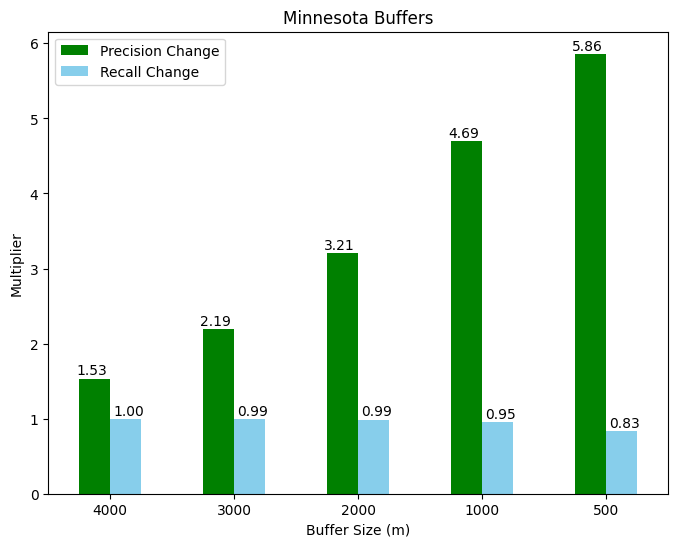

In [148]:
precision_change = [metrics_500[1] / metrics_500[0], metrics_1k[1] / metrics_1k[0],
                    metrics_2k[1] / metrics_2k[0], metrics_3k[1] / metrics_3k[0], metrics_4k[1] / metrics_4k[0]]

recall_change = [1 - metrics_500[2],1 - metrics_1k[2],
                    1- metrics_2k[2], 1- metrics_3k[2], 1 - metrics_4k[2]]
                    #1- metrics_5k[2]]

buffers = [500, 1000, 2000, 3000, 4000 ] # , 5000]

buffer_df = pd.DataFrame({'buffer': buffers, 'precision_change': precision_change, 'recall_change': recall_change})
buffer_df.index = buffer_df['buffer']
buffer_df = buffer_df.drop(columns = 'buffer')
buffer_df = buffer_df.sort_values(by = 'precision_change')
#buffer_df = buffer_df[buffer_df.index.isin([500, 1000, 2000, 3000])]


ax = buffer_df.plot(kind='bar', figsize=(8, 6), color=['green', 'skyblue'])
plt.title('Minnesota Buffers')

# Add value labels
for i in range(len(buffer_df)):
    plt.text(i - 0.15, buffer_df.iloc[i]['precision_change'] + 0.01, f'{buffer_df.iloc[i]["precision_change"]:.2f}', 
             ha='center', va='bottom', fontsize=10)
    plt.text(i + 0.15, buffer_df.iloc[i]['recall_change'] + 0.01, f'{buffer_df.iloc[i]["recall_change"]:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.ylabel('Multiplier')
plt.xlabel('Buffer Size (m)')
plt.xticks(rotation=0)  # Keep labels horizontal for readability
plt.legend(['Precision Change', 'Recall Change'])
plt.show()



#### For each state, get updated metrics
First load in the NDWI filtered dataset. Get the Tang and regional intersection.

Get the labeled Tang chips. Intersect with labeled chips.

Then re-calculate metrics at the chip level for distance filtered pit lakes

In [165]:
def GetTangPolys(state_polys, state_chips, state, Tang):
    # Make same CRS
    state = gpd.GeoDataFrame(geometry = [state], crs = 4326).to_crs(state_polys.crs)
    Tang = Tang.to_crs(state_polys.crs)

    # Get polygons in that state's Tang regions
    tang_pits = gpd.sjoin(state_polys, state, how = 'inner', rsuffix = '_2').drop_duplicates('geometry')
    print(len(tang_pits))
    tang_pits = gpd.sjoin(tang_pits, Tang, how = 'inner', rsuffix = '_3').drop_duplicates('geometry')
    print(len(tang_pits))

    # Join to chips
    state_chips = state_chips.to_crs(tang_pits.crs)
    state_chips = gpd.sjoin(state_chips, Tang, how = 'inner', rsuffix = '_3').drop_duplicates('geometry')
    joined_polys = gpd.sjoin(state_chips, tang_pits, how = 'left').drop_duplicates('geometry')
    joined_polys['updated_pred'] = 1
    print(joined_polys.columns)
    joined_polys.loc[joined_polys['index__3_right'].isna(), 'updated_pred'] = 0

    return joined_polys

In [94]:
def CalculateMetrics(chip_data):
    all_ground_truths = np.array(chip_data['mine'])
    all_predictions = np.array(chip_data['updated_pred'])
    precision = precision_score(all_ground_truths, all_predictions, average='binary')
    recall = recall_score(all_ground_truths, all_predictions, average='binary')
    f1 = f1_score(all_ground_truths, all_predictions, average='binary')
    accuracy = accuracy_score(all_ground_truths, all_predictions)

    return precision, recall, f1, accuracy

In [260]:
# Get state chips

# Load in the filtered dataset
az_polys = gpd.read_parquet('data/us_results/AZ_predictions_polys.parquet')

# Filter by distance to mine
predictions_az_1k = MineralProximity(az_polys, 1000, mineral_regions)
predictions_az_1k['geometry'] = predictions_az_1k['polygon']
metrics_az_1k = BufferMetrics(predictions_az_1k)
print(metrics_az_1k)

# Filter and join to chips
az_joined = GetTangPolys(predictions_az_1k, dataAZmarked, az, mine_poly)
print(az_joined['mine'].sum())
print(az_joined['updated_pred'].sum())

print(CalculateMetrics(az_joined))

all_ground_truths = np.array(az_joined['mine'])
all_predictions = np.array(az_joined['updated_pred'])
sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

True
spatial join complete
1043
1050
(0.29914529914529914, 0.29817038307604343, 0.00666666666666671)
3510
3253
Index(['geometry', 'mine', 'score', 'mine_feature', 'category', 'embedding',
       'emb_idx', 'overlapping_area', 'pct_pitlake', 'index__3_left',
       'OBJECTID', 'Name', 'Shape_Le_1', 'Shape_Area', 'index_right',
       'mine_prob', 'ground_truth', 'updated_preds', 'polygon', 'index_1',
       'DEPOSIT_NA', 'CRITICAL_M', 'DEPOSIT_TY', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'LOC_DETAIL', 'SHAPE_Leng', 'SHAPE_Area', 'REC_ID',
       'DEP_NAME', 'COUNTRY', 'STATE', 'COMMODITY', 'DEP_TYPE', 'DETAIL',
       'MODEL', 'DEP_MODEL', 'CITATION', 'CATEGORY', 'URL', 'DEP_ID',
       'SITE_NAME', 'DEV_STAT', 'CODE_LIST', 'OBJECTID_left', 'Name_left',
       'Shape_Le_1_left', 'Shape_Area_left', 'within_buffer', 'index__2',
       'index__3_right', 'OBJECTID__3', 'Name__3', 'Shape_Le_1__3',
       'Shape_Area__3', 'updated_pred'],
      dtype='object')
38
96
(0.3541666666666667, 0

array([[102,  62],
       [  4,  34]], dtype=int64)

In [261]:
# Get state chips

# Load in the filtered dataset
nv_polys = dataNVpositives_polys

# Filter by distance to mine
predictions_nv_1k = MineralProximity(nv_polys, 1000, mineral_regions)
predictions_nv_1k['geometry'] = predictions_nv_1k['polygon']
metrics_nv_1k = BufferMetrics(predictions_nv_1k)
print(metrics_nv_1k)

# Filter and join to chips
nv_joined = GetTangPolys(predictions_nv_1k, dataNVmarked, nv, mine_poly)
print(nv_joined['mine'].sum())
print(nv_joined['updated_pred'].sum())

print(CalculateMetrics(nv_joined))

all_ground_truths = np.array(nv_joined['mine'])
all_predictions = np.array(nv_joined['updated_pred'])
sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)


True
spatial join complete
50
50
(0.07739938080495357, 0.07739938080495357, 0.0)
646
642
Index(['geometry', 'mine', 'score', 'mine_feature', 'category', 'embedding',
       'emb_idx', 'overlapping_area', 'pct_pitlake', 'index__3_left',
       'OBJECTID', 'Name', 'Shape_Le_1', 'Shape_Area', 'index_right',
       'mine_prob', 'ground_truth', 'updated_preds', 'polygon', 'index_1',
       'DEPOSIT_NA', 'CRITICAL_M', 'DEPOSIT_TY', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'LOC_DETAIL', 'SHAPE_Leng', 'SHAPE_Area', 'REC_ID',
       'DEP_NAME', 'COUNTRY', 'STATE', 'COMMODITY', 'DEP_TYPE', 'DETAIL',
       'MODEL', 'DEP_MODEL', 'CITATION', 'CATEGORY', 'URL', 'DEP_ID',
       'SITE_NAME', 'DEV_STAT', 'CODE_LIST', 'OBJECTID_left', 'Name_left',
       'Shape_Le_1_left', 'Shape_Area_left', 'within_buffer', 'index__2',
       'index__3_right', 'OBJECTID__3', 'Name__3', 'Shape_Le_1__3',
       'Shape_Area__3', 'updated_pred'],
      dtype='object')
20
169
(0.11242603550295859, 0.95, 0.2010582010582

array([[ 57, 150],
       [  1,  19]], dtype=int64)

In [262]:
# Get state chips

# Load in the filtered dataset
ga_polys = gpd.read_parquet('data/us_results/GA_predictions_polys.parquet')

# Filter by distance to mine
predictions_ga_1k = MineralProximity(ga_polys, 1000, mineral_regions)
predictions_ga_1k['geometry'] = predictions_ga_1k['polygon']
metrics_ga_1k = BufferMetrics(predictions_ga_1k)
print(metrics_ga_1k)

# Filter and join to chips
ga_joined = GetTangPolys(predictions_ga_1k, dataGAmarked, ga, mine_poly)
print(ga_joined['mine'].sum())
print(ga_joined['updated_pred'].sum())

print(CalculateMetrics(ga_joined))

all_ground_truths = np.array(ga_joined['mine'])
all_predictions = np.array(ga_joined['updated_pred'])
sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)


True
spatial join complete
1750
1868
(0.8684332868433287, 0.8680555555555556, 0.06316916488222701)
2151
934
Index(['geometry', 'mine', 'score', 'mine_feature', 'category', 'embedding',
       'emb_idx', 'overlapping_area', 'pct_pitlake', 'index__3_left',
       'OBJECTID', 'Name', 'Shape_Le_1', 'Shape_Area', 'index_right',
       'mine_prob', 'ground_truth', 'updated_preds', 'polygon', 'index_1',
       'DEPOSIT_NA', 'CRITICAL_M', 'DEPOSIT_TY', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'LOC_DETAIL', 'SHAPE_Leng', 'SHAPE_Area', 'REC_ID',
       'DEP_NAME', 'COUNTRY', 'STATE', 'COMMODITY', 'DEP_TYPE', 'DETAIL',
       'MODEL', 'DEP_MODEL', 'CITATION', 'CATEGORY', 'URL', 'DEP_ID',
       'SITE_NAME', 'DEV_STAT', 'CODE_LIST', 'OBJECTID_left', 'Name_left',
       'Shape_Le_1_left', 'Shape_Area_left', 'within_buffer', 'index__2',
       'index__3_right', 'OBJECTID__3', 'Name__3', 'Shape_Le_1__3',
       'Shape_Area__3', 'updated_pred'],
      dtype='object')
145
152
(0.8157894736842105, 0.

array([[ 39,  28],
       [ 21, 124]], dtype=int64)

In [277]:
# Get state chips

# Load in the filtered dataset
#in_polys = gpd.read_parquet('data/north_american_sample_predictions_1k.parquet')
in_polys = gpd.read_parquet('data/us_results/IN_predictions_polys.parquet')

# Filter by distance to mine
predictions_in_1k = MineralProximity(in_polys, 1000, mineral_regions)
predictions_in_1k['geometry'] = predictions_in_1k['polygon']
metrics_in_1k = BufferMetrics(predictions_in_1k)
print(metrics_in_1k)

# Filter and join to chips
in_joined = GetTangPolys(predictions_in_1k, dataINmarked, indiana, mine_poly)
print(in_joined['mine'].sum())
print(in_joined['updated_pred'].sum())

print(CalculateMetrics(in_joined))

all_ground_truths = np.array(in_joined['mine'])
all_predictions = np.array(in_joined['updated_pred'])
sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

True
spatial join complete
750
869
(0.4915158371040724, 0.5345687811831789, 0.13693901035673184)
1766
764
Index(['geometry', 'mine', 'score', 'mine_feature', 'category', 'embedding',
       'emb_idx', 'overlapping_area', 'pct_pitlake', 'index__3_left',
       'OBJECTID', 'Name', 'Shape_Le_1', 'Shape_Area', 'index_right',
       'mine_prob', 'ground_truth', 'updated_preds', 'polygon', 'index_1',
       'DEPOSIT_NA', 'CRITICAL_M', 'DEPOSIT_TY', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'LOC_DETAIL', 'SHAPE_Leng', 'SHAPE_Area', 'REC_ID',
       'DEP_NAME', 'COUNTRY', 'STATE', 'COMMODITY', 'DEP_TYPE', 'DETAIL',
       'MODEL', 'DEP_MODEL', 'CITATION', 'CATEGORY', 'URL', 'DEP_ID',
       'SITE_NAME', 'DEV_STAT', 'CODE_LIST', 'OBJECTID_left', 'Name_left',
       'Shape_Le_1_left', 'Shape_Area_left', 'within_buffer', 'index__2',
       'index__3_right', 'OBJECTID__3', 'Name__3', 'Shape_Le_1__3',
       'Shape_Area__3', 'updated_pred'],
      dtype='object')
80
116
(0.5172413793103449, 0.75,

array([[62, 56],
       [20, 60]], dtype=int64)

In [264]:
# Get state chips

# Load in the filtered dataset
ilkymo_polys = gpd.read_parquet('data/us_results/ILKYMO_predictions_polys.parquet')

# Filter by distance to mine
predictions_ilkymo_1k = MineralProximity(ilkymo_polys, 1000, mineral_regions)
predictions_ilkymo_1k['geometry'] = predictions_ilkymo_1k['polygon']
metrics_ilkymo_1k = BufferMetrics(predictions_ilkymo_1k)
print(metrics_ilkymo_1k)

# Filter and join to chips
ilkymo_joined = GetTangPolys(predictions_ilkymo_1k, dataILKYMOmarked, ilkymo, mine_poly)
print(ilkymo_joined['mine'].sum())
print(ilkymo_joined['updated_pred'].sum())

print(CalculateMetrics(ilkymo_joined))

all_ground_truths = np.array(ilkymo_joined['mine'])
all_predictions = np.array(ilkymo_joined['updated_pred'])
sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

True
spatial join complete
595
710
(0.45050761421319796, 0.48770491803278687, 0.1619718309859155)
1566
546
Index(['geometry', 'mine', 'score', 'mine_feature', 'category', 'embedding',
       'emb_idx', 'overlapping_area', 'pct_pitlake', 'index__3_left',
       'OBJECTID', 'Name', 'Shape_Le_1', 'Shape_Area', 'index_right',
       'mine_prob', 'ground_truth', 'updated_preds', 'polygon', 'index_1',
       'DEPOSIT_NA', 'CRITICAL_M', 'DEPOSIT_TY', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'LOC_DETAIL', 'SHAPE_Leng', 'SHAPE_Area', 'REC_ID',
       'DEP_NAME', 'COUNTRY', 'STATE', 'COMMODITY', 'DEP_TYPE', 'DETAIL',
       'MODEL', 'DEP_MODEL', 'CITATION', 'CATEGORY', 'URL', 'DEP_ID',
       'SITE_NAME', 'DEV_STAT', 'CODE_LIST', 'OBJECTID_left', 'Name_left',
       'Shape_Le_1_left', 'Shape_Area_left', 'within_buffer', 'index__2',
       'index__3_right', 'OBJECTID__3', 'Name__3', 'Shape_Le_1__3',
       'Shape_Area__3', 'updated_pred'],
      dtype='object')
105
118
(0.4576271186440678, 0.5

array([[149,  64],
       [ 51,  54]], dtype=int64)

In [295]:
# Get state chips

# Load in the filtered dataset
mn_polys = dataMNpositives_polys

# Filter by distance to mine
predictions_mn_1k = MineralProximity(mn_polys, 1000, mineral_regions)
predictions_mn_1k['geometry'] = predictions_mn_1k['polygon']
metrics_mn_1k = BufferMetrics(predictions_mn_1k)
print(metrics_mn_1k)

# Filter and join to chips
mn_joined = GetTangPolys(predictions_mn_1k, dataMNmarked, mn, mine_poly)
print(mn_joined['mine'].sum())
print(mn_joined['updated_pred'].sum())

print(CalculateMetrics(mn_joined))

all_ground_truths = np.array(mn_joined['mine'])
all_predictions = np.array(mn_joined['updated_pred'])
cm_mn = sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

True
spatial join complete
811
811
(0.47510251903925016, 0.47510251903925016, 0.0)
1707
1669
Index(['geometry', 'mine', 'score', 'mine_feature', 'category', 'embedding',
       'emb_idx', 'overlapping_area', 'pct_pitlake', 'index__3_left',
       'OBJECTID', 'Name', 'Shape_Le_1', 'Shape_Area', 'index_right',
       'mine_prob', 'ground_truth', 'updated_preds', 'polygon', 'index_1',
       'DEPOSIT_NA', 'CRITICAL_M', 'DEPOSIT_TY', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'LOC_DETAIL', 'SHAPE_Leng', 'SHAPE_Area', 'REC_ID',
       'DEP_NAME', 'COUNTRY', 'STATE', 'COMMODITY', 'DEP_TYPE', 'DETAIL',
       'MODEL', 'DEP_MODEL', 'CITATION', 'CATEGORY', 'URL', 'DEP_ID',
       'SITE_NAME', 'DEV_STAT', 'CODE_LIST', 'OBJECTID_left', 'Name_left',
       'Shape_Le_1_left', 'Shape_Area_left', 'within_buffer', 'index__2',
       'index__3_right', 'OBJECTID__3', 'Name__3', 'Shape_Le_1__3',
       'Shape_Area__3', 'updated_pred'],
      dtype='object')
85
184
(0.45108695652173914, 0.976470588235294

In [266]:
# Get state chips

# Load in the filtered dataset
mtwy_polys = dataMTWYpositives_polys

# Filter by distance to mine
predictions_mtwy_1k = MineralProximity(mtwy_polys, 1000, mineral_regions)
predictions_mtwy_1k['geometry'] = predictions_mtwy_1k['polygon']
metrics_mtwy_1k = BufferMetrics(predictions_mtwy_1k)
print(metrics_mtwy_1k)

# Filter and join to chips
mtwy_joined = GetTangPolys(predictions_mtwy_1k, dataMTWYmarked, mt_wy, mine_poly)
print(mtwy_joined['mine'].sum())
print(mtwy_joined['updated_pred'].sum())

print(CalculateMetrics(mtwy_joined))

all_ground_truths = np.array(mtwy_joined['mine'])
all_predictions = np.array(mtwy_joined['updated_pred'])
sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

True
spatial join complete
476
485
(0.1650782845473111, 0.1640248104755341, 0.01855670103092788)
1236
1121
Index(['geometry', 'mine', 'score', 'mine_feature', 'category', 'embedding',
       'emb_idx', 'overlapping_area', 'pct_pitlake', 'index__3_left',
       'OBJECTID', 'Name', 'Shape_Le_1', 'Shape_Area', 'index_right',
       'mine_prob', 'ground_truth', 'updated_preds', 'polygon', 'index_1',
       'DEPOSIT_NA', 'CRITICAL_M', 'DEPOSIT_TY', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'LOC_DETAIL', 'SHAPE_Leng', 'SHAPE_Area', 'REC_ID',
       'DEP_NAME', 'COUNTRY', 'STATE', 'COMMODITY', 'DEP_TYPE', 'DETAIL',
       'MODEL', 'DEP_MODEL', 'CITATION', 'CATEGORY', 'URL', 'DEP_ID',
       'SITE_NAME', 'DEV_STAT', 'CODE_LIST', 'OBJECTID_left', 'Name_left',
       'Shape_Le_1_left', 'Shape_Area_left', 'within_buffer', 'index__2',
       'index__3_right', 'OBJECTID__3', 'Name__3', 'Shape_Le_1__3',
       'Shape_Area__3', 'updated_pred'],
      dtype='object')
70
189
(0.3544973544973545, 0.95

array([[238, 122],
       [  3,  67]], dtype=int64)

In [267]:
# Get state chips

# Load in the filtered dataset
tx_polys = gpd.read_parquet('data/untrained/TX_predictions_polys.parquet')

# Filter by distance to mine
predictions_tx_1k = MineralProximity(tx_polys, 1000, mineral_regions)
predictions_tx_1k['geometry'] = predictions_tx_1k['polygon']
metrics_tx_1k = BufferMetrics(predictions_tx_1k)
print(metrics_tx_1k)

# Filter and join to chips
tx_joined = GetTangPolys(predictions_tx_1k, dataTXmarked, tx, mine_poly)
print(tx_joined['mine'].sum())
print(tx_joined['updated_pred'].sum())

print(CalculateMetrics(tx_joined))

all_ground_truths = np.array(tx_joined['mine'])
all_predictions = np.array(tx_joined['updated_pred'])
sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

True
spatial join complete
660
706
(0.28970045137464095, 0.44685172647257954, 0.06515580736543913)
2437
602
Index(['geometry', 'mine', 'score', 'mine_feature', 'category', 'embedding',
       'emb_idx', 'overlapping_area', 'pct_pitlake', 'index__3_left',
       'OBJECTID', 'Name', 'Shape_Le_1', 'Shape_Area', 'index_right',
       'mine_prob', 'ground_truth', 'updated_preds', 'polygon', 'index_1',
       'DEPOSIT_NA', 'CRITICAL_M', 'DEPOSIT_TY', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'LOC_DETAIL', 'SHAPE_Leng', 'SHAPE_Area', 'REC_ID',
       'DEP_NAME', 'COUNTRY', 'STATE', 'COMMODITY', 'DEP_TYPE', 'DETAIL',
       'MODEL', 'DEP_MODEL', 'CITATION', 'CATEGORY', 'URL', 'DEP_ID',
       'SITE_NAME', 'DEV_STAT', 'CODE_LIST', 'OBJECTID_left', 'Name_left',
       'Shape_Le_1_left', 'Shape_Area_left', 'within_buffer', 'index__2',
       'index__3_right', 'OBJECTID__3', 'Name__3', 'Shape_Le_1__3',
       'Shape_Area__3', 'updated_pred'],
      dtype='object')
62
108
(0.4166666666666667, 0.7

array([[91, 63],
       [17, 45]], dtype=int64)

In [296]:
# Get state chips

# Load in the filtered dataset
ont_polys = gpd.read_parquet('data/north_american_sample_predictions_1k.parquet')

# Filter and join to chips
ont_joined = GetTangPolys(ont_polys, dataONTmarked, ont, mine_poly)
print(ont_joined['mine'].sum())
print(ont_joined['updated_pred'].sum())

print(CalculateMetrics(ont_joined))

all_ground_truths = np.array(ont_joined['mine'])
all_predictions = np.array(ont_joined['updated_pred'])
cmont = sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

1163
674
Index(['minx', 'miny', 'maxx', 'maxy', 'embedding', 'geometry', 'centroid_x',
       'centroid_y', 'geometry_wkt', 'index__1', 'cc', 'objectid', 'score',
       'label', 'dataset', 'area_left', 'volume', 'wkb_geometry', 'field_9',
       'category', 'field_11', 'mine', 'emb_idx', 'overlapping_area',
       'pct_pitlake', 'index__3_left', 'OBJECTID_left', 'Name_left',
       'Shape_Le_1_left', 'Shape_Area_left', 'index_right', 'pit_lake_prob',
       'ground_truth', 'pit_lake_pred', 'area_right', 'index__2',
       'index__3_right', 'OBJECTID_right', 'Name_right', 'Shape_Le_1_right',
       'Shape_Area_right', 'updated_pred'],
      dtype='object')
95
105
(0.5523809523809524, 0.6105263157894737, 0.58, 0.6455696202531646)


In [297]:
# Get state chips

# Load in the filtered dataset
nm_polys = gpd.read_parquet('data/north_american_sample_predictions_1k.parquet')

# Filter and join to chips
nm_joined = GetTangPolys(nm_polys, dataNMmarked, nm, mine_poly)
print(nm_joined['mine'].sum())
print(nm_joined['updated_pred'].sum())

print(CalculateMetrics(nm_joined))

all_ground_truths = np.array(nm_joined['mine'])
all_predictions = np.array(nm_joined['updated_pred'])
cm_nm = sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)


881
551
Index(['minx', 'miny', 'maxx', 'maxy', 'embedding', 'geometry', 'centroid_x',
       'centroid_y', 'geometry_wkt', 'index__1', 'cc', 'objectid', 'score',
       'label', 'dataset', 'area_left', 'volume', 'wkb_geometry', 'field_9',
       'category', 'field_11', 'OBJECTID_left', 'DIS_ID', 'DISTRICT',
       'Shape_Leng', 'Shape_Area_left', 'AREA', 'PERIMETER', 'COAL_POLY_',
       'COAL_POLY1', 'DISTRICT_I', 'OBJECTID_1', 'District_1', 'District',
       'Subdistric', 'Subdistr_1', 'Commodity_', 'Year_of_Di', 'Year_of_In',
       'Year__of_L', 'Estimated_', 'Comments', 'OBJECTID_2', 'District_2',
       'District_3', 'Subdistr_2', 'Subdistr_3', 'Commodity1', 'Year_of__1',
       'Year_of__2', 'Year__of_1', 'Estimated1', 'Comments_1', 'DIST_ID',
       'DISTRICT_1', 'mine', 'emb_idx', 'overlapping_area', 'pct_pitlake',
       'index__3_left', 'OBJECTID__3', 'Name_left', 'Shape_Le_1_left',
       'Shape_Area__3', 'index_right', 'pit_lake_prob', 'ground_truth',
       'pit_lake_pre

In [ ]:
mine_poly = mine_poly.to_crs(mn_aggregated_nondry_pits.crs)
tang_mn_aggregated_nondry_pits = gpd.sjoin(mn_aggregated_nondry_pits, mine_poly, how = 'inner', rsuffix = '2').drop_duplicates('geometry')
tang_mn_aggregated_nondry_pits = tang_mn_aggregated_nondry_pits.to_crs(mn_joined.crs)
tang_mn_filtered = gpd.sjoin(mn_joined, tang_mn_aggregated_nondry_pits, how = 'left').drop_duplicates('geometry')

print(f"Number of chips with pit lakes: {(~tang_mn_filtered['index_2'].isna()).sum()}")
print(f"Number of true pit lake chips found: {((~tang_mn_filtered['index_2'].isna()) & (tang_mn_filtered['pit_lake_pred'] == 1)).sum()}")
print(tang_mn_filtered['ground_truth'].sum())
tang_mn_filtered['pit_lake_pred'].sum()

In [26]:
# Load Aquarry QA'ed data
psql_bboxes = gpd.read_file('data/aquarry_psql_layer.csv')
psql_bboxes = gpd.GeoDataFrame(psql_bboxes,geometry = psql_bboxes['field_8'].apply(wkb.loads),crs='epsg:4326') # Convert WKB geometry
psql_bboxes.columns = ['cc', 'objectid', 'score', 'label', 'dataset', 'area', 'volume', 'wkb_geometry','field_9', 'category', 'field_11', 'geometry']
psql_bboxes['score'] = psql_bboxes['score'].apply(lambda score: float(score))

In [27]:
ga = gpd.read_file('streamlit/ga.geojson')
mn = gpd.read_file('streamlit/mn_outline.geojson')
ilinkymo = gpd.read_file('streamlit/mo_il_in_ky.geojson')
mtwy = gpd.read_file('streamlit/mt_wy.geojson')
nm = gpd.read_file('streamlit/nm_outline.geojson')
nvaz = gpd.read_file('streamlit/nv_az.geojson')
ont = gpd.read_file('streamlit/ont_outline.geojson')


In [147]:
ont = ont.unary_union

In [28]:
sample_regions = pd.concat([ga, mn, ilinkymo, mtwy, nm, nvaz, ont]).to_crs(psql_bboxes.crs)

In [32]:
print(len(psql_bboxes))
psql_bboxes_a = psql_bboxes[psql_bboxes['category'] == 'a']
print(len(psql_bboxes_a))
filtered_psql_bboxes = gpd.sjoin(psql_bboxes_a, sample_regions, how = 'inner').drop_duplicates('geometry')
print(len(filtered_psql_bboxes))
filtered_psql_bboxes.to_crs(epsg = 4326).to_file('QA_boxes_filtered.geojson', driver = 'GeoJSON')

113568
4466
888


In [34]:
gpd.GeoDataFrame(geometry=filtered_psql_bboxes.centroid, crs = filtered_psql_bboxes.crs).to_file('QA_boxes_pts.geojson', driver = 'GeoJSON')

In [38]:
# Subset US QA data
US_QA = psql_bboxes[psql_bboxes['cc'] == 'US']
print(US_QA['category'].value_counts())

f"Number of confirmed mine features: {len(US_QA[US_QA['category']=='a'])}"

# Write to shapefile to inspect
#US_QA.to_file('data/US_QA')

category
\N    8512
a     1656
t      214
d      205
x      140
q       89
c       73
n       64
w       52
Name: count, dtype: int64


'Number of confirmed mine features: 1656'

In [39]:
US_QA_na = US_QA[~US_QA['category'].isin(['a','t','d','x','q','c','n','w'])]
print(f'Number of unlabeled features: {len(US_QA_na)}')

Number of unlabeled features: 8512


In [40]:
nm_im_districts = gpd.read_file('data/Districts_shapefiles/IM_districts.shp')
nm_coal_districts = gpd.read_file('data/Districts_shapefiles/Coal_fields.shp')
nm_metals_districts = gpd.read_file('data/Districts_shapefiles/Metals_districts.shp')
nm_potash_leaseareas = gpd.read_file('data/Districts_shapefiles/Potash_LeaseAreas.shp')
nm_U_districts = gpd.read_file('data/Districts_shapefiles/U_districts.shp')

#### Filter QA'ed dataset

In [41]:
states = gpd.read_file('data/state_boundaries')

# Get only QA'ed pits that are 0.5 or greater (i.e. have been QA'ed and/or higher likelihood)
print(f'Number of features in US dataset: {len(US_QA)}')
US_QA['score'] = US_QA['score'].apply(lambda score: float(score))
US_QA_filtered = US_QA[US_QA['score'] > 0.5]
US_QA_filtered['feature_idx'] = US_QA_filtered.reset_index(drop=True).index # Use for dissolve on spatial joining
print(f'Number of features in US with > 50% probability: {len(US_QA_filtered)}')


# Get only states with pit lakes
states['geometry'] = states['geometry'].apply(lambda geom: gpd.GeoSeries([geom]).unary_union)
states = gpd.GeoDataFrame(states, geometry='geometry', crs=states.crs).to_crs(epsg = 4326)
states = states[~states['STUSPS'].isin(['VI','PR','GU','MP','AS'])]

states_with_pits = gpd.sjoin(states, US_QA_filtered, how = 'left', predicate = 'intersects')
states_with_pits = states_with_pits[~states_with_pits['score'].isna()]

# Take out states with less than 5 pit lakes
states_with_enough_pits = states_with_pits['STUSPS'].value_counts() > 5
states_list = states_with_enough_pits[states_with_enough_pits].index.to_list()

states_with_low_pits = states_with_pits['STUSPS'].value_counts() < 5
print(f'States to remove: {states_with_low_pits[states_with_low_pits].index}')

states_filtered = states_with_pits[states_with_pits['STUSPS'].isin(states_list)].drop_duplicates('geometry')[['STUSPS','geometry']]

states_geometries = states[states['STUSPS'].isin(states_list)]
print(f'# of states being used: {len(states_geometries)}')

Number of features in US dataset: 11005
Number of features in US with > 50% probability: 2491
States to remove: Index(['NJ', 'NY', 'OR', 'KS'], dtype='object', name='STUSPS')
# of states being used: 36


#### Get pit lakes in each region

In [42]:
#US_QA = US_QA.to_crs(epsg=8857)
US_QA_negative = US_QA[US_QA['category'].isin(['t', 'c', 'n', 'w', 'x','\\N'])]

# Perform a spatial join to find intersecting polygons
intersecting_groups = gpd.sjoin(US_QA_negative, US_QA_negative, how='left', predicate='intersects', lsuffix='left', rsuffix='right')

# Define a function to determine the merged category and max score for '\N'
def assign_category_and_score(group):
    categories = set(group['category_right'].dropna())  # Get unique intersecting categories
    max_score = group.loc[group['category_right'] == '\\N', 'score_right'].max()  # Get max score for '\N'

    # If any of ['t', 'c', 'n', 'w', 'x'] are present, set to 'other'
    if categories.intersection({'t', 'c', 'n', 'w', 'x'}):
        return pd.Series(['other', max_score])  
    elif categories == {'\\N'}:  # Only contains '\N'
        return pd.Series(['\\N', max_score])
    else:
        return pd.Series([group['category_left'].iloc[0], max_score])  # Keep original if no change needed

# Apply category and score assignment
intersecting_groups[['new_category', 'new_score']] = intersecting_groups.groupby(intersecting_groups.index).apply(assign_category_and_score)

def assign_category(group):
    categories = set(group.dropna())  # Get unique non-null categories

    # If 'other' is present, return 'other'
    if 'other' in categories:
        return 'other'
    elif categories == {'\\N'} or not categories:
        return '\\N'

    # Default case: if mixed but no valid category, return '\N'
    return '\\N'


def assign_max_score(group):
    return group.max()  # Take the maximum score for '\N'

# Dissolve with custom aggregation
merged_polygons = intersecting_groups.dissolve(
    by=intersecting_groups.index, 
    aggfunc={
        #'geometry': 'first',  # Keep one representative geometry
        'new_category': assign_category,  # Apply category logic
        'new_score': assign_max_score   # Max score for '\N'
    }
)

# Rename columns to match final output
merged_polygons.rename(columns={'category_right': 'new_category', 'score_right': 'score'}, inplace=True)

# Merge the intersecting polygons
#merged_polygons = intersecting_groups.dissolve(by=intersecting_groups.index, aggfunc='first')

# Assign updated categories and max score
#merged_polygons['category'] = intersecting_groups['new_category']
#merged_polygons['score'] = intersecting_groups['new_score']

# Convert back to original CRS
merged_polygons = merged_polygons.to_crs(epsg=4326)

In [43]:
US_QA_positive = US_QA[US_QA['category'].isin(['a', 'q', 'd'])]
US_QA_positive.rename(columns={'category': 'new_category', 'score': 'new_score'}, inplace = True)

In [44]:
# Merge positives with updated negatives
US_QA_merged = pd.concat([US_QA_positive, merged_polygons])
US_QA_merged.rename(columns={'new_category': 'category', 'new_score': 'score'}, inplace = True)
len(US_QA_merged)

11005

In [45]:
US_QA_merged['category'].value_counts()

category
\N       7937
a        1656
other    1118
d         205
q          89
Name: count, dtype: int64

In [83]:
# US merged
# Get features in Minnesota

states = gpd.read_file('data/state_boundaries')
mn = states[states['STUSPS']=='MN']
mn = mn.to_crs(epsg = 4326).geometry.unary_union

mn_qa = US_QA_merged[US_QA_merged.geometry.intersects(mn)]
print(f'MN QAed mines: {(mn_qa['category'] == 'a').sum()}')


# Get features in IL, IN, KY, MS

states = gpd.read_file('data/state_boundaries')
il_in_ky_ms = states[states['STUSPS'].isin(['IL','IN','KY','MS'])]
print(il_in_ky_ms)
il_in_ky_ms = il_in_ky_ms.to_crs(epsg = 4326).geometry.unary_union 

il_in_ky_ms_qa = US_QA_merged[US_QA_merged.geometry.intersects(il_in_ky_ms)]
print(f'IL IN KY MS QAed mines: {(il_in_ky_ms_qa['category'] == 'a').sum()}')


# Get features in GA

states = gpd.read_file('data/state_boundaries')
ga = states[states['STUSPS']=='GA']
ga = ga.to_crs(epsg = 4326).geometry.unary_union

ga_qa = US_QA_merged[US_QA_merged.geometry.intersects(ga)]
print(f'GA QAed mines: {(ga_qa['category'] == 'a').sum()}')


# Getfeatures in TX

states = gpd.read_file('data/state_boundaries')
tx = states[states['STUSPS']=='TX']
tx = tx.to_crs(epsg = 4326).geometry.unary_union

tx_qa = US_QA_merged[US_QA_merged.geometry.intersects(tx)]
print(f'TX QAed mines: {(tx_qa['category'] == 'a').sum()}')


# Get features in AZ, NV

states = gpd.read_file('data/state_boundaries')
az_nv = states[states['STUSPS'].isin(['AZ','NV'])]
print(az_nv)
az_nv = az_nv.to_crs(epsg = 4326).geometry.unary_union 

az_nv_qa = US_QA_merged[US_QA_merged.geometry.intersects(az_nv)]
print(f'AZ, NV QAed mines: {(az_nv_qa['category'] == 'a').sum()}')


# Get features in MT, WY

states = gpd.read_file('data/state_boundaries')
mt_wy = states[states['STUSPS'].isin(['MT','WY'])]
print(mt_wy)
mt_wy = mt_wy.to_crs(epsg = 4326).geometry.unary_union 

mt_wy_qa = US_QA_merged[US_QA_merged.geometry.intersects(mt_wy)]
print(f'MT WY QAed mines: {(mt_wy_qa['category'] == 'a').sum()}')


MN QAed mines: 87
   STATEFP   STATENS      GEOIDFQ GEOID STUSPS         NAME LSAD  \
3       21  01779786  0400000US21    21     KY     Kentucky   00   
15      18  00448508  0400000US18    18     IN      Indiana   00   
20      17  01779784  0400000US17    17     IL     Illinois   00   
51      28  01779790  0400000US28    28     MS  Mississippi   00   

           ALAND      AWATER  \
3   102266598312  2384223544   
15   92786613552  1543998356   
20  143778366814  6216688589   
51  121533540877  3914738613   

                                             geometry  
3   MULTIPOLYGON (((-89.40565 36.52816, -89.39868 ...  
15  POLYGON ((-88.09776 37.90403, -88.09448 37.905...  
20  POLYGON ((-91.51297 40.18106, -91.51107 40.188...  
51  MULTIPOLYGON (((-88.50502 30.21574, -88.49164 ...  
IL IN KY MS QAed mines: 293
GA QAed mines: 275
TX QAed mines: 128
   STATEFP   STATENS      GEOIDFQ GEOID STUSPS     NAME LSAD         ALAND  \
19      32  01779793  0400000US32    32     NV   Nevada 

In [112]:
# Get features in Minnesota

states = gpd.read_file('data/state_boundaries')
mn = states[states['STUSPS']=='MN']
mn = mn.to_crs(epsg = 4326).geometry.unary_union

mn_qa = US_QA[US_QA.geometry.intersects(mn)]
print(f'MN QAed mines: {(mn_qa['category'] == 'a').sum()}')

# Get features in IL, IN, KY, MS
indiana = states[states['STUSPS'].isin(['IN'])]
indiana = indiana.to_crs(epsg = 4326).geometry.unary_union

states = gpd.read_file('data/state_boundaries')
il_in_ky_ms = states[states['STUSPS'].isin(['IL','IN','KY','MS'])]
print(il_in_ky_ms)
il_in_ky_ms = il_in_ky_ms.to_crs(epsg = 4326).geometry.unary_union 

il_in_ky_ms_qa = US_QA[US_QA.geometry.intersects(il_in_ky_ms)]
print(f'IL IN KY MS QAed mines: {(il_in_ky_ms_qa['category'] == 'a').sum()}')


# Get features in GA

states = gpd.read_file('data/state_boundaries')
ga = states[states['STUSPS']=='GA']
ga = ga.to_crs(epsg = 4326).geometry.unary_union

ga_qa = US_QA[US_QA.geometry.intersects(ga)]
print(f'GA QAed mines: {(ga_qa['category'] == 'a').sum()}')


# Getfeatures in TX

states = gpd.read_file('data/state_boundaries')
tx = states[states['STUSPS']=='TX']
tx = tx.to_crs(epsg = 4326).geometry.unary_union

tx_qa = US_QA[US_QA.geometry.intersects(tx)]
print(f'TX QAed mines: {(tx_qa['category'] == 'a').sum()}')


# Get features in AZ, NV

states = gpd.read_file('data/state_boundaries')
az_nv = states[states['STUSPS'].isin(['AZ','NV'])]
print(az_nv)
az_nv = az_nv.to_crs(epsg = 4326).geometry.unary_union 

az_nv_qa = US_QA[US_QA.geometry.intersects(az_nv)]
print(f'AZ, NV QAed mines: {(az_nv_qa['category'] == 'a').sum()}')

az = states[states['STUSPS'].isin(['AZ'])]
az = az.to_crs(epsg = 4326).geometry.unary_union 

# Get features in MT, WY

states = gpd.read_file('data/state_boundaries')
mt_wy = states[states['STUSPS'].isin(['MT','WY'])]
print(mt_wy)
mt_wy = mt_wy.to_crs(epsg = 4326).geometry.unary_union 

mt_wy_qa = US_QA[US_QA.geometry.intersects(mt_wy)]
print(f'MT WY QAed mines: {(mt_wy_qa['category'] == 'a').sum()}')


MN QAed mines: 87
   STATEFP   STATENS      GEOIDFQ GEOID STUSPS         NAME LSAD  \
3       21  01779786  0400000US21    21     KY     Kentucky   00   
15      18  00448508  0400000US18    18     IN      Indiana   00   
20      17  01779784  0400000US17    17     IL     Illinois   00   
51      28  01779790  0400000US28    28     MS  Mississippi   00   

           ALAND      AWATER  \
3   102266598312  2384223544   
15   92786613552  1543998356   
20  143778366814  6216688589   
51  121533540877  3914738613   

                                             geometry  
3   MULTIPOLYGON (((-89.40565 36.52816, -89.39868 ...  
15  POLYGON ((-88.09776 37.90403, -88.09448 37.905...  
20  POLYGON ((-91.51297 40.18106, -91.51107 40.188...  
51  MULTIPOLYGON (((-88.50502 30.21574, -88.49164 ...  
IL IN KY MS QAed mines: 293
GA QAed mines: 275
TX QAed mines: 128
   STATEFP   STATENS      GEOIDFQ GEOID STUSPS     NAME LSAD         ALAND  \
19      32  01779793  0400000US32    32     NV   Nevada 

In [48]:
# Data source: https://gisdata.mn.gov/dataset/water-dnr-hydrography

mn_water_features = gpd.read_file('data/dnr_hydro_features')
mn_water_features = mn_water_features[['wb_class','shape_Area','geometry']]
mine_classes = ['Natural Ore Mine','Mine Pit Lake','Mine Pit Lake (NF)','Tac/Natural Ore Mine']
pit_lake_mine_classes = ['Mine Pit Lake','Mine Pit Lake (NF)']

dnr_pit_lakes_nondry = mn_water_features.loc[mn_water_features['wb_class'].isin(pit_lake_mine_classes)].to_crs(epsg=4326)
dnr_pit_lakes = mn_water_features.loc[mn_water_features['wb_class'].isin(mine_classes)].to_crs(epsg=4326)

dnr_water = mn_water_features[~mn_water_features['wb_class'].isin(mine_classes)].to_crs(epsg=4326)

print(len(dnr_pit_lakes))
print(len(dnr_water))

200
130746


In [ ]:
# Get pit lakes in NM

states = gpd.read_file('data/state_boundaries')
nm = states[states['STUSPS']=='NM']
nm = nm.to_crs(epsg = 4326).geometry.unary_union

nm_qa = US_QA[US_QA.geometry.intersects(nm)]
print(f'NM QAed mines: {(nm_qa['category'] == 'a').sum()}')
nm_qa_pits = nm_qa[nm_qa['category'].isin(['a', 'q','d'])] # QAed pit lakes 

#Not including Potash
nm_mining_districts = pd.concat([nm_im_districts, nm_coal_districts, nm_metals_districts, nm_U_districts])
nm_aggregated_pits = gpd.overlay(nm_qa_pits, nm_mining_districts, how="union")
print(len(nm_aggregated_pits))


NM QAed mines: 16
325


In [50]:
Canada_QA = psql_bboxes[psql_bboxes['cc'] == 'CA']
print(Canada_QA['category'].value_counts())

category
\N    3169
a      752
n      325
t       98
x       76
d       57
q       24
c       12
w        5
Name: count, dtype: int64


### Grab embeddings for mines and random embeddings

In [174]:
mn256 = gpd.read_parquet('data/north_mn_256_2022-06-01_2022-08-31_tile_embeddings_final_9288.parquet')
il_in_ky_ms256 = gpd.read_parquet("data/ms_il_in_ky_256_2022-06-01_2022-08-31_tile_embeddings_final_16297.parquet")
ga256 = gpd.read_parquet("data/ga_256_2022-06-01_2022-08-31_tile_embeddings_final_1933.parquet")
mt_wy256 = gpd.read_parquet("data/mt_wy_256_2022-06-01_2022-08-31_tile_embeddings_final_3985.parquet")
az_nv256 = gpd.read_parquet('data/nv_az_256_2022-06-01_2022-08-31_tile_embeddings_final_10312.parquet')
tx256 = gpd.read_parquet('data/tx_256_2022-06-01_2022-08-31_tile_embeddings_final_2661.parquet')

print(len(mn256))
print(mn256.columns)
print(mn256.crs)
print(len(il_in_ky_ms256))
print(il_in_ky_ms256.columns)
print(il_in_ky_ms256.crs)
print(len(ga256))
print(ga256.columns)
print(ga256.crs)
print(len(mt_wy256))
print(mt_wy256.columns)
print(mt_wy256.crs)
print(len(az_nv256))
print(az_nv256.columns)
print(az_nv256.crs)
print(len(tx256))
print(tx256.columns)
print(tx256.crs)

9288
Index(['minx', 'miny', 'maxx', 'maxy', 'embedding', 'geometry', 'centroid_x',
       'centroid_y', 'geometry_wkt'],
      dtype='object')
{"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "

### State by state

In [116]:
# Get Minnesota pit lakes from Aquarry and DNR
mn_qa_pits = mn_qa[mn_qa['category'].isin(['a','q','d'])] # QAed pit lakes 

mn_aggregated_pits = gpd.overlay(mn_qa_pits, dnr_pit_lakes, how="union")
mn_aggregated = gpd.overlay(mn_qa, dnr_pit_lakes, how="union")
mn_aggregated_nondry_pits =  gpd.overlay(mn_qa_pits, dnr_pit_lakes_nondry, how = 'union')

mn_qa_nonlakes = mn_qa[~mn_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 
mn_qa_nondrypits = mn_qa[mn_qa['category'].isin(['a'])]

mn_aggregated_nondry_pits =  gpd.overlay(mn_qa_nondrypits, dnr_pit_lakes_nondry, how = 'union')


# Get embeddings for lakes/water in MN
dnr_water = dnr_water.to_crs(epsg=4326)
# Reduce sample size
random_idx = random.sample(range(1, len(dnr_water)), 1000)
dnr_water_cropped = dnr_water.iloc[random_idx]


# Get AZ NV pit lakes from Aquarry

az_nv_qa_pits = az_nv_qa[az_nv_qa['category'].isin(['a','q','d'])] # QAed pit lakes
az_nv_qa_nonlakes = az_nv_qa[~az_nv_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 
az_nv_qa_nondrypits = az_nv_qa[az_nv_qa['category'].isin(['a'])]

# Get GA pit lakes from Aquarry

ga_qa_pits = ga_qa[ga_qa['category'].isin(['a','q','d'])] # QAed pit lakes
ga_qa_nonlakes = ga_qa[~ga_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 
ga_qa_nondrypits = ga_qa[ga_qa['category'].isin(['a'])]

# Get IL, IN, KY, MS pit lakes from Aquarry

il_in_ky_mo_qa_pits = il_in_ky_ms_qa[il_in_ky_ms_qa['category'].isin(['a','q','d'])] # QAed pit lakes
il_in_ky_mo_qa_nonlakes = il_in_ky_ms_qa[~il_in_ky_ms_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 
il_in_ky_mo_qa_nondrypits = il_in_ky_ms_qa[il_in_ky_ms_qa['category'].isin(['a'])]


# Get MT WY pit lakes from Aquarry

mt_wy_qa_pits = mt_wy_qa[mt_wy_qa['category'].isin(['a','q','d'])] # QAed pit lakes
mt_wy_qa_nonlakes = mt_wy_qa[~mt_wy_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 
mt_wy_qa_nondrypits = mt_wy_qa[mt_wy_qa['category'].isin(['a'])]

# Get TX pit lakes from Aquarry

tx_qa_pits = tx_qa[tx_qa['category'].isin(['a','q','d'])] # QAed pit lakes
tx_qa_nonlakes = tx_qa[~tx_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 
tx_qa_nondrypits = tx_qa[tx_qa['category'].isin(['a'])]

In [117]:
# Get Minnesota pit lakes from Aquarry and DNR
mn_qa_pits = mn_qa[mn_qa['category'].isin(['a','q'])] # QAed pit lakes 

mn_aggregated_pits = gpd.overlay(mn_qa_pits, dnr_pit_lakes, how="union")
mn_aggregated = gpd.overlay(mn_qa, dnr_pit_lakes, how="union")
mn_aggregated_nondry_pits =  gpd.overlay(mn_qa_pits, dnr_pit_lakes_nondry, how = 'union')

mn_qa_nonlakes = mn_qa[~mn_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get embeddings for lakes/water in MN
dnr_water = dnr_water.to_crs(epsg=4326)
# Reduce sample size
random_idx = random.sample(range(1, len(dnr_water)), 1000)
dnr_water_cropped = dnr_water.iloc[random_idx]

# Get IL, IN, KY, MS pit lakes from Aquarry

il_in_ky_ms_qa_pits = il_in_ky_ms_qa[il_in_ky_ms_qa['category'].isin(['a','q'])] # QAed pit lakes
il_in_ky_ms_qa_nonlakes = il_in_ky_ms_qa[~il_in_ky_ms_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get GA pit lakes from Aquarry

ga_qa_pits = ga_qa[ga_qa['category'].isin(['a','q'])] # QAed pit lakes
ga_qa_nonlakes = ga_qa[~ga_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get MT WY pit lakes from Aquarry

mt_wy_qa_pits = mt_wy_qa[mt_wy_qa['category'].isin(['a','q'])] # QAed pit lakes
mt_wy_qa_nonlakes = mt_wy_qa[~mt_wy_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get TX pit lakes from Aquarry

tx_qa_pits = tx_qa[tx_qa['category'].isin(['a','q'])] # QAed pit lakes
tx_qa_nonlakes = tx_qa[~tx_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get AZ NV pit lakes from Aquarry

az_nv_qa_pits = az_nv_qa[az_nv_qa['category'].isin(['a','q'])] # QAed pit lakes
az_nv_qa_nonlakes = az_nv_qa[~az_nv_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 


In [59]:
# Drop out incorrectly labeled DNR pit lakes
mn_aggregated_nondry_pits = mn_aggregated_nondry_pits.drop(index = mn_aggregated_nondry_pits[mn_aggregated_nondry_pits['shape_Area'] == 8085801.004800000227988].index)
mn_aggregated_nondry_pits = mn_aggregated_nondry_pits.drop(index = mn_aggregated_nondry_pits[mn_aggregated_nondry_pits['shape_Area'] == 11458491.469399999827147].index)

#mn_aggregated_pits = mn_aggregated_pits.drop(index = mn_aggregated_pits[mn_aggregated_pits['shape_Area'] == 8085801.004800000227988].index)
#mn_aggregated_pits = mn_aggregated_pits.drop(index = mn_aggregated_pits[mn_aggregated_pits['shape_Area'] == 11458491.469399999827147].index)

In [60]:
print(f'Number of unlabeled above 0.5 probability: {(US_QA.loc[US_QA['score'] > 0.5, 'category'] == '\\N').sum()}')
print(f'Previous modeling precision in US {(US_QA.loc[US_QA['score'] > 0.5, 'category'] == 'a').sum() / (US_QA['score'] > 0.5).sum()}')

Canada_QA_filtered = Canada_QA[Canada_QA['category'] != '\\N'] # remove unlabeled
print(f'Previous modeling precision in Canada: {(Canada_QA_filtered.loc[Canada_QA_filtered['score'].apply(float) > 0.5, 'category'] == 'a').sum() / (Canada_QA_filtered['score'].apply(float) > 0.5).sum()}')

Number of unlabeled above 0.5 probability: 0
Previous modeling precision in US 0.6647932557205941
Previous modeling precision in Canada: 0.5574499629355077


### Label embeddings with mine/no mine

In [61]:
# USE FOR MASON GENERATED EMBEDDINGS -- MERGED US
# Define function that marks each chip in intersecting and non-intersecting set of images as True if intersects chip embedding, False if not

def LabelEmbeddings1_5(positive_embeddings, polygons = gpd.GeoDataFrame()):
    """ Create GeoDataFrame that takes image files with intersection with polygon of interest and returns only positive chips and marks True and 
    takes images without intersection and mark all chips as False or returns only chips that intersect with polygons2
    
    Helpful if there may be false negatives within the image with intersecting polygons
    
    Parameters:
    positive_embeddings (GeoDataFrame): positive chip embeddings
    negative_embeddings (GeoDataFrame): negative chip embeddings

    Returns:
    data (GeoDataFrame): chips with positive and negative labels

    """
    #data = gpd.GeoDataFrame()

    data = gpd.sjoin(positive_embeddings, polygons, predicate='intersects',how = 'left',rsuffix="_1")
    data['mine'] = 0

    #data.loc[data['score'].isna(), 'score'] = 0
    #data.loc[data['score'].isna(), 'score'] = 

    #data['mine'] = 1 # Assign 1 to mine column for chips with embeddings

    #if polygons2.empty:
    #    for emb in negative_embeddings:
    #        negative_embeddings['mine'] = 0 # Assign 0 to mine column for chips without overlap
    #        data = pd.concat([data, negative_embeddings], ignore_index=True)
    #else:
    #    for emb in negative_embeddings:
     #       negative_chips = gpd.sjoin(negative_embeddings, polygons2, predicate='intersects',how = 'inner',rsuffix="_1")
      #      negative_chips = negative_chips[~negative_chips['index__1'].isna()] # Drop chips without intersection
       #     negative_chips['mine'] = 0
        #    data = pd.concat([data, negative_chips], ignore_index=True)

    # If chips have both pit lakes and lakes, they will appear multiple times in data. 
    # Mark chip as positive if it has at least one pit lake, and drop duplicates.
    #data['mine'] = data.groupby('geometry')['mine'].transform('max')  

    # Drop duplicates if you want to keep only one row per index
    #data = data.drop_duplicates(subset=['geometry'])

    # Get max of mine and score for each chip
    # SWAP OUT THESE LINES FOR NORMAL CLASSIFICATION
    data.loc[data['category'].isin(['a','q','d']), 'mine'] = 1

    # a = 3, q = 2, d = 1
    data['mine_feature'] = 0
    data.loc[data['category']=='a', 'mine_feature'] = float(3)
    data.loc[data['category']=='q', 'mine_feature'] = float(2)
    data.loc[data['category']=='d', 'mine_feature'] = float(1)
    data.loc[data['category'].isin(['t','x','c','n','w','other']), 'mine_feature'] = float(0.5)
    data['score'] = data['score'].apply(float)
    data['mine'] = data['mine'].apply(int)

    # Ensure score is 0 if not N/A or positive
    data.loc[data['category'] == 'other','score'] = 0
    data = data.groupby('geometry', as_index=False).agg({'mine': 'max','score': 'max','mine_feature':'max','category': list,'embedding':'first'})
    #data.loc[data['mine_feature']==0.5, 'category'] = 'other'    

    # Keep d and q as confirmed (a)
    #data.loc[data['mine'] == 1, 'category'] = 'a'

    print(f'Number of positive samples: {(data['mine'] == 1).sum()}') 

    datacrs = positive_embeddings.crs
    data = gpd.GeoDataFrame(data, geometry='geometry').set_crs(datacrs)

    data_flat = data.reset_index(drop = True)
    for idx in list(data_flat.index):
        data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    return data_flat

In [67]:
# USE FOR MASON GENERATED EMBEDDINGS
# Define function that marks each chip in intersecting and non-intersecting set of images as True if intersects chip embedding, False if not

def LabelEmbeddings1_5_nm(embeddings, polygons):
    """ Create GeoDataFrame that takes image files with intersection with polygon of interest and returns only positive chips and marks True and 
    takes images without intersection and mark all chips as False or returns only chips that intersect with polygons2
    
    Helpful if there may be false negatives within the image with intersecting polygons
    
    Parameters:
    positive_embeddings (GeoDataFrame): positive chip embeddings
    negative_embeddings (GeoDataFrame): negative chip embeddings

    Returns:
    data (GeoDataFrame): chips with positive labels

    """
    data = gpd.sjoin(embeddings, polygons, predicate='intersects',how = 'left',rsuffix="_1")
    data['mine'] = 0 # Initialize column
    print(data)
    data.loc[~data['index__1'].isna(), 'mine'] = 1 # Assign 1 if intersects with pit lakes

    # If chips have both pit lakes and lakes, they will appear multiple times in data. 
    # Mark chip as positive if it has at least one pit lake, and drop duplicates.
    #data['mine'] = data.groupby('geometry')['mine'].transform('max')  

    # Drop duplicates if you want to keep only one row per index
    data = data.drop_duplicates(subset=['geometry'])

    # If chips have both pit lakes and lakes, they will appear multiple times in data. 
    # Mark chip as positive if it has at least one pit lake, and drop duplicates.
    #data['mine'] = data.groupby('geometry')['mine'].transform('max')  

    # Drop duplicates if you want to keep only one row per index
    #data = data.drop_duplicates(subset=['geometry'])

    # Get max of mine and score for each chip
    # SWAP OUT THESE LINES FOR NORMAL CLASSIFICATION
    # data.loc[data['category'].isin(['\\N', 't','x','c','n','w']), 'mine'] = 0

    # data = data.groupby('geometry', as_index=False).agg({'mine': 'max','score': 'max','category': 'first','embedding':'first'})

    # # Keep d and q as confirmed (a)
    # data.loc[data['mine'] == 1, 'category'] = 'a'

    print(f'Number of positive samples: {(data['mine'] == 1).sum()}') 

    datacrs = embeddings.crs
    data = gpd.GeoDataFrame(data, geometry='geometry').set_crs(datacrs)

    data_flat = data.reset_index(drop = True)
    for idx in list(data_flat.index):
        data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    return data_flat

#### Classification labeling

In [62]:
# MERGED
# Labeling and including all negatively marked or unconfirmed features
dataAZNV = LabelEmbeddings1_5(az_nv256, az_nv_qa)
dataILINKYMS = LabelEmbeddings1_5(il_in_ky_ms256, il_in_ky_ms_qa)
dataGA = LabelEmbeddings1_5(ga256, ga_qa)
dataMN = LabelEmbeddings1_5(mn256, mn_aggregated_pits)
dataMTWY = LabelEmbeddings1_5(mt_wy256, mt_wy_qa)
dataTX = LabelEmbeddings1_5(tx256, tx_qa)

Number of positive samples: 101
Number of positive samples: 216
Number of positive samples: 159
Number of positive samples: 102
Number of positive samples: 89
Number of positive samples: 66


In [63]:
# Split pit lakes in AZ, NV
from shapely.ops import unary_union

states = gpd.read_file('data/state_boundaries')
az = states[states['STUSPS'] =='AZ']
nv = states[states['STUSPS'] == 'NV']
az = az.to_crs(epsg = 4326).geometry.unary_union 
nv = nv.to_crs(epsg = 4326).geometry.unary_union 

dataAZ = dataAZNV[dataAZNV.intersects(az)]
dataNV = dataAZNV[dataAZNV.intersects(nv)]
az_qa_pits = az_nv_qa_pits[az_nv_qa_pits.intersects(az)]
nv_qa_pits = az_nv_qa_pits[az_nv_qa_pits.intersects(nv)]
az_qa_nondrypits = az_nv_qa_nondrypits[az_nv_qa_nondrypits.intersects(az)]
nv_qa_nondrypits = az_nv_qa_nondrypits[az_nv_qa_nondrypits.intersects(nv)]

# Split pit lakes in IL IN KY MO
il = states[states['STUSPS'] =='IL'].to_crs(epsg = 4326).geometry.unary_union 
ind = states[states['STUSPS'] == 'IN'].to_crs(epsg = 4326).geometry.unary_union 
ky = states[states['STUSPS'] == 'KY'].to_crs(epsg = 4326).geometry.unary_union 
mo = states[states['STUSPS'] == 'MO'].to_crs(epsg = 4326).geometry.unary_union 

ilkymo = unary_union([il, ky, mo])

dataILKYMO = dataILINKYMS[dataILINKYMS.intersects(ilkymo)]
dataIN = dataILINKYMS[dataILINKYMS.intersects(ind)]
in_qa_pits = il_in_ky_mo_qa_pits[il_in_ky_mo_qa_pits.intersects(ind)]
il_ky_mo_qa_pits = il_in_ky_mo_qa_pits[il_in_ky_mo_qa_pits.intersects(ilkymo)]
in_qa_nondrypits = il_in_ky_mo_qa_nondrypits[il_in_ky_mo_qa_nondrypits.intersects(ind)]
il_ky_mo_qa_nondrypits = il_in_ky_mo_qa_nondrypits[il_in_ky_mo_qa_nondrypits.intersects(ilkymo)]


In [64]:
ont_256 = gpd.read_parquet('data/ontario_256_2024-09-01_2024-11-30_tile_embeddings_final_55477.parquet')


In [68]:
ont_256 = gpd.read_parquet('data/ontario_256_2024-09-01_2024-11-30_tile_embeddings_final_55477.parquet')
print(len(ont_256))
print(ont_256.columns)
print(ont_256.crs)
print(len(ont_256))
print(ont_256.columns)
print(ont_256.crs)

Canada_QA_pits = Canada_QA[Canada_QA['category'] == 'a']
dataONT = LabelEmbeddings1_5_nm(ont_256, Canada_QA_pits)

55477
Index(['minx', 'miny', 'maxx', 'maxy', 'embedding', 'geometry', 'centroid_x',
       'centroid_y', 'geometry_wkt'],
      dtype='object')
{"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": 

In [17]:
ont_outline = gpd.GeoDataFrame(geometry = [ont_256.unary_union], crs = ont_256.crs).dissolve()
ont_outline.to_file('streamlit/ont_outline.geojson', driver = 'GeoJSON')
#ont_outline.to_parquet('streamlit/ont_outline.parquet')

C:\Users\laura\AppData\Local\Temp\ipykernel_7876\1462301620.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  ont_outline = gpd.GeoDataFrame(geometry = [ont_256.unary_union], crs = ont_256.crs).dissolve()


In [69]:
mn_full256 = gpd.read_parquet('data/mn_full_256_2024-09-01_2024-11-30_tile_embeddings_final_34351.parquet')
nm_256 = gpd.read_parquet('data/new_mexico_256_2024-09-01_2024-11-30_tile_embeddings_final_48009.parquet')

print(len(mn_full256))
print(mn_full256.columns)
print(mn_full256.crs)
print(len(nm_256))
print(nm_256.columns)
print(nm_256.crs)

#nm_mining_districts = nm_mining_districts.to_crs(epsg = '4326')
#dataMN_full = LabelEmbeddings1_5(mn_full256, mn_full256, mn_aggregated_nondry_pits)
dataMN_full = LabelEmbeddings1_5_nm(mn_full256, mn_aggregated_nondry_pits)
dataNM = LabelEmbeddings1_5_nm(nm_256, nm_aggregated_pits)

34351
Index(['minx', 'miny', 'maxx', 'maxy', 'embedding', 'geometry', 'centroid_x',
       'centroid_y', 'geometry_wkt'],
      dtype='object')
{"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": 

In [ ]:
ONTexport_filtered_pos = ONTexport[ONTexport['mine_prob'] > 0.8]
ONTexport_filtered_neg = ONTexport[ONTexport['mine_prob'] < 0.2]
ONTexport_filtered_mid = ONTexport[(ONTexport['mine_prob'] < 0.6) & (ONTexport['mine_prob'] > 0.4)]

ONTexport_filtered_pos.to_parquet('data/Ontario_highpredictions.parquet')
ONTexport_filtered_neg.to_parquet('data/Ontario_lowpredictions.parquet')
ONTexport_filtered_mid.to_parquet('data/Ontario_midpredictions.parquet')

In [ ]:
randomidx = [random.randint(0, 99) for _ in range(100)]
ONTexport_filtered_neg = dataONTnegatives.iloc[randomidx].to_crs(epsg = 4326)

ONTexport_filtered_pos = ONTexport[ONTexport['mine_prob'] > 0.8].iloc[randomidx]
ONTexport_filtered_mid = ONTexport[(ONTexport['mine_prob'] < 0.6) & (ONTexport['mine_prob'] > 0.4)].iloc[randomidx]

ONTpos_neg_mid = pd.concat([ONTexport_filtered_pos,ONTexport_filtered_neg,ONTexport_filtered_mid]).reset_index(drop=True)
ONTpos_neg_mid['index'] = ONTpos_neg_mid.index

ONTpos_neg_mid_centroid = ONTpos_neg_mid['geometry'].centroid
ONTpos_neg_mid_centroid.to_csv('data/centroids')

ONTpos_neg_mid.to_parquet('data/ontario_pos_neg_mid.parquet')

ONTpos_neg_mid_prob = ONTpos_neg_mid['mine_prob']
ONTpos_neg_mid_prob.to_csv('data/probs')

### Build classification model to predict presence of pit lakes

In [119]:
# Mark positive samples 
import math

def MarkSamples(data, polygons, pct):
    """ Mark as positive if intersection is greater than given % of area.
    """
    # Get polygon of intersection for each chip
    positive_data = data[data['mine'] == 1]
    negative_data = data[data['mine'] == 0]
    positive_data['emb_idx'] = positive_data.index
    intersecting = gpd.overlay(positive_data, polygons, how = 'intersection') # Returns polygons of intersection
    intersecting = intersecting.dissolve(by='emb_idx') # Makes intersecting index match with data, adds areas of intersection
    intersecting['overlapping_area'] = intersecting.geometry.area

    # Merge into one dataframe 
    positive_data = positive_data.merge(intersecting['overlapping_area'], left_index = True, right_index = True, how='left')

    # Check intersection % and mark True/False
    for index, row in positive_data.iterrows():
        pct_overlap = row['overlapping_area'] / row.geometry.area
        positive_data.loc[index,'pct_pitlake'] = pct_overlap
        if pct_overlap >= pct:
            positive_data['mine'][index] = 1
        elif math.isnan(row['overlapping_area']):
            positive_data['mine'][index] = 0
        else: 
            positive_data['mine'][index]  = 0

    data = pd.concat([positive_data, negative_data])

    return data

In [ ]:
def PrepClfTrainTest(data, polygons, pct = 0.00):
    # Check if intersection of each chip with a pit lake polygon is > 0.1%
    data_flat = data.reset_index(drop = True)
    #for idx in list(data_flat.index):
    #    data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    datamarked = MarkSamples(data_flat, polygons, pct)
    print(f'Positive samples: {(datamarked['mine']==1).sum()}')
    print(f'Total samples: {len(datamarked)}')

    # Split into train and test
    datamarked = datamarked.reset_index(drop=True)
    train_embeddings = np.vstack(datamarked['embedding'].values)
    labels = np.array(datamarked['mine'])
    indices = datamarked.index

    X_train, X_test, y_train, y_test, train_idx, test_idx = sklearn.model_selection.train_test_split(train_embeddings, labels, indices, test_size=0.1, train_size=0.9, random_state=None, shuffle=True, stratify=None)

    print(np.shape(X_train))
    print(np.shape(X_test))
    print(np.shape(y_train))
    print(np.shape(y_test))

    return X_train, X_test, y_train, y_test, train_idx, test_idx
        

In [71]:
# For no train / test split
def PrepClfTrainTest(data, polygons, pct = 0.0):
    # Check if intersection of each chip with a pit lake polygon is > 0%
    data_flat = data.reset_index(drop = True)
    #for idx in list(data_flat.index):
    #    data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    datamarked = MarkSamples(data_flat, polygons, pct)
    print(f'Positive samples: {(datamarked['mine']==1).sum()}')
    print(f'Total samples: {len(datamarked)}')

    # Split into train and test
    datamarked = datamarked.reset_index(drop=True)
    train_embeddings = np.vstack(datamarked['embedding'].values)
    labels = np.array(datamarked['mine'])
    indices = datamarked.index

    #X_train, X_test, y_train, y_test, train_idx, test_idx = sklearn.model_selection.train_test_split(train_embeddings, labels, indices, test_size=0.25, train_size=0.75, random_state=None, shuffle=True, stratify=None)

    print(np.shape(train_embeddings))
    print(np.shape(labels))
 
    return train_embeddings, labels, indices, datamarked
        

In [72]:
# No train/test split
# AZ 
az_X_train, az_y_train, az_train_idx, dataAZmarked = PrepClfTrainTest(dataAZ, az_qa_pits)

# NV
nv_X_train, nv_y_train, nv_train_idx, dataNVmarked = PrepClfTrainTest(dataNV, nv_qa_pits)

# GA 
ga_X_train, ga_y_train, ga_train_idx, dataGAmarked = PrepClfTrainTest(dataGA, ga_qa_pits)

# IN
in_X_train, in_y_train, in_train_idx, dataINmarked =  PrepClfTrainTest(dataIN, in_qa_pits)

# IL KY MO
ilkymo_X_train, ilkymo_y_train, ilkymo_train_idx, dataILKYMOmarked =  PrepClfTrainTest(dataILKYMO, il_ky_mo_qa_pits)

# MN
mn_X_train, mn_y_train, mn_train_idx, dataMNmarked = PrepClfTrainTest(dataMN, mn_aggregated_pits)

# MT WY
mtwy_X_train, mtwy_y_train, mtwy_train_idx, dataMTWYmarked = PrepClfTrainTest(dataMTWY, mt_wy_qa_pits)

# TX
tx_X_train, tx_y_train, tx_train_idx, dataTXmarked = PrepClfTrainTest(dataTX, tx_qa_pits)


Positive samples: 39
Total samples: 7779
(7779, 1024)
(7779,)
Positive samples: 21
Total samples: 2533
(2533, 1024)
(2533,)
Positive samples: 159
Total samples: 1933
(1933, 1024)
(1933,)
Positive samples: 93
Total samples: 2095
(2095, 1024)
(2095,)
Positive samples: 123
Total samples: 14395
(14395, 1024)
(14395,)
Positive samples: 102
Total samples: 9288
(9288, 1024)
(9288,)
Positive samples: 78
Total samples: 3985
(3985, 1024)
(3985,)
Positive samples: 65
Total samples: 2661
(2661, 1024)
(2661,)


In [107]:
# NM
nm_X_train, nm_y_train, nm_train_idx, dataNMmarked = PrepClfTrainTest(dataNM, nm_qa_pits)

Positive samples: 47
Total samples: 48009
(48009, 1024)
(48009,)


In [114]:
# Create Minnesota test dataset
mnfull_X_train, mnfull_y_train, mnfull_train_idx, dataMNfullmarked = PrepClfTrainTest(dataMN_full, mn_aggregated_nondry_pits)

Positive samples: 162
Total samples: 34351
(34351, 1024)
(34351,)


In [106]:
# need no train test split function
ont_X_train, ont_y_train, ont_train_idx, dataONTmarked = PrepClfTrainTest(dataONT, Canada_QA_pits)

Positive samples: 102
Total samples: 55477
(55477, 1024)
(55477,)


In [30]:
#AZ NV
aznv_X_train, aznv_X_test, aznv_y_train, aznv_y_test, aznv_train_idx, aznv_test_idx = PrepClfTrainTest(dataAZNV, az_nv_qa_pits)

# GA 
ga_X_train, ga_X_test, ga_y_train, ga_y_test, ga_train_idx, ga_test_idx = PrepClfTrainTest(dataGA, ga_qa_pits)

# IN
in_X_train, in_X_test, in_y_train, in_y_test, in_train_idx, in_test_idx = PrepClfTrainTest(dataIN, in_qa_pits)

# IL KY MO
ilkymo_X_train, ilkymo_X_test, ilkymo_y_train, ilkymo_y_test, ilkymo_train_idx, ilkymo_test_idx =  PrepClfTrainTest(dataILKYMO, il_ky_mo_qa_pits)

# MN
mn_X_train, mn_X_test, mn_y_train, mn_y_test, mn_train_idx, mn_test_idx = PrepClfTrainTest(dataMN, mn_qa_pits)

# MT WY
mtwy_X_train, mtwy_X_test, mtwy_y_train, mtwy_y_test, mtwy_train_idx, mtwy_test_idx = PrepClfTrainTest(dataMTWY, mt_wy_qa_pits)

# TX
tx_X_train, tx_X_test, tx_y_train, tx_y_test, tx_train_idx, tx_test_idx = PrepClfTrainTest(dataTX, tx_qa_pits)

NameError: name 'PrepClfTrainTest' is not defined

In [ ]:
# Don't run this one for the held out region


2661
2517


In [233]:
# Remove high probability, unconfirmed from training set
probability_threshold = 0.4
low_threshold = 0.35
high_threshold = 0.49999

unconfirmed_idx = (dataAZmarked.loc[(dataAZmarked['score'].between(low_threshold, high_threshold)), 'score'] > probability_threshold).index
unconfirmed_mask = az_train_idx.isin(unconfirmed_idx) 
print(len(az_X_train))
az_X_train = az_X_train[~unconfirmed_mask]
az_y_train = az_y_train[~unconfirmed_mask]
print(len(az_X_train))

unconfirmed_idx = (dataNVmarked.loc[(dataNVmarked['score'].between(low_threshold, high_threshold))]).index
unconfirmed_mask = nv_train_idx.isin(unconfirmed_idx) 
print(len(nv_X_train))
nv_X_train = nv_X_train[~unconfirmed_mask]
nv_y_train = nv_y_train[~unconfirmed_mask]
print(len(nv_X_train))

unconfirmed_idx = (dataGAmarked.loc[(dataGAmarked['score'].between(low_threshold, high_threshold))]).index
unconfirmed_mask = ga_train_idx.isin(unconfirmed_idx) 
print(len(ga_X_train))
ga_X_train = ga_X_train[~unconfirmed_mask]
ga_y_train = ga_y_train[~unconfirmed_mask]
print(len(ga_X_train))

unconfirmed_idx = (dataINmarked.loc[(dataINmarked['score'].between(low_threshold, high_threshold))]).index
unconfirmed_mask = in_train_idx.isin(unconfirmed_idx) 
print(len(in_X_train))
in_X_train = in_X_train[~unconfirmed_mask]
in_y_train = in_y_train[~unconfirmed_mask]
print(len(in_X_train))

unconfirmed_idx = (dataILKYMOmarked.loc[(dataILKYMOmarked['score'].between(low_threshold, high_threshold))]).index
unconfirmed_mask = ilkymo_train_idx.isin(unconfirmed_idx) 
print(len(ilkymo_X_train))
ilkymo_X_train = ilkymo_X_train[~unconfirmed_mask]
ilkymo_y_train = ilkymo_y_train[~unconfirmed_mask]
print(len(ilkymo_X_train))

unconfirmed_idx = (dataMNmarked.loc[(dataMNmarked['score'].between(low_threshold, high_threshold))]).index
unconfirmed_mask = mn_train_idx.isin(unconfirmed_idx)
print(len(mn_X_train))
mn_X_train = mn_X_train[~unconfirmed_mask]
mn_y_train = mn_y_train[~unconfirmed_mask]
print(len(mn_X_train))

unconfirmed_idx = (dataMTWYmarked.loc[(dataMTWYmarked['score'].between(low_threshold, high_threshold))]).index
unconfirmed_mask = mtwy_train_idx.isin(unconfirmed_idx) 
print(len(mtwy_X_train))
mtwy_X_train = mtwy_X_train[~unconfirmed_mask]
mtwy_y_train = mtwy_y_train[~unconfirmed_mask]
print(len(mtwy_X_train))

unconfirmed_idx = (dataTXmarked.loc[(dataTXmarked['score'].between(low_threshold, high_threshold))]).index
unconfirmed_mask = tx_train_idx.isin(unconfirmed_idx) 
print(len(tx_X_train))
tx_X_train = tx_X_train[~unconfirmed_mask]
tx_y_train = tx_y_train[~unconfirmed_mask]
print(len(tx_X_train))


7779
7759
2533
2495
1933
1907
2095
2058
14395
14336
9288
9288
3985
3951
2661
2618


In [ ]:
# FOR FULL TRAIN - Remove high probability, unconfirmed from training set
probability_threshold = 0.4

unconfirmed_idx = (dataAZNV.loc[dataAZNV['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = aznv_train_idx.isin(unconfirmed_idx) 
print(len(aznv_X_train))
aznv_X_train = aznv_X_train[~unconfirmed_mask]
aznv_y_train = aznv_y_train[~unconfirmed_mask]
print(len(aznv_X_train))

unconfirmed_idx = (dataGA.loc[dataGA['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = ga_train_idx.isin(unconfirmed_idx) 
print(len(ga_X_train))
ga_X_train = ga_X_train[~unconfirmed_mask]
ga_y_train = ga_y_train[~unconfirmed_mask]
print(len(ga_X_train))

unconfirmed_idx = (dataIN.loc[dataIN['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = in_train_idx.isin(unconfirmed_idx) 
print(len(in_X_train))
in_X_train = in_X_train[~unconfirmed_mask]
in_y_train = in_y_train[~unconfirmed_mask]
print(len(in_X_train))

unconfirmed_idx = (dataILKYMO.loc[dataILKYMO['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = ilkymo_train_idx.isin(unconfirmed_idx) 
print(len(ilkymo_X_train))
ilkymo_X_train = ilkymo_X_train[~unconfirmed_mask]
ilkymo_y_train = ilkymo_y_train[~unconfirmed_mask]
print(len(ilkymo_X_train))

unconfirmed_idx = (dataMN.loc[dataMN['category'] == '\\N', 'score'] > 0.4).index
unconfirmed_mask = mn_train_idx.isin(unconfirmed_idx)
print(len(mn_X_train))
mn_X_train = mn_X_train[~unconfirmed_mask]
mn_y_train = mn_y_train[~unconfirmed_mask]
print(len(mn_X_train))

unconfirmed_idx = (dataMTWY.loc[dataMTWY['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = mtwy_train_idx.isin(unconfirmed_idx) 
print(len(mtwy_X_train))
mtwy_X_train = mtwy_X_train[~unconfirmed_mask]
mtwy_y_train = mtwy_y_train[~unconfirmed_mask]
print(len(mtwy_X_train))

unconfirmed_idx = (dataTX.loc[dataTX['category'] == '\\N', 'score'] > probability_threshold).index
unconfirmed_mask = tx_train_idx.isin(unconfirmed_idx) 
print(len(tx_X_train))
tx_X_train = tx_X_train[~unconfirmed_mask]
tx_y_train = tx_y_train[~unconfirmed_mask]
print(len(tx_X_train))

9019


IndexError: boolean index did not match indexed array along dimension 0; dimension is 9019 but corresponding boolean dimension is 9280

In [185]:
us_X_train = np.vstack([aznv_X_train, ga_X_train, in_X_train, ilkymo_X_train, mn_X_train, mtwy_X_train, tx_X_train])
us_X_test = np.vstack([aznv_X_test, ga_X_test, in_X_test, ilkymo_X_test, mn_X_test, mtwy_X_test, tx_X_test])
us_y_train = np.concatenate([aznv_y_train, ga_y_train, in_y_train, ilkymo_y_train, mn_y_train, mtwy_y_train, tx_y_train], axis = 0)
us_y_test = np.concatenate([aznv_y_test, ga_y_test, in_y_test, ilkymo_y_test, mn_y_test, mtwy_y_test, tx_y_test], axis = 0)

In [235]:
# Region hold outs
us_X_train = np.vstack([az_X_train, nv_X_train, ga_X_train, in_X_train, ilkymo_X_train,mn_X_train, mtwy_X_train, tx_X_train])
#us_X_test = np.vstack([])
us_y_train = np.concatenate([az_y_train, nv_y_train, ga_y_train, in_y_train, ilkymo_y_train, mn_y_train, mtwy_y_train, tx_y_train], axis = 0)
#us_y_test = np.concatenate([], axis = 0)

In [236]:
print(us_X_train.shape)
print(us_X_test.shape)
print(us_y_train.shape)
print(us_y_test.shape)

(44412, 1024)
(4471, 1024)
(44412,)
(4471,)


#### Chip classifier

In [150]:
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_size=1024, hidden_sizes=[512, 256], output_size=1):
        super(MLPBinaryClassifier, self).__init__()
        
        # Define the layers of the MLP
        self.hidden_layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(prev_size, hidden_size))
            prev_size = hidden_size
        
        # Output layer
        self.output_layer = nn.Linear(prev_size, output_size)

    def forward(self, x):
        # Pass input through each hidden layer with ReLU activation
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        
        # Pass through the output layer and apply sigmoid for binary classification
        x = torch.sigmoid(self.output_layer(x))
        return x

In [288]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLPBinaryClassifier()
model.load_state_dict(torch.load("mn_pit_lake_clf.pth"))
model.to(device)

MLPBinaryClassifier(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
)

In [151]:
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy


class MLPDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            embeddings (torch.Tensor): Input embeddings with shape (num_samples, 1024).
            labels (torch.Tensor): Labels with shape (num_samples,).
        """
        self.data = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [43]:
# Model training
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Define weight initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Xavier initialization
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Define model, dataset, and dataloaders
model = MLPBinaryClassifier()
model.apply(init_weights)  
train_dataset = MLPDataset(us_X_train, us_y_train)
val_dataset = MLPDataset(us_X_test, us_y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define loss function and optimizer
num_positives = us_y_train.sum()
num_negatives = len(us_y_train) - num_positives
weight2 = num_negatives / num_positives / 3
print(weight2)
class_weights = torch.tensor([1, weight2])  # Example class weights
criterion = nn.BCELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

# Training settings
num_epochs = 22
patience = 10 # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Store best model
best_model_wts = copy.deepcopy(model.state_dict())

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        weights = class_weights[labels.long()]  # Apply class weights
        loss = (loss * weights).mean()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            weights = class_weights[labels.long()]  # Apply class weights
            loss = (loss * weights).mean()

            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping and saving best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset the counter if validation improves
        best_model_wts = copy.deepcopy(model.state_dict())  # Save best model
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
            break

# Load the best model after training
#model.load_state_dict(best_model_wts)
print("Loaded best model with lowest validation loss.")

# Plot training and validation losses
import matplotlib.pyplot as plt
epochs_x = range(1, len(train_losses) + 1)
plt.plot(epochs_x, train_losses, label="Training Loss")
plt.plot(epochs_x, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

NameError: name 'us_X_train' is not defined

In [239]:
torch.save(model.state_dict(), "pit_lake_clf.pth")

#### Evaluation

In [255]:
# Test set evaluation
model.eval()
criterion = nn.BCELoss(reduction='mean') 
test_dataset = MLPDataset(us_X_test, us_y_test)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)

        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
all_predicted_outputs = np.array(all_predicted_outputs)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')
accuracy = accuracy_score(all_ground_truths, all_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(all_ground_truths)}')
print(f'True positives: {all_ground_truths.sum()}')
print(f'Predicted positives: {all_predictions.sum()}')

Precision on test set: 0.2812
Recall on test set: 0.9878
Accuracy on test set: 0.9535
F1 score on test set: 0.4378
Total chips: 4471
True positives: 82.0
Predicted positives: 288.0


In [200]:
# Nondry

az_X_train, az_y_train, az_train_idx, dataAZmarked = PrepClfTrainTest(dataAZ, az_qa_nondrypits)
nv_X_train, nv_y_train, nv_train_idx, dataNVmarked = PrepClfTrainTest(dataNV, nv_qa_nondrypits)

ga_X_train, ga_y_train, ga_train_idx, dataGAmarked = PrepClfTrainTest(dataGA, ga_qa_nondrypits)

in_X_train, in_y_train, in_train_idx, dataINmarked = PrepClfTrainTest(dataIN, in_qa_nondrypits)

ilkymo_X_train, ilkymo_y_train, ilkymo_train_idx, dataILKYMOmarked = PrepClfTrainTest(dataILKYMO, il_ky_mo_qa_nondrypits)

mn_X_train, mn_y_train, mn_train_idx, dataMNmarked = PrepClfTrainTest(dataMN, mn_qa_nondrypits)

mtwy_X_train, mtwy_y_train, mtwy_train_idx, dataMTWYmarked = PrepClfTrainTest(dataMTWY, mt_wy_qa_nondrypits)

tx_X_train, tx_y_train, tx_train_idx, dataTXmarked = PrepClfTrainTest(dataTX, tx_qa_nondrypits)

#us_X_test = np.vstack([ga_X_train])
#us_y_test = np.concatenate([ga_y_train], axis = 0)

Positive samples: 38
Total samples: 7779
(7779, 1024)
(7779,)
Positive samples: 20
Total samples: 2533
(2533, 1024)
(2533,)
Positive samples: 158
Total samples: 1933
(1933, 1024)
(1933,)
Positive samples: 89
Total samples: 2095
(2095, 1024)
(2095,)
Positive samples: 111
Total samples: 14395
(14395, 1024)
(14395,)
Positive samples: 101
Total samples: 9288
(9288, 1024)
(9288,)
Positive samples: 72
Total samples: 3985
(3985, 1024)
(3985,)
Positive samples: 62
Total samples: 2661
(2661, 1024)
(2661,)


In [155]:
# Test set evaluation
model.eval()
criterion = nn.BCELoss(reduction='mean') 
test_dataset = MLPDataset(az_X_train, az_y_train)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)

        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
all_predicted_outputs = np.array(all_predicted_outputs)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')
accuracy = accuracy_score(all_ground_truths, all_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(all_ground_truths)}')
print(f'True positives: {all_ground_truths.sum()}')
print(f'Predicted positives: {all_predictions.sum()}')

Precision on test set: 0.2361
Recall on test set: 0.8947
Accuracy on test set: 0.9853
F1 score on test set: 0.3736
Total chips: 7779
True positives: 38.0
Predicted positives: 144.0


In [125]:
ga_predicted_outputs = all_predicted_outputs 
ga_ground_truths = all_ground_truths

dataGApredicted = gpd.GeoDataFrame(dataGAmarked, geometry = dataGAmarked.geometry, crs = '4326')
dataGApredicted['mine_prob'] = ga_predicted_outputs
dataGApredicted['ground_truth'] = ga_ground_truths
dataGApredicted = dataGApredicted.drop(columns = ['embedding'])

dataGApredicted.to_parquet('data/dataGApredicted.parquet')

In [ ]:
ilkymo_predicted_outputs = all_predicted_outputs 
ilkymo_ground_truths = all_ground_truths

dataILKYMOpredicted = gpd.GeoDataFrame(dataILKYMOmarked, geometry = dataILKYMOmarked.geometry, crs = '4326')
dataILKYMOpredicted['mine_prob'] = ilkymo_predicted_outputs
dataILKYMOpredicted['ground_truth'] = ilkymo_ground_truths
dataILKYMOpredicted = dataILKYMOpredicted.drop(columns = ['embedding'])

dataILKYMOpredicted.to_parquet('data/dataILKYMOpredicted.parquet')

In [213]:
mtwy_predicted_outputs = all_predicted_outputs 
mtwy_ground_truths = all_ground_truths

dataMTWYpredicted = gpd.GeoDataFrame(TangMTWYdata, geometry = TangMTWYdata.geometry, crs = '4326')
dataMTWYpredicted['mine_prob'] = mtwy_predicted_outputs 
dataMTWYpredicted['ground_truth'] = mtwy_ground_truths
dataMTWYpredicted = dataMTWYpredicted.drop(columns = ['embedding'])

dataMTWYpredicted.to_parquet('data/untrained/dataMTWYpredicted.parquet')

In [209]:
mn_predicted_outputs = all_predicted_outputs 
mn_ground_truths = all_ground_truths

dataMNpredicted = gpd.GeoDataFrame(TangMNdata, geometry = TangMNdata.geometry, crs = '4326')
dataMNpredicted['mine_prob'] = mn_predicted_outputs 
dataMNpredicted['ground_truth'] = mn_ground_truths
dataMNpredicted = dataMNpredicted.drop(columns = ['embedding'])

dataMNpredicted.to_parquet('data/untrained/dataMNpredicted.parquet')

In [137]:
tx_predicted_outputs = all_predicted_outputs 
tx_ground_truths = all_ground_truths

dataTXpredicted = gpd.GeoDataFrame(dataTXmarked, geometry = dataTXmarked.geometry, crs = '4326')
dataTXpredicted['mine_prob'] = tx_predicted_outputs 
dataTXpredicted['ground_truth'] = tx_ground_truths
dataTXpredicted = dataTXpredicted.drop(columns = ['embedding'])

dataTXpredicted.to_parquet('data/dataTXpredicted.parquet')

In [128]:
in_predicted_outputs = all_predicted_outputs 
in_ground_truths = all_ground_truths

dataINpredicted = gpd.GeoDataFrame(dataINmarked, geometry = dataINmarked.geometry, crs = '4326')
dataINpredicted['mine_prob'] = in_predicted_outputs 
dataINpredicted['ground_truth'] = in_ground_truths
dataINpredicted = dataINpredicted.drop(columns = ['embedding'])

dataINpredicted.to_parquet('data/dataINpredicted.parquet')

In [119]:
az_predicted_outputs = all_predicted_outputs 
az_ground_truths = all_ground_truths

dataAZpredicted = gpd.GeoDataFrame(dataAZmarked, geometry = dataAZmarked.geometry, crs = '4326')
dataAZpredicted['mine_prob'] = az_predicted_outputs 
dataAZpredicted['ground_truth'] = az_ground_truths
dataAZpredicted = dataAZpredicted.drop(columns = ['embedding'])

dataAZpredicted.to_parquet('data/dataAZpredicted.parquet')

In [223]:
nv_predicted_outputs = all_predicted_outputs 
nv_ground_truths = all_ground_truths

dataNVpredicted = gpd.GeoDataFrame(TangNVdata, geometry = TangNVdata.geometry, crs = '4326')
dataNVpredicted['mine_prob'] = nv_predicted_outputs 
dataNVpredicted['ground_truth'] = nv_ground_truths
dataNVpredicted = dataNVpredicted.drop(columns = ['embedding'])

dataNVpredicted.to_parquet('data/untrained/dataNVpredicted.parquet')

In [ ]:
# Test set evaluation
model.eval()
criterion = nn.BCELoss(reduction='mean') 
test_dataset = MLPDataset(nm_X_train, nm_y_train)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)

        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
all_predicted_outputs = np.array(all_predicted_outputs)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')
accuracy = accuracy_score(all_ground_truths, all_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(all_ground_truths)}')
print(f'True positives: {all_ground_truths.sum()}')
print(f'Predicted positives: {all_predictions.sum()}')

Precision on test set: 0.0399
Recall on test set: 0.5532
Accuracy on test set: 0.9865
F1 score on test set: 0.0744
Total chips: 48009
True positives: 47.0
Predicted positives: 652.0


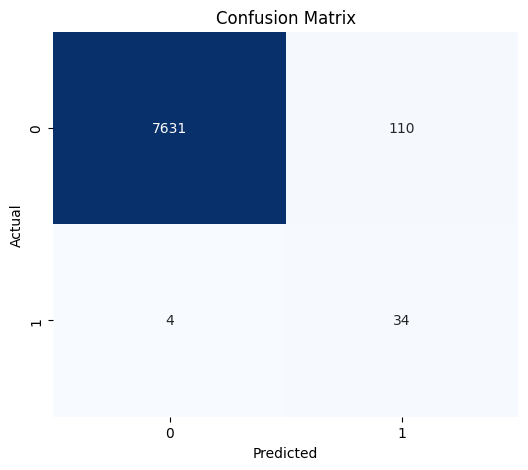

tpr: 0.9473684210526315
threshold: 0.06375260651111603


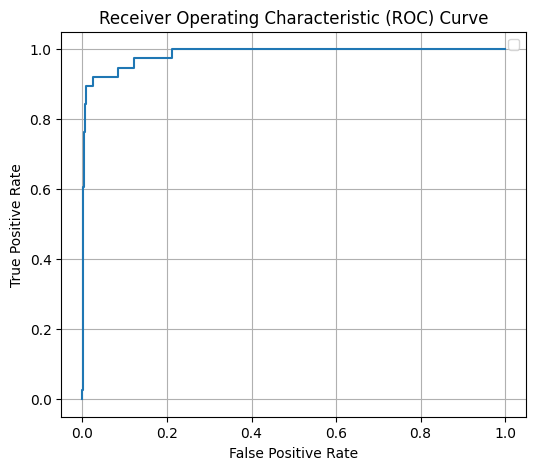

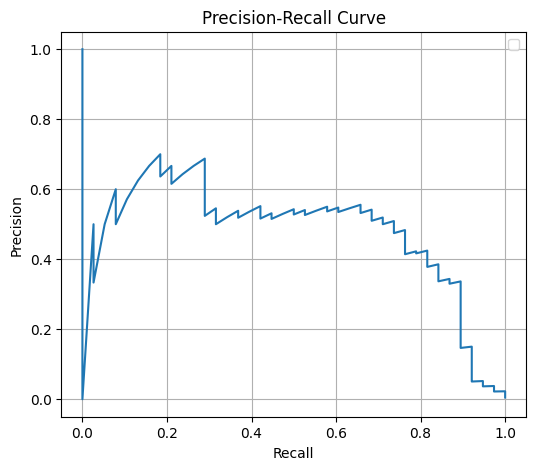

recall: 0.8947368421052632
threshold: 0.4228091537952423


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

import seaborn as sns

fpr, tpr, thresholds = sklearn.metrics.roc_curve(all_ground_truths, all_predicted_outputs)

cm = sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

# Plot 1: Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
#plt.savefig('data/us_results/ilkymo_cm.png')
plt.show()


# Plot 2: ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()

fpr_max = 0.1
print(f'tpr: {tpr[len(fpr[fpr < fpr_max])-1]}')
print(f'threshold: {thresholds[len(fpr[fpr < fpr_max])-1]}')
#plt.savefig('data/us_results/ilkymo_roc.png')


# Plot 3: Precision-Recall Curve
precision, recall, pr_thresholds = sklearn.metrics.precision_recall_curve(all_ground_truths, all_predicted_outputs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
#plt.savefig('data/us_results/ilkymo_pr.png')
plt.show()

precision_max = 0.20
print(f'recall: {recall[len(precision[precision < precision_max])-1]}')
print(f'threshold: {pr_thresholds[len(precision[precision < precision_max])-1]}')

In [ ]:
# Visually inspect
def CreateShapefile(gdf, idx, predictions, filename):
    #filtered_gdf = gdf[idx]
    predictions_gdf = gpd.GeoDataFrame(predictions, geometry = gdf.geometry, columns = ['mine'], crs = '4326')
    print(predictions_gdf)
    file_name = f'data/{filename}.shp'
    predictions_gdf.to_file(file_name)

    return

In [ ]:
# Export to shapefile to inspect results
CreateShapefile(dataNMmarked, nm_train_idx, all_predictions, '/us_results/nm_preds_04')

       mine                                           geometry
0       1.0  POLYGON ((-103.7791 32.56872, -103.79027 32.59...
1       0.0  POLYGON ((-103.80801 32.56872, -103.81918 32.5...
2       0.0  POLYGON ((-103.77455 32.50342, -103.78569 32.5...
3       1.0  POLYGON ((-103.76342 32.48165, -103.77455 32.5...
4       1.0  POLYGON ((-106.88282 35.97995, -106.89596 36.0...
...     ...                                                ...
48004   0.0  POLYGON ((-109.01481 31.3754, -109.02599 31.39...
48005   0.0  POLYGON ((-108.96374 31.33216, -108.9749 31.35...
48006   0.0  POLYGON ((-109.00364 31.35378, -109.01481 31.3...
48007   0.0  POLYGON ((-108.99247 31.33216, -109.00364 31.3...
48008   0.0  POLYGON ((-109.02121 31.33216, -109.03237 31.3...

[48009 rows x 2 columns]


In [126]:
def TangIntersection(datamarked, X_train, y_train,  Tang_poly):
    # Get intersecting test
    tang_index = gpd.sjoin(datamarked, mine_poly, how = 'inner', predicate = 'intersects').drop_duplicates('geometry').index.to_list()
    Tangdata = datamarked.reset_index(drop=True).loc[tang_index]
    # Filter list
    tang_X_test = X_train[tang_index]
    tang_y_test = y_train[tang_index]
    print(len(tang_y_test))
    print(tang_y_test.sum())

    return tang_X_test, tang_y_test, Tangdata

In [287]:
# Get Tang polygons intersection 
# ONLY WORKS WITH HELD OUT REGIONS

#tang_X_test, tang_y_test, TangAZdata = TangIntersection(dataAZmarked, az_X_train, az_y_train, mine_poly)
#tang_X_test, tang_y_test, TangNVdata = TangIntersection(dataNVmarked, nv_X_train, nv_y_train, mine_poly)

#tang_X_test, tang_y_test, TangINdata = TangIntersection(dataINmarked, in_X_train, in_y_train, mine_poly)

#tang_X_test, tang_y_test, TangILKYMOdata = TangIntersection(dataILKYMOmarked, ilkymo_X_train, ilkymo_y_train, mine_poly)

tang_X_test, tang_y_test, TangMNdata = TangIntersection(dataMNmarked, mn_X_train, mn_y_train, mine_poly)

#tang_X_test, tang_y_test, TangTXdata = TangIntersection(dataTXmarked, tx_X_train, tx_y_train, mine_poly)

#tang_X_test, tang_y_test, TangMNFulldata = TangIntersection(dataMNfullmarked, mnfull_X_train, mnfull_y_train, mine_poly)
#tang_X_test, tang_y_test, TangMTWYdata = TangIntersection(dataMTWYmarked, mtwy_X_train, mtwy_y_train, mine_poly)

195
85


In [ ]:
# Get Tang polygons intersection 
# ONLY WORKS WITH HELD OUT REGIONS

tang_X_test, tang_y_test, TangNMdata = TangIntersection(dataNMmarked, nm_X_train, nm_y_train, mine_poly)
#tang_X_test, tang_y_test, TangONTdata = TangIntersection(dataONTmarked, ont_X_train, ont_y_train, mine_poly)


236
39


In [ ]:
TangIntersection(dataAZmarked, az_X_train, az_y_train, mine_poly)
TangIntersection(dataNVmarked, nv_X_train, nv_y_train, mine_poly)
TangIntersection(dataGAmarked, ga_X_train, ga_y_train, mine_poly)
TangIntersection(dataINmarked, in_X_train, in_y_train, mine_poly)
TangIntersection(dataILKYMOmarked, ilkymo_X_train, ilkymo_y_train, mine_poly)
TangIntersection(dataMNmarked, mn_X_train, mn_y_train, mine_poly)
TangIntersection(dataMTWYmarked, mtwy_X_train, mtwy_y_train, mine_poly)
TangIntersection(dataTXmarked, tx_X_train, tx_y_train, mine_poly)


202
61
227
39
212
146
198
82
318
117
195
110
430
86
216
66


(array([[-0.01345485, -0.26811844,  0.29243714, ..., -0.0222764 ,
         -0.00085851,  0.15169452],
        [ 0.07935756, -0.24371013,  0.25638047, ..., -0.03260776,
          0.01025596,  0.14083578],
        [ 0.00294834, -0.26972085,  0.14075567, ..., -0.06709002,
          0.03035083,  0.11829881],
        ...,
        [-0.03306611, -0.29491985,  0.24400125, ..., -0.05967374,
          0.05283879,  0.09783327],
        [-0.06426404, -0.34450692,  0.3635442 , ..., -0.04757246,
          0.03398785,  0.05404086],
        [-0.06846737, -0.31697667,  0.38864446, ..., -0.06309792,
          0.02810209,  0.0890198 ]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

In [289]:
# Tang set evaluation
model.eval()
criterion = nn.BCELoss(reduction='mean') 
test_dataset = MLPDataset(tang_X_test, tang_y_test)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)

        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
all_predicted_outputs = np.array(all_predicted_outputs)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')
accuracy = accuracy_score(all_ground_truths, all_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(all_ground_truths)}')
print(f'True positives: {all_ground_truths.sum()}')
print(f'Predicted positives: {all_predictions.sum()}')

Precision on test set: 0.5333
Recall on test set: 0.6588
Accuracy on test set: 0.6000
F1 score on test set: 0.5895
Total chips: 195
True positives: 85.0
Predicted positives: 105.0


In [ ]:
nv_predicted_outputs = all_predicted_outputs 
nv_ground_truths = all_ground_truths

dataONTpredicted = gpd.GeoDataFrame(dataONTmarked, geometry = dataONTmarked.geometry, crs = '4326')
dataONTpredicted['mine_prob'] = ont_predicted_outputs
dataONTpredicted['ground_truth'] = ont_ground_truths

In [473]:
dataMNpredicted = gpd.GeoDataFrame(dataMNfullmarked, geometry = dataMNfullmarked.geometry, crs = '4326')
dataMNpredicted['mine_prob'] = mn_full_predicted_outputs
dataMNpredicted['ground_truth'] = mn_full_ground_truths

In [308]:
dataONTpredicted = gpd.GeoDataFrame(TangONTdata, geometry = TangONTdata.geometry, crs = '4326')
dataONTpredicted['mine_prob'] = ont_predicted_outputs
dataONTpredicted['ground_truth'] = ont_ground_truths

In [617]:
dataONTpredicted = gpd.GeoDataFrame(dataONTmarked, geometry = dataONTmarked.geometry, crs = '4326')
dataONTpredicted['mine_prob'] = ont_predicted_outputs
dataONTpredicted['ground_truth'] = ont_ground_truths

In [ ]:
dataONTpredicted = dataONTpredicted.drop(columns = ['minx','miny','maxx','maxy','objectid','label','dataset','wkb_geometry', 'field_9','field_11','geometry_wkt'])

KeyError: "['minx', 'miny', 'maxx', 'maxy', 'objectid', 'label', 'dataset', 'wkb_geometry', 'field_9', 'field_11', 'geometry_wkt'] not found in axis"

In [626]:
dataONTpredicted.columns

Index(['embedding', 'geometry', 'centroid_x', 'centroid_y', 'index__1', 'cc',
       'score', 'area', 'volume', 'category', 'mine', 'emb_idx',
       'overlapping_area', 'pct_pitlake', 'mine_prob', 'ground_truth'],
      dtype='object')

In [628]:
dataONTpredicted = dataONTpredicted.drop(columns = ['centroid_x', 'centroid_y', 'embedding'])

In [ ]:
dataONTpredicted.to_parquet('data/dataONTpredicted.parquet')

In [92]:
dataONTpredicted = gpd.read_parquet('data/dataONTpredicted.parquet')

In [157]:
dataONTpredicted_3_updated['ground_truth_left']

15852    0.0
15853    0.0
15854    0.0
15855    0.0
15856    0.0
        ... 
23772    0.0
23773    0.0
23774    0.0
23775    0.0
23776    0.0
Name: ground_truth_left, Length: 7925, dtype: float32

In [155]:
dataONTpredicted_3_updated.loc[dataONTpredicted_3_updated['mine_prob_right'] > 0.5,'ground_truth_right'].sum()

0.0

In [158]:
dataILKYMOpredicted.shape

(14395, 10)

In [166]:
np.linspace(0, 14394, 7)

array([    0.,  2399.,  4798.,  7197.,  9596., 11995., 14394.])

In [168]:
dataILKYMOpredicted_chunk_1 = dataILKYMOpredicted.iloc[0:2399]
dataILKYMOpredicted_chunk_2 = dataILKYMOpredicted.iloc[2399:4798]
dataILKYMOpredicted_chunk_3 = dataILKYMOpredicted.iloc[4798:7197]
dataILKYMOpredicted_chunk_4 = dataILKYMOpredicted.iloc[7197:9596]
dataILKYMOpredicted_chunk_5 = dataILKYMOpredicted.iloc[9596:11995]
dataILKYMOpredicted_chunk_6 = dataILKYMOpredicted.iloc[11995:14394]

dataILKYMOpredicted_chunk_1.to_parquet('data/dataILKYMOpredicted_chunk_1.parquet')
dataILKYMOpredicted_chunk_2.to_parquet('data/dataILKYMOpredicted_chunk_2.parquet')
dataILKYMOpredicted_chunk_3.to_parquet('data/dataILKYMOpredicted_chunk_3.parquet')
dataILKYMOpredicted_chunk_4.to_parquet('data/dataILKYMOpredicted_chunk_4.parquet')
dataILKYMOpredicted_chunk_5.to_parquet('data/dataILKYMOpredicted_chunk_5.parquet')
dataILKYMOpredicted_chunk_6.to_parquet('data/dataILKYMOpredicted_chunk_6.parquet')

In [172]:
dataONTpredicted_2 = gpd.read_parquet('data/dataONTpredicted_chunk_2.parquet')

In [179]:
dataONTpredicted_chunk_1 = dataONTpredicted_2.iloc[0:1980]
dataONTpredicted_chunk_2 = dataONTpredicted_2.iloc[1980:3960]
dataONTpredicted_chunk_3 = dataONTpredicted_2.iloc[3960:5940]
dataONTpredicted_chunk_4 = dataONTpredicted_2.iloc[5940:7921]

dataONTpredicted_chunk_1.to_parquet('data/dataONTpredicted_chunk_21.parquet')
dataONTpredicted_chunk_2.to_parquet('data/dataONTpredicted_chunk_22.parquet')
dataONTpredicted_chunk_3.to_parquet('data/dataONTpredicted_chunk_23.parquet')
dataONTpredicted_chunk_4.to_parquet('data/dataONTpredicted_chunk_24.parquet')

In [165]:
(dataILKYMOpredicted_chunk_1['mine_prob'] > 0.5).sum()

198

In [ ]:
(dataILKYMOpredicted['mine_prob'] > 0.5).sum()

755

In [ ]:
num_chunks = 7

# Split the GeoDataFrame into 7 roughly equal chunks
chunks = np.array_split(dataONTpredicted, num_chunks)

# Export each chunk as a separate Parquet file
for i, chunk in enumerate(chunks):
    print(chunk.head().geometry)
    #chunk.to_parquet(f"data/dataILKYMOpredicted_chunk_{i+1}.parquet")

0    POLYGON ((-79.66113 48.49779, -79.67668 48.522...
1    POLYGON ((-79.69311 48.49779, -79.70866 48.522...
2    POLYGON ((-79.70954 48.47286, -79.72509 48.497...
3    POLYGON ((-79.69402 48.44793, -79.70954 48.472...
4    POLYGON ((-79.89286 48.09971, -79.90823 48.124...
Name: geometry, dtype: geometry
7926    POLYGON ((-83.39601 49.07331, -83.41263 49.098...
7927    POLYGON ((-83.3794 49.04821, -83.39601 49.0733...
7928    POLYGON ((-83.36282 49.02311, -83.3794 49.0482...
7929    POLYGON ((-83.34625 48.99802, -83.36282 49.023...
7930    POLYGON ((-83.32971 48.97294, -83.34625 48.998...
Name: geometry, dtype: geometry
15852    POLYGON ((-86.12982 49.77934, -86.14744 49.804...
15853    POLYGON ((-86.11223 49.75402, -86.12982 49.779...
15854    POLYGON ((-86.14744 49.80467, -86.16507 49.83,...
15855    POLYGON ((-86.0771 49.7034, -86.09466 49.72871...
15856    POLYGON ((-85.92001 49.47601, -85.93738 49.501...
Name: geometry, dtype: geometry
23777    POLYGON ((-87.8102 49.55174, -87.82

In [ ]:
region = 'TX'
tn = cm[0,0]
fp = cm[0,1]
fn = cm[1,0]
tp = cm[1,1]

print(tn, fp, fn, tp)
#state_results = pd.DataFrame({'region': region, 'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp})
#tang_results[tang_results['region' == region]] = state_results
#tang_results

90 64 22 40


ValueError: If using all scalar values, you must pass an index

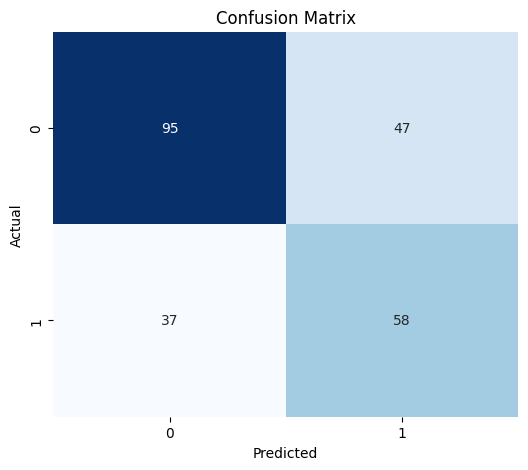

In [301]:

# Plot 1: Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cmont, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
#plt.savefig('data/us_results/nm_cm_tang.png')
plt.show()

In [298]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

import seaborn as sns

fpr, tpr, thresholds = sklearn.metrics.roc_curve(all_ground_truths, all_predicted_outputs)

#cm = sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

# Plot 1: Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(nm_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
#plt.savefig('data/us_results/nm_cm_tang.png')
plt.show()


# Plot 2: ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()

fpr_max = 0.1
print(f'tpr: {tpr[len(fpr[fpr < fpr_max])-1]}')
print(f'threshold: {thresholds[len(fpr[fpr < fpr_max])-1]}')
#plt.savefig('data/us_results/nm_roc_tang.png')


# Plot 3: Precision-Recall Curve
precision, recall, pr_thresholds = sklearn.metrics.precision_recall_curve(all_ground_truths, all_predicted_outputs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
#plt.savefig('data/us_results/nm_pr_tang.png')
plt.show()

precision_max = 0.15
print(f'recall: {recall[len(precision[precision < precision_max])-1]}')
print(f'threshold: {pr_thresholds[len(precision[precision < precision_max])-1]}')

ValueError: Found input variables with inconsistent numbers of samples: [236, 195]

In [49]:
dataNVpredicted = gpd.GeoDataFrame(dataNVmarked, geometry = dataNVmarked.geometry, crs = '4326')
dataNVpredicted['mine_prob'] = nv_predicted_outputs
dataNVpredicted['ground_truth'] = nv_ground_truths

In [253]:
dataAZpredicted = gpd.GeoDataFrame(TangAZdata, geometry = TangAZdata.geometry, crs = '4326')
dataAZpredicted['mine_prob'] = az_predicted_outputs
dataAZpredicted['ground_truth'] = az_ground_truths

dataNVpredicted = gpd.GeoDataFrame(TangNVdata, geometry = TangNVdata.geometry, crs = '4326')
dataNVpredicted['mine_prob'] = nv_predicted_outputs
dataNVpredicted['ground_truth'] = nv_ground_truths

dataGApredicted = gpd.GeoDataFrame(TangGAdata, geometry = TangGAdata.geometry, crs = '4326')
dataGApredicted['mine_prob'] = ga_predicted_outputs
dataGApredicted['ground_truth'] = ga_ground_truths

dataINpredicted = gpd.GeoDataFrame(TangINdata, geometry = TangINdata.geometry, crs = '4326')
dataINpredicted['mine_prob'] = in_predicted_outputs
dataINpredicted['ground_truth'] = in_ground_truths

dataILKYMOpredicted = gpd.GeoDataFrame(TangILKYMOdata, geometry = TangILKYMOdata.geometry, crs = '4326')
dataILKYMOpredicted['mine_prob'] = ilkymo_predicted_outputs
dataILKYMOpredicted['ground_truth'] = ilkymo_ground_truths

dataMNpredicted = gpd.GeoDataFrame(TangMNdata, geometry = TangMNdata.geometry, crs = '4326')
dataMNpredicted['mine_prob'] = mn_predicted_outputs
dataMNpredicted['ground_truth'] = mn_ground_truths

dataMTWYpredicted = gpd.GeoDataFrame(TangMTWYdata, geometry = TangMTWYdata.geometry, crs = '4326')
dataMTWYpredicted['mine_prob'] = mtwy_predicted_outputs
dataMTWYpredicted['ground_truth'] = mtwy_ground_truths

dataTXpredicted = gpd.GeoDataFrame(TangTXdata, geometry = TangTXdata.geometry, crs = '4326')
dataTXpredicted['mine_prob'] = tx_predicted_outputs
dataTXpredicted['ground_truth'] = tx_ground_truths

NameError: name 'TangAZdata' is not defined

In [ ]:
dataNMpredicted = gpd.GeoDataFrame(dataNMmarked, geometry = dataNMmarked.geometry, crs = '4326')
dataNMpredicted['mine_prob'] = nm_predicted_outputs
dataNMpredicted['ground_truth'] = nm_ground_truths

#dataNMpredicted = gpd.GeoDataFrame(TangNMdata, geometry = TangNMdata.geometry, crs = '4326')
#dataNMpredicted['mine_prob'] = nm_predicted_outputs
#dataNMpredicted['ground_truth'] = nm_ground_truths

#dataMTWYpredicted = gpd.GeoDataFrame(TangMTWYdata, geometry = TangMTWYdata.geometry, crs = '4326')
#dataMTWYpredicted['mine_prob'] = mtwy_predicted_outputs
#dataMTWYpredicted['ground_truth'] = mtwy_ground_truths


In [ ]:
agg_heldout = pd.concat([, dataMTWYpredicted, dataTXpredicted])
agg_positives = (agg_heldout['score'] > 0.5).sum()
print((agg_heldout.loc[agg_heldout['score'] > 0.5, 'mine_feature']== 2).sum() / agg_positives) # questionable 
print((agg_heldout.loc[agg_heldout['score'] > 0.5, 'mine_feature']== 1).sum() / agg_positives) #

0.027616279069767442
0.09302325581395349


In [38]:
dataAZpredicted_updated_l = gpd.read_parquet('data/us_results/AZ_predictions.parquet')
dataNVpredicted_updated_l = gpd.read_parquet('data/us_results/NV_predictions.parquet')
dataGApredicted_updated_l = gpd.read_parquet('data/us_results/GA_predictions.parquet')
dataINpredicted_updated_l = gpd.read_parquet('data/us_results/IN_predictions.parquet')
dataILKYMOpredicted_updated_l = gpd.read_parquet('data/us_results/ILKYMO_predictions.parquet')
dataMNpredicted_updated_l = gpd.read_parquet('data/us_results/MN_predictions.parquet')



FileNotFoundError: [WinError 2] Failed to open local file 'data/us_results/NV_predictions.parquet'. Detail: [Windows error 2] The system cannot find the file specified.


In [592]:
dataMTWYpredicted_updated_l = dataMTWYpredicted_updated_l.rename(columns = {'updated_pr': 'updated_preds'})
dataTXpredicted_updated_l = dataTXpredicted_updated_l.rename(columns = {'updated_pr': 'updated_preds'})

agg_heldout = pd.concat([dataAZpredicted_updated_l, dataNVpredicted_updated_l,
                            dataGApredicted_updated_l, dataINpredicted_updated_l,
                            dataILKYMOpredicted_updated_l, dataMNpredicted_updated_l,
                            dataMTWYpredicted_updated_l, dataTXpredicted_updated_l])


<Figure size 600x500 with 0 Axes>

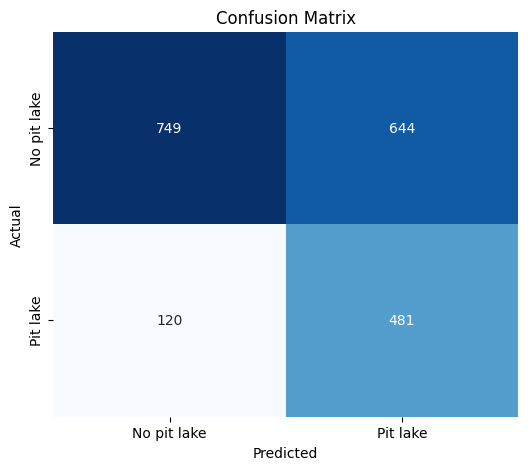

In [286]:
#agg_ground_truths = np.array(agg_heldout['mine'])
#agg_preds = np.array(agg_heldout['updated_preds'])
#total_cm = sklearn.metrics.confusion_matrix(agg_ground_truths, agg_preds)

total_cm = [[749, 644], [120,481]]
	
# Plot 1: Confusion Matrix
plt.figure(figsize=(6, 5))
labels = ['No pit lake', 'Pit lake']  # Change these to whatever fits your case

plt.figure(figsize=(6, 5))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('data/us_results/total_cm_tang.png')
plt.show()

In [420]:
dataMTWYpredicted_updated_l = gpd.read_parquet('data/us_results/MTWY_predictions.parquet')
dataTXpredicted_updated_l = gpd.read_parquet('data/us_results/TX_predictions.parquet')

In [ ]:
agg_heldout_feature = pd.DataFrame()

agg_heldout_feature['AZ'] = dataAZpredicted_updated_l.loc[dataAZpredicted_updated_l['updated_preds'] == 1, 'mine_feature'].value_counts()
agg_heldout_feature['NV'] = dataNVpredicted_updated_l.loc[dataNVpredicted_updated_l['updated_preds'] == 1, 'mine_feature'].value_counts()
agg_heldout_feature['GA'] = dataGApredicted_updated_l.loc[dataGApredicted_updated_l['updated_preds'] == 1, 'mine_feature'].value_counts()
agg_heldout_feature['IN'] = dataINpredicted_updated_l.loc[dataINpredicted_updated_l['updated_preds'] == 1, 'mine_feature'].value_counts()
agg_heldout_feature['IL, KY, MO'] = dataILKYMOpredicted_updated_l.loc[dataILKYMOpredicted_updated_l['updated_preds'] == 1, 'mine_feature'].value_counts()
agg_heldout_feature['MN'] = dataMNpredicted_updated_l.loc[dataMNpredicted_updated_l['updated_preds'] == 1, 'mine_feature'].value_counts()
agg_heldout_feature['MT, WY'] = dataMTWYpredicted_updated_l.loc[dataMTWYpredicted_updated_l['updated_pr'] == 1, 'mine_feature'].value_counts()
agg_heldout_feature['TX'] = dataTXpredicted_updated_l.loc[dataTXpredicted_updated_l['updated_pr'] == 1, 'mine_feature'].value_counts()
agg_heldout_feature.loc['pos'] = [dataAZpredicted_updated_l['updated_preds'].sum(), dataNVpredicted_updated_l['updated_preds'].sum(),
                                    dataGApredicted_updated_l['updated_preds'].sum(), dataINpredicted_updated_l['updated_preds'].sum(),
                                    dataILKYMOpredicted_updated_l['updated_preds'].sum(), dataMNpredicted_updated_l['updated_preds'].sum(),
                                    dataMTWYpredicted_updated_l['updated_pr'].sum(), dataTXpredicted_updated_l['updated_pr'].sum()]

agg_heldout_feature = agg_heldout_feature.fillna(0)
agg_heldout_feature = agg_heldout_feature.T.reset_index().rename(columns={'mine_feature': 'State'})  # Rename index to 'State'

category_labels = {
    3.0: 'Pit lake',
    0.5: 'Other mining feature',
    0.0: 'Unlabeled',
    1.0: 'Dry pit lake',
    2.0: 'Questionable'
}

agg_heldout_feature = agg_heldout_feature.rename(columns=category_labels)
print(agg_heldout_feature)

mine_feature       index  Pit lake  Other mining feature  Unlabeled  \
0                     AZ      34.0                  28.0       23.0   
1                     NV      15.0                  19.0       48.0   
2                     GA     126.0                   9.0       25.0   
3                     IN      63.0                  13.0       64.0   
4             IL, KY, MO      60.0                  13.0       69.0   
5                     MN      71.0                   0.0       61.0   
6                 MT, WY      59.0                  22.0      178.0   
7                     TX      49.0                   7.0       71.0   

mine_feature  Dry pit lake  Questionable    pos  
0                     19.0           1.0  105.0  
1                      9.0           1.0   92.0  
2                      0.0           1.0  161.0  
3                      1.0           0.0  141.0  
4                      6.0           3.0  151.0  
5                      0.0           1.0  133.0  
6         

In [417]:
fp = agg_heldout_feature['Other mining feature'].sum() + agg_heldout_feature['Unlabeled'].sum() +  agg_heldout_feature['Dry pit lake'].sum() + agg_heldout_feature['Questionable'].sum()

aq = (agg_heldout_feature['Dry pit lake'].sum() + agg_heldout_feature['Questionable'].sum()) / fp

(agg_heldout_feature['Other mining feature'].sum()) / fp

0.15677966101694915

In [ ]:
agg_heldout_feature['Other mining feature'] = agg_heldout_feature['Other mining feature'] / (agg_heldout_feature['pos']) *100
agg_heldout_feature['Unlabeled'] = agg_heldout_feature['Unlabeled'] / (agg_heldout_feature['pos']) *100
agg_heldout_feature['Dry pit lake'] = agg_heldout_feature['Dry pit lake'] / (agg_heldout_feature['pos']) *100
agg_heldout_feature['Questionable'] = agg_heldout_feature['Questionable'] / (agg_heldout_feature['pos']) *100
agg_heldout_feature['Pit lake'] = agg_heldout_feature['Pit lake'] / (agg_heldout_feature['pos']) *100

#agg_heldout_feature_norm = agg_heldout_feature.drop(columns = 'Pit lake').set_index("index").div(agg_heldout_feature.set_index("index").sum(axis=1), axis=0)
agg_heldout_feature

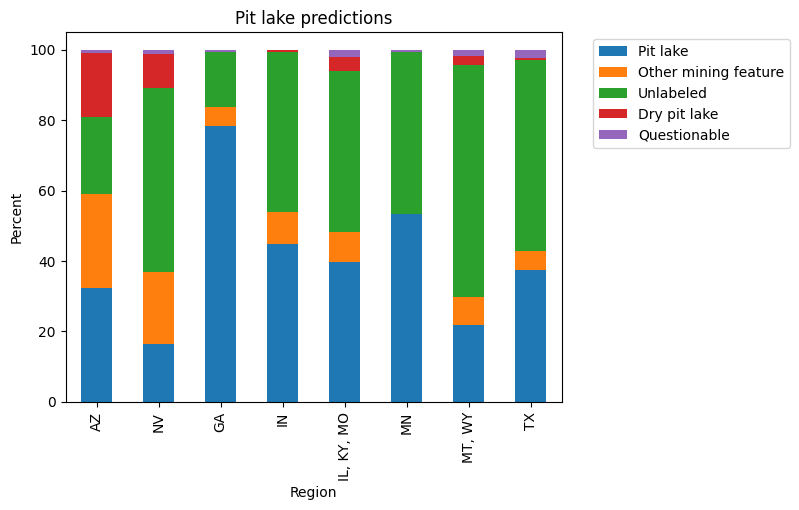

In [411]:
agg_heldout_feature.drop(columns = 'pos').plot( 
    x = 'index', 
    kind = 'bar', 
    stacked = True, 
    title = 'Pit lake predictions', 
    xlabel = 'Region',
    ylabel = 'Percent',
    mark_right = True) 

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
psql_bboxes.to_crs(epsg = '8857').loc[psql_bboxes['category'] == 'a', 'geometry'].area.min()

6131.327256114789

#### Plotting results

,Region,Precision,Recall,F1
Region,,,,
NM Full,NM Full,0.0285,0.4468,0.0535
NM Tang,NM Tang,0.3500,0.5385,0.4242


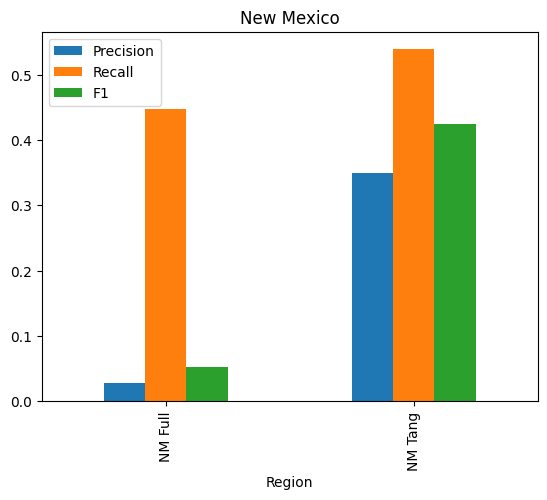

In [ ]:
nm_results = pd.DataFrame({'Region': ['NM Tang', 'NM Full'], 'Precision':[0.35, 0.0285], 'Recall':[ 0.5385, 0.4468], 'F1': [0.4242, 0.0535]})
nm_results = nm_results.sort_values(by = 'Recall')
nm_results.index = nm_results['Region']

nm_results.plot(kind='bar')
plt.title('New Mexico')

nm_results


,Region,Precision,Recall,F1,Accuracy
Region,,,,,
New Mexico Tang,New Mexico Tang,0.397,0.589,0.474,0.784
Ontario Tang,Ontario Tang,0.552,0.611,0.580,0.645


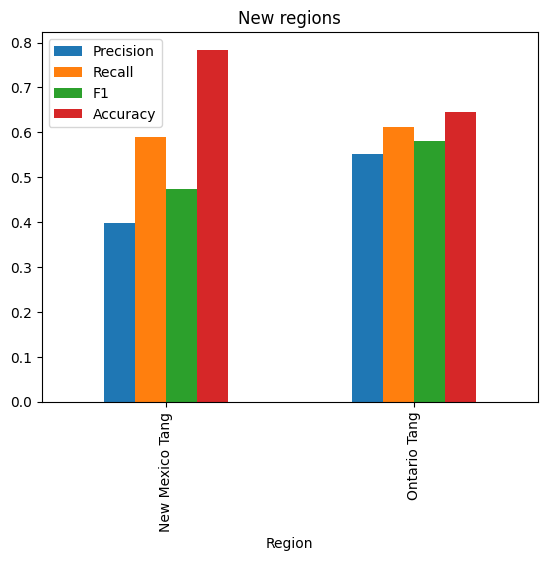

In [302]:
ont_nm_results = pd.DataFrame({'Region': ['New Mexico Tang', 'Ontario Tang'], 'Precision':[0.397, 0.552], 'Recall':[0.589, 0.611], 'F1': [0.474, 0.58], 'Accuracy': [0.784, 0.645]})
ont_nm_results = ont_nm_results.sort_values(by = 'Recall')
ont_nm_results.index = ont_nm_results['Region']

ont_nm_results.plot(kind='bar')
plt.title('New regions')

ont_nm_results


In [304]:
results_table = pd.read_csv('data/AquarryReportingResults_Sheet16.csv')
area_results = results_table
results_table = results_table.sort_values(by = 'Recall')

In [312]:
#results_tang = pd.read_csv('data/us_results/Tang Data 0224.csv')

results_tang = results_table
results_tang = pd.concat([results_tang, pd.DataFrame([{'Region': 'MN Tang - Previous', 'Areas': None, 'Precision': plinio_precision_mn, 'Recall': plinio_recall_mn, 'Accuracy': plinio_accuracy_mn, 'F1': plinio_f1_mn}])])


results_tang = results_tang.sort_values(by = 'Recall')

results_tang


,Region,Areas,Precision,Recall,Accuracy,F1
3,IL KY MO Tang,318,0.457627,0.514286,0.484305,0.638365
7,TX Tang,216,0.416667,0.725806,0.529412,0.629630
4,IN Tang,198,0.517241,0.750000,0.612245,0.616162
2,GA Tang,212,0.815789,0.855172,0.835017,0.768868
0,AZ Tang,202,0.354167,0.894737,0.507463,0.673267
1,NV Tang,227,0.112426,0.950000,0.201058,0.334802
6,MT WY Tang,430,0.354497,0.957143,0.517375,0.709302
5,MN Tang,195,0.453039,0.964706,0.616541,0.476923
0,MN Tang - Previous,None,0.351515,0.983051,0.600962,0.517857


In [307]:
# Get positive predictions with Minnesota Tang
pospredsmn = US_QA.loc[US_QA.intersects(mn)]
pliniopredsmn = gpd.sjoin(pospredsmn, mine_poly, how = 'inner').drop_duplicates('geometry')
pospredsmn = pliniopredsmn[pliniopredsmn['score'] >= 0.5]
len(pospredsmn)

87

In [106]:
dataINpredicted['ground_truth']

0       0.0
1       0.0
2       1.0
3       1.0
4       1.0
       ... 
2090    0.0
2091    0.0
2092    0.0
2093    0.0
2094    0.0
Name: ground_truth, Length: 2095, dtype: float32

In [308]:
# Number of predictions over 0.5
pospredsmn = US_QA.loc[US_QA.intersects(mn)]
print(len(pospredsmn[pospredsmn['score'] >= 0.5]))

# Number of actual
print((pospredsmn.loc[pospredsmn['score'] >= 0.5, 'category'] == 'a').sum())


# Number of predictions over 0.5
pospredsnm = US_QA.loc[US_QA.intersects(nm)]
print(len(pospredsnm[pospredsnm['score'] >= 0.5]))

# Number of actual
print((pospredsnm.loc[pospredsnm['score'] >= 0.5, 'category'] == 'a').sum())


# Number of predictions over 0.5
pospredsont = Canada_QA.loc[Canada_QA.intersects(ont_256.unary_union)]
print(len(pospredsont[pospredsont['score'] >= 0.5]))

# Number of actual
print((pospredsont.loc[pospredsont['score'] >= 0.5, 'category'] == 'a').sum())

108
87
57
16
139
85


In [542]:
# Check for unmarked Ontario
pospredsont.loc[pospredsont['score'] >= 0.5, 'category'].value_counts()

category
a    85
n    28
t    13
q     5
d     3
x     3
c     2
Name: count, dtype: int64

In [610]:
len(agg_heldout[agg_heldout['mine_prob_left'] > 0.85])

502

In [ ]:
# Get average number of pit lakes per chip, if chip is positive
def AveragePitLakesPerChip(data):
    counter = 0
    pit_lakes_per_chip = []

    for index, row in data.iterrows():
        for i in row['category']:
            if i == 'a':
                counter = counter + 1
        pit_lakes_per_chip.append(counter)
        counter = 0

    return pit_lakes_per_chip

pits_per_chip = np.array(AveragePitLakesPerChip(agg_heldout))
pits_per_chip = pits_per_chip[pits_per_chip > 0]
np.average(pits_per_chip)


2.0695364238410594

In [ ]:
# Number of our predictions
print(len(dataMNpredicted_updated[dataMNpredicted_updated['mine_prob_left'] >= 0.5]))
print(len(dataMNpredicted_updated[dataMNpredicted_updated['mine_prob_left'] >= 0.85]))
print(len(dataMNpredicted_updated[dataMNpredicted_updated['mine_prob_left'] >= 0.8]))

print(len(dataNMpredicted[dataNMpredicted['mine_prob'] >= 0.5]))
print(len(dataNMpredicted[dataNMpredicted['mine_prob'] >= 0.85]))
print(len(dataNMpredicted[dataNMpredicted['mine_prob'] >= 0.8]))

print(len(dataONTpredicted[dataONTpredicted['mine_prob'] >= 0.5]))
print(len(dataONTpredicted[dataONTpredicted['mine_prob'] >= 0.85]))
print(len(dataONTpredicted[dataONTpredicted['mine_prob'] >= 0.8]))

2549
712
981
652
141
201
3620
336
600


In [ ]:
print(len(dataMNpredicted_updated))
print(len(dataNMpredicted))
print(len(dataONTpredicted))

34351
48009
55477


In [ ]:
dataTXpredicted = dataTXpredicted.to_crs(epsg=8857) # Have to convert this one since there are slight differences

dataTXpositives_polys = NDWIFilter(dataTXpositives)

dataTXpositives_polys = dissolve_touching_polygons(dataTXpositives_polys)
# Explode back into individual polygons
dataTXpositives_polys['updated_preds'] = dataTXpositives_polys['exploded'].apply(lambda x: 1 if x is not None else 0)

In [309]:
mn_agg_tang = gpd.sjoin(mn_aggregated_nondry_pits, mine_poly, how = 'inner').drop_duplicates('geometry')
mn_agg_tang = mn_agg_tang['geometry'].unary_union

mn_pits_condensed = gpd.GeoDataFrame(geometry = [mn_agg_tang]).explode()
print(len(mn_pits_condensed))

mn_pits_plinio = gpd.sjoin(mn_pits_condensed, pospredsmn, how = 'left', rsuffix = '_1').drop_duplicates('geometry')
mn_pits_plinio['plinio_pred'] = 1
mn_pits_plinio.loc[mn_pits_plinio['index__1'].isna(), 'plinio_pred'] = 0
mn_pits_plinio['plinio_pred'].sum()

59


58

In [310]:
plinio_fp = gpd.sjoin(pospredsmn, mn_pits_condensed, how = 'left', rsuffix = '_1')
plinio_fp['index__1'].isna().sum()

107

In [311]:
negpredsmn = pliniopredsmn[pliniopredsmn['score'] < 0.5]
plinio_tn = gpd.sjoin(negpredsmn, mn_pits_condensed, how = 'left', rsuffix = '_1')

# tp / tp + fp
plinio_precision_mn =  mn_pits_plinio['plinio_pred'].sum()/ (mn_pits_plinio['plinio_pred'].sum() + plinio_fp['index__1'].isna().sum())
# tp / tp + fn
plinio_recall_mn = mn_pits_plinio['plinio_pred'].sum() / (len(mn_pits_condensed))
plinio_accuracy_mn = (mn_pits_plinio['plinio_pred'].sum() + plinio_tn['index__1'].isna().sum()) / len(pliniopredsmn)
plinio_f1_mn = (2 * plinio_precision_mn * plinio_recall_mn) / (plinio_precision_mn + plinio_recall_mn)

print(plinio_precision_mn)
print(plinio_recall_mn)
print(plinio_accuracy_mn)
plinio_f1_mn

0.3515151515151515
0.9830508474576272
0.6009615384615384


0.5178571428571428

Text(0.5, 1.0, 'Within Tang')

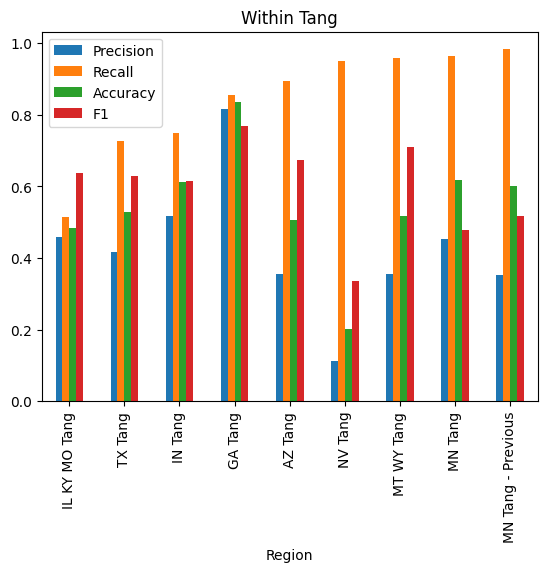

In [313]:
results_tang.index = results_tang['Region']
results_tang.drop(columns = 'Areas').plot(kind='bar')

plt.title('Within Tang')

In [ ]:
regions = ['AZ', 'NV', 'GA', 'IL KY MO', 'IN', 'MN', 'MT WY', 'TX']
tang_regions = ['AZ Tang', 'NV Tang', 'GA Tang', 'IL KY MO Tang', 'IN Tang', 'MN Tang', 'MT WY Tang', 'TX Tang']
region_results = results_table[results_table['Region'].isin(regions)]
region_results.index = region_results['Region']
tang_results = results_table[results_table['Region'].isin(tang_regions)]
tang_results.index = tang_results['Region']
mn_results = results_table[results_table['Region'].isin(['MN Tang', 'MN', 'MN Full'])]
mn_results.loc[mn_results['Region'] == 'MN','Region'] = 'NE MN'
mn_results.index = mn_results['Region']


region_results.plot(kind='bar')
plt.title('Tang and beyond')

results_tang.plot(kind='bar')
plt.title('Within Tang')

mn_results.plot(kind='bar')

plt.title('Minnesota')

plt.show()

NameError: name 'results_table' is not defined

In [ ]:

tang_results['Accuracy'] = [0.703, 0.6079, 0.7311, 0.5723, 0.5758, 0.6513, 0.5233, 0.6389]

In [950]:
tang_areas = [202,227,212,318,198,195,430,216]
areas = [7779, 2533, 1933, 14395, 2095, 9288, 3985, 2661]
totalchips = sum(tang_areas)
area_results = tang_results
area_results['area_pct'] = [x / totalchips for x in tang_areas]

weighted_precision = (area_results['Precision']*area_results['area_pct']).sum()
print(f'precision: {weighted_precision}')
weighted_recall = (area_results['Recall']*area_results['area_pct']).sum()
print(f'recall: {weighted_recall}')
weighted_accuracy = (area_results['Accuracy']*area_results['area_pct']).sum()
print(f'accuracy: {weighted_accuracy}')
weighted_f1 = (area_results['F1']*area_results['area_pct']).sum()
print(f'f1: {weighted_f1}')



precision: 0.44779344344344346
recall: 0.7320997997997999
accuracy: 0.6111197197197198
f1: 0.5386002502502503


In [ ]:
confirmed_plinio = (US_QA.loc[US_QA['score'] > 0.5, 'category'] == 'a').sum()
predicted_plinio = (US_QA['score'] > 0.5).sum()

plinio_precision = confirmed_plinio / predicted_plinio

0.6647932557205941

In [1086]:
tang_area = mine_poly.to_crs(epsg = '8857').area.sum() / (1000*1000) # km2
tang_area

65585.44048982068

(array([38., 33., 18., 32., 24., 34., 32., 26., 29., 42.]),
 array([0.50181729, 0.54882669, 0.59583604, 0.64284545, 0.6898548 ,
        0.73686421, 0.78387362, 0.83088297, 0.87789237, 0.92490172,
        0.97191113]),
 <BarContainer object of 10 artists>)

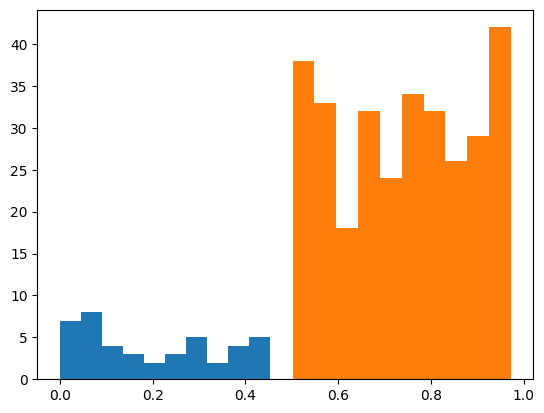

In [63]:
# Inspect false negatives
positives = all_predicted_outputs[all_ground_truths == 1]
plt.hist(positives[positives <= 0.5])

# Inspect false positives
negatives = all_predicted_outputs[all_ground_truths == 0]
plt.hist(negatives[negatives > 0.5])


In [ ]:
# Train set evaluation
model.eval()
criterion = nn.BCELoss(reduction='mean') 
train_eval_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in train_eval_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)
        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
prediction_losses = np.array(prediction_losses)

# Compute metrics


precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')

print(f"Precision on train set: {precision:.4f}")
print(f"Recall on train set: {recall:.4f}")
print(f"F1 score on train set: {f1:.4f}")

Precision on train set: 0.1997
Recall on train set: 0.9305
F1 score on train set: 0.3288


In [126]:
# For training predictions, find negatives that are high loss
negatives_idx = []
high_loss_negs_idx = []
for i in range(len(all_predictions)):
    if all_predictions[i] == 0:
        negatives_idx.append(i)

for i in range(len(negatives_idx)):
    if prediction_losses[negatives_idx[i]] > 1.2:
        high_loss_negs_idx.append(negatives_idx[i])

# Drop high_loss_negs_idx from us_X_train and us_y_train
print(len(us_X_train))
us_X_train = np.delete(us_X_train, high_loss_negs_idx, axis = 0)
print(len(us_X_train))

print(len(us_y_train))
us_y_train = np.delete(us_y_train, high_loss_negs_idx, axis = 0)
print(len(us_y_train))


32741
32653
32741
32653


In [650]:
# For training predictions, find positives that are high loss

# high loss positives are where model is certain it's positive but it's negative, bc it was told this was positive
positives_idx = []
high_loss_pos_idx = []
for i in range(len(all_predictions)):
    if all_predictions[i] == 1:
        positives_idx.append(i)

# Remove top 5% losses
for i in range(len(positives_idx)):
    if prediction_losses[positives_idx[i]] > (np.percentile(prediction_losses, 99)):
        high_loss_pos_idx.append(positives_idx[i])

# Drop high_loss_negs_idx from us_X_train and us_y_train
print(len(us_X_train))
us_X_train = np.delete(us_X_train, high_loss_pos_idx, axis = 0)
print(len(us_X_train))

print(len(us_y_train))
us_y_train = np.delete(us_y_train, high_loss_pos_idx, axis = 0)
print(len(us_y_train))

32726
32401
32726
32401


In [ ]:
# Need to define 
nm_predictions = gpd.GeoDataFrame(nm_preds, geometry = dataNMmarked.geometry, columns = ['preds']).set_crs(dataNMmarked.crs)

nm_mining_districts = gpd.GeoDataFrame(geometry = [nm_im_districts.geometry.unary_union, nm_coal_districts.geometry.unary_union,
    nm_metals_districts.geometry.unary_union,nm_U_districts.geometry.unary_union]).set_crs(nm_im_districts.crs) # Don't include Potash
nm_mining_districts = nm_mining_districts.to_crs(nm_predictions.crs)

nm_predictions_mining = gpd.sjoin(nm_predictions, nm_mining_districts, how = 'left', predicate = 'intersects').drop_duplicates('geometry').reset_index(drop = True)
nm_predictions_mining['within_mining_district'] = 0
nm_predictions_mining.loc[~nm_predictions_mining['index_right'].isna(), 'within_mining_district'] = 1

within_district = (nm_predictions_mining[nm_predictions_mining['preds'] == 1]['within_mining_district'].sum()) / len(nm_predictions_mining[nm_predictions_mining['preds'] == 1])
print(f'Percent of NM predictions within a mining district: {within_district*100}')

Percent of NM predictions within a mining district: 42.54742547425474


### NDWI Filtering

In [205]:
# Optimize GDAL settings for cloud optimized reading
def SearchSTAC(aoi, start, end):
    os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
    os.environ["AWS_REQUEST_PAYER"] = "requester"

    STAC_API = "https://earth-search.aws.element84.com/v1"
    COLLECTION = "sentinel-2-l2a"

    # Search the catalogue
    catalog = pystac_client.Client.open(STAC_API)
    search = catalog.search(
        collections=[COLLECTION],
        datetime=f"{start}/{end}",
        intersects=aoi,
        #max_items=,
        query={"eo:cloud_cover": {"lt": 20}},
    )

    all_items = search.get_all_items()

    # Reduce to one per date (there might be some duplicates
    # based on the location)
    items = []
    dates = []
    for item in all_items:
        if item.datetime.date() not in dates:
            items.append(item)
            dates.append(item.datetime.date())

    print(f"Found {len(items)} items")

    return items, dates

# CHANGE TARGET PROJECTION AS NEEDED
# Retrieve the pixel values for the bounding box in the target projection.
def RetrievePixels(items,aoi_bounds):
    dask.config.set({"array.slicing.split_large_chunks": True})
    stack = None

    if len(items) != 0:
        #epsg = items[0].properties["proj:epsg"]
        gsd = 10
        valid_stacks = []
        bounds_gdf = gpd.GeoDataFrame(geometry=[aoi_bounds], crs='EPSG:8857')
        transformed_bbox = bounds_gdf.geometry[0].bounds

    if len(items) > 8:
        #rand_idx = random.sample(range(0, len(items)), 8)
        #items = [items[id] for id in rand_idx]
        items.sort(key=lambda item: item.properties.get("eo:cloud_cover", 100))
    
        # Select the top 8 items with the least cloud cover
        items = items[:8]
        print(f'Reduced items to {len(items)}')

    for item in items:
        try:
            # Attempt to create the stack for the current item
            stack = stackstac.stack(
                [item],  # Process one item at a time
                snap_bounds=True,
                epsg=8857,
                resolution=gsd,
                dtype="float32",
                rescale=False,
                fill_value=np.float32(0),
                assets=["green", "nir"],
                resampling=Resampling.nearest,
                chunksize=512,
                bounds=transformed_bbox
            )
            valid_stacks.append(stack)
        except RuntimeError as e:
            # Log and skip the problematic item
            print(f'Error creating stack for item {item.id}: {e}')
            continue

        if len(valid_stacks) != 0:
            combined_stack = dask.array.concatenate(valid_stacks, axis=0).compute()
            #stack = stack.compute()
        
    return stack

 # Calculate NDWI and create water mask 
def CalculateNDWI(image):
    ndwi = image
    green = image.sel(band="green")
    nir = image.sel(band="nir")

    ndwi = (green - nir) / (green + nir)
    return ndwi

In [206]:
from rasterio import features
from affine import Affine
from shapely.geometry import shape
import rioxarray
from rasterio import features
from affine import Affine
from shapely.geometry import shape
import rioxarray
from shapely.geometry import MultiPolygon
from scipy.spatial import ConvexHull
from rasterio.features import geometry_mask
from scipy.ndimage import label, binary_dilation


def RasterstoPolygons(raster):
    raster_array = raster.values # convert to numpy array
    mask = raster_array.astype(bool)
    
    # Get affine transform correctly from rioxarray
    raster.rio.write_crs('epsg:8857', inplace=True)
    xmin, xmax = raster.x.min().item(), raster.x.max().item()
    ymin, ymax = raster.y.min().item(), raster.y.max().item()

    # Get resolution (assuming uniform spacing)
    xres = abs(raster.x[1] - raster.x[0]).item()
    yres = abs(raster.y[1] - raster.y[0]).item()

    transform = Affine(xres, 0, xmin, 0, -yres, ymax)  # Notice -yres because Y decreases

    if mask.any():
        shapes = features.shapes(raster_array, mask=mask, transform=transform)
        geometries = [shape(geom) for geom, _ in shapes]
    else:
        geometries = []

    return geometries    

In [207]:
from rasterio import features
from affine import Affine
from shapely.geometry import shape
import rioxarray
from shapely.geometry import MultiPolygon
from scipy.spatial import ConvexHull
from rasterio.features import geometry_mask
from scipy.ndimage import label, binary_dilation
from rasterio import features
from affine import Affine
from shapely.geometry import shape
import rioxarray
from rasterio import features
from affine import Affine
from shapely.geometry import shape
import rioxarray
from shapely.geometry import MultiPolygon
from scipy.spatial import ConvexHull
from rasterio.features import geometry_mask
from scipy.ndimage import label, binary_dilation

def RasterstoPolygons(raster):
    raster_array = raster.values # convert to numpy array
    mask = raster_array.astype(bool)
    
    # Get affine transform correctly from rioxarray
    raster.rio.write_crs('epsg:8857', inplace=True)
    xmin, xmax = raster.x.min().item(), raster.x.max().item()
    ymin, ymax = raster.y.min().item(), raster.y.max().item()

    # Get resolution (assuming uniform spacing)
    xres = abs(raster.x[1] - raster.x[0]).item()
    yres = abs(raster.y[1] - raster.y[0]).item()

    transform = Affine(xres, 0, xmin, 0, -yres, ymax)  # -yres because Y decreases

    # Ensure there are nonzero values
    if not mask.any():
        return []
    
    nonzero_coords = np.column_stack(np.where(mask))

    # Function to transform pixel indices to geographic coordinates
    def pixel_to_geo(row, col, transform):
        x, y = transform * (col, row)  # Convert pixel indices to coordinates
        return x, y

    connectivity = 2
    dilation_iter = 1

    # Apply dilation to fill small gaps
    if dilation_iter > 0:
        mask = binary_dilation(mask, iterations=dilation_iter)

    # Convert nonzero pixels to geospatial coordinates
    geo_coords = np.array([pixel_to_geo(r, c, transform) for r, c in nonzero_coords])

    # Identify connected regions (multiple polygons)
    #labeled_array, num_features = label(mask)    
    labeled_array, num_features = label(mask, structure=np.ones((3, 3)) if connectivity == 2 else np.array([[0,1,0], [1,1,1], [0,1,0]]))

    # Compute convex hulls for each connected component
    polygons = []
    for i in range(1, num_features + 1):
        region_pixels = np.column_stack(np.where(labeled_array == i))  # Pixels in region
        region_geo_coords = np.array([pixel_to_geo(r, c, transform) for r, c in region_pixels])

        if len(region_geo_coords) >= 3:  # ConvexHull needs at least 3 points
            hull = ConvexHull(region_geo_coords)
            hull_polygon = Polygon(region_geo_coords[hull.vertices])  # Create polygon
            polygons.append(hull_polygon)

    return polygons
    
def NDWIFilter(embs_with_polys):
    # Date range
    start = "2024-06-01"    
    end = "2024-08-31"
    filtered_polys = []

    for i in range(len(embs_with_polys)):
        try:
            #Get NDWI
            aoi_epsg4326 = embs_with_polys['geometry'].to_crs(epsg=4326).iloc[i]
            bounds = embs_with_polys['geometry'].iloc[i]   # Should be in epsg:8857

            ndwiimages, ndwidates = SearchSTAC(aoi_epsg4326, start, end) 

            #try: 
            ndwistack = RetrievePixels(ndwiimages, bounds)
            summer_composite = ndwistack.groupby('band').median(dim = 'time')
            ndwi_summer = CalculateNDWI(summer_composite)

                # Compute mask
            ndwi_threshold = 0.05
            water_mask = xr.where(ndwi_summer > ndwi_threshold, 1, 0)

            print(f'Water mask positive pixels: {water_mask.sum().values}')
            #print(f'Filtered raster shape: {water_mask.shape}')

            # Get polygons for the given raster, and store polygons
            filtered_polys.append(RasterstoPolygons(water_mask))
        except AttributeError:
            filtered_polys.append([])
            print(f'Something went wrong on {i}')

        except RuntimeError:
            filtered_polys.append([])
            print(f'Something went wrong on {i}')
    
    embs_with_polys['pit_lake_polygons'] = filtered_polys
    embs_with_polys["pit_lake_geoms"] = embs_with_polys["pit_lake_polygons"].apply(lambda x: MultiPolygon(x) if x else None)
    embs_with_polys["pit_lake_geoms"] = embs_with_polys["pit_lake_geoms"].apply(lambda x: unary_union([x.buffer(0.005)]) if x else None)

    embs_with_polys["exploded"] = embs_with_polys['pit_lake_geoms'].apply(lambda x: x.geoms if type(x) == MultiPolygon else x)
    embs_with_polys = embs_with_polys.explode("exploded", ignore_index=False)

    return embs_with_polys

In [208]:
import geopandas as gpd

def dissolve_touching_polygons(gdf):
    # Buffer by a small amount to ensure touching polygons merge
    buffered_gdf = gpd.GeoDataFrame(gdf.rename(columns = {'geometry':'chip_geom'}), geometry = gdf['exploded'], crs = gdf.crs)
    buffered_gdf['exploded'] = buffered_gdf.buffer(0.1)
    
    # Perform spatial dissolve on touching polygons
    merged_geom = unary_union(buffered_gdf["exploded"])

    if merged_geom.geom_type == "MultiPolygon":
        merged_polygons = list(merged_geom.geoms)  # Extract individual polygons
    else:
        merged_polygons = [merged_geom]  # Single polygon case
    
    # Create an empty list to store results
    new_rows = []
    
    for poly in merged_polygons:
        # Find original polygons that were part of this dissolved one
        touching_polygons = buffered_gdf[buffered_gdf.intersects(poly)]
        
        # Compute average mine_prob
        avg_mine_prob = touching_polygons["mine_prob"].mean()

        max_ground_truth = touching_polygons["ground_truth"].max()
        
        # Store new row
        new_rows.append({"geometry": poly, "mine_prob": avg_mine_prob, "ground_truth": max_ground_truth})

    # Create a new GeoDataFrame
    new_gdf = gpd.GeoDataFrame(new_rows, crs=gdf.crs)
    
    return new_gdf


In [ ]:
# MN Tang
#  Get positive prediction chips
dataMNpredicted = dataMNpredicted.to_crs(epsg = '8857') # Convert back to 8857 for easier chipping
dataMNpositives = dataMNpredicted[dataMNpredicted['mine_prob'] > 0.5]
print(f'Check if any geometries are NA: {dataMNpositives.geometry.isna().sum()}')

# Get NDWI for chip and polygons
dataMNpositives_polys = NDWIFilter(dataMNpositives)

# Explode back into individual polygons
dataMNpositives_polys = dissolve_touching_polygons(dataMNpositives_polys)

# dissolve into just unique chips
# Create updated prediction column
dataMNpositives_polys['updated_preds'] = dataMNpositives_polys['geometry'].apply(lambda x: 1 if x is not None else 0)

dataMNpositives_polys.to_parquet('data/us_results/MNTang_predictions_polys.parquet')
 

Check if any geometries are NA: 0
Found 4 items
Water mask positive pixels: 7052
Found 4 items
Water mask positive pixels: 5846
Found 4 items
Water mask positive pixels: 3707
Found 4 items
Water mask positive pixels: 1327
Found 4 items
Water mask positive pixels: 3329
Found 4 items
Water mask positive pixels: 11265
Found 4 items
Water mask positive pixels: 2179
Found 4 items
Water mask positive pixels: 3199
Found 4 items
Water mask positive pixels: 1194
Found 4 items
Water mask positive pixels: 4442
Found 4 items
Water mask positive pixels: 7011
Found 4 items
Water mask positive pixels: 5860
Found 4 items
Water mask positive pixels: 3107
Found 4 items
Water mask positive pixels: 2802
Found 4 items
Water mask positive pixels: 7047
Found 4 items
Water mask positive pixels: 6480
Found 4 items
Water mask positive pixels: 8774
Found 4 items
Water mask positive pixels: 3592
Found 4 items
Water mask positive pixels: 6529
Found 4 items
Water mask positive pixels: 8551
Found 4 items
Water mask 

' \n# Merge back in\ndataMNpredicted_updated = gpd.sjoin(dataMNpredicted, dataMNpositives_polys, how = \'left\', predicate = \'intersects\').drop_duplicates(\'geometry\')\ndataMNpredicted_updated.loc[dataMNpredicted_updated[\'updated_preds\'].isna(), \'updated_preds\'] = 0 \n\ndataMNpositives_polys.to_parquet(\'data/us_results/MNTang_predictions_polys.parquet\')\ndataMNpredicted_updated.to_parquet(\'data/us_results/MNTang_predictions.parquet\')\n\n# Assign old values \nmn_updated_predictions = np.array(dataMNpredicted_updated[\'updated_preds\'])\n\nprecision = precision_score(mn_ground_truths, mn_updated_predictions, average=\'binary\')\nrecall = recall_score(mn_ground_truths, mn_updated_predictions, average=\'binary\')\nf1 = f1_score(mn_ground_truths, mn_updated_predictions, average=\'binary\')\naccuracy = accuracy_score(mn_ground_truths, mn_updated_predictions)\n\nprint(f"Precision on test set: {precision:.4f}")\nprint(f"Recall on test set: {recall:.4f}")\nprint(f\'Accuracy on test s

In [272]:

# Merge back in
dataMNpredicted_updated = gpd.sjoin(dataMNpredicted, dataMNpositives_polys, how = 'left', predicate = 'intersects').drop_duplicates('geometry')
dataMNpredicted_updated.loc[dataMNpredicted_updated['updated_preds'].isna(), 'updated_preds'] = 0 

#dataMNpositives_polys.to_parquet('data/us_results/MNTang_predictions_polys.parquet')
dataMNpredicted_updated.to_parquet('data/us_results/MNTang_predictions.parquet')

# Assign old values 
mn_updated_predictions = np.array(dataMNpredicted_updated['updated_preds'])
mn_ground_truths_test = np.array(dataMNpredicted_updated['ground_truth_left'])

precision = precision_score(mn_ground_truths_test, mn_updated_predictions, average='binary')
recall = recall_score(mn_ground_truths_test, mn_updated_predictions, average='binary')
f1 = f1_score(mn_ground_truths_test, mn_updated_predictions, average='binary')
accuracy = accuracy_score(mn_ground_truths_test, mn_updated_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(mn_ground_truths)}')
print(f'True positives: {mn_ground_truths.sum()}')
print(f'Predicted positives: {mn_updated_predictions.sum()}')


Precision on test set: 0.4511
Recall on test set: 0.9765
Accuracy on test set: 0.4718
F1 score on test set: 0.6171
Total chips: 195
True positives: 85.0
Predicted positives: 184.0


In [ ]:
# NV Tang
#  Get positive prediction chips
dataNVpredicted = dataNVpredicted.to_crs(epsg = '8857') # Convert back to 8857 for easier chipping
dataNVpositives = dataNVpredicted[dataNVpredicted['mine_prob'] > 0.5]
print(f'Check if any geometries are NA: {dataNVpositives.geometry.isna().sum()}')

# Get NDWI for chip and polygons
dataNVpositives_polys = NDWIFilter(dataNVpositives)

# Explode back into individual polygons
dataNVpositives_polys = dissolve_touching_polygons(dataNVpositives_polys)

# dissolve into just unique chips
# Create updated prediction column
dataNVpositives_polys['updated_preds'] = dataNVpositives_polys['geometry'].apply(lambda x: 1 if x is not None else 0)

dataNVpositives_polys.to_parquet('data/us_results/NVTang_predictions_polys.parquet')


Check if any geometries are NA: 0
Found 30 items
Reduced items to 8
Water mask positive pixels: 6432
Found 30 items
Reduced items to 8
Water mask positive pixels: 0
Found 26 items
Reduced items to 8
Water mask positive pixels: 2006
Found 26 items
Reduced items to 8
Water mask positive pixels: 13
Found 26 items
Reduced items to 8
Water mask positive pixels: 157
Found 26 items
Reduced items to 8
Water mask positive pixels: 0
Found 26 items
Reduced items to 8
Water mask positive pixels: 6939
Found 26 items
Reduced items to 8
Water mask positive pixels: 2851
Found 26 items
Reduced items to 8
Water mask positive pixels: 76
Found 31 items
Reduced items to 8
Water mask positive pixels: 488
Found 29 items
Reduced items to 8
Water mask positive pixels: 1
Found 30 items
Reduced items to 8
Water mask positive pixels: 0
Found 29 items
Reduced items to 8
Water mask positive pixels: 302
Found 23 items
Reduced items to 8
Water mask positive pixels: 83
Found 29 items
Reduced items to 8
Water mask posi

' \n# Merge back in\ndataNVpredicted_updated = gpd.sjoin(dataNVpredicted, dataNVpositives_polys, how = \'left\', predicate = \'intersects\').drop_duplicates(\'geometry\')\ndataNVpredicted_updated.loc[dataNVpredicted_updated[\'updated_preds\'].isna(), \'updated_preds\'] = 0 \n\ndataNVpositives_polys.to_parquet(\'data/us_results/NVTang_predictions_polys.parquet\')\ndataNVpredicted_updated.to_parquet(\'data/us_results/NVTang_predictions.parquet\')\n\n# Assign old values \nnv_updated_predictions = np.array(dataNVpredicted_updated[\'updated_preds\'])\n\nprecision = precision_score(nv_ground_truths, nv_updated_predictions, average=\'binary\')\nrecall = recall_score(nv_ground_truths, nv_updated_predictions, average=\'binary\')\nf1 = f1_score(nv_ground_truths, nv_updated_predictions, average=\'binary\')\naccuracy = accuracy_score(nv_ground_truths, nv_updated_predictions)\n\nprint(f"Precision on test set: {precision:.4f}")\nprint(f"Recall on test set: {recall:.4f}")\nprint(f\'Accuracy on test s

In [229]:

# Merge back in
dataNVpredicted_updated = gpd.sjoin(dataNVpredicted, dataNVpositives_polys, how = 'left', predicate = 'intersects').drop_duplicates('geometry')
dataNVpredicted_updated.loc[dataNVpredicted_updated['updated_preds'].isna(), 'updated_preds'] = 0 

dataNVpositives_polys.to_parquet('data/us_results/NVTang_predictions_polys.parquet')
dataNVpredicted_updated.to_parquet('data/us_results/NVTang_predictions.parquet')

# Assign old values 
nv_updated_predictions = np.array(dataNVpredicted_updated['updated_preds'])

precision = precision_score(nv_ground_truths, nv_updated_predictions, average='binary')
recall = recall_score(nv_ground_truths, nv_updated_predictions, average='binary')
f1 = f1_score(nv_ground_truths, nv_updated_predictions, average='binary')
accuracy = accuracy_score(nv_ground_truths, nv_updated_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(nv_ground_truths)}')
print(f'True positives: {nv_ground_truths.sum()}')
print(f'Predicted positives: {nv_updated_predictions.sum()}')


Precision on test set: 0.1798
Recall on test set: 0.8000
Accuracy on test set: 0.6608
F1 score on test set: 0.2936
Total chips: 227
True positives: 20.0
Predicted positives: 89.0


In [ ]:
# NV Tang
#  Get positive prediction chips
dataMTWYpredicted = dataMTWYpredicted.to_crs(epsg = '8857') # Convert back to 8857 for easier chipping
dataMTWYpositives = dataMTWYpredicted[dataMTWYpredicted['mine_prob'] > 0.5]
print(f'Check if any geometries are NA: {dataMTWYpositives.geometry.isna().sum()}')

# Get NDWI for chip and polygons
dataMTWYpositives_polys = NDWIFilter(dataMTWYpositives)

# Explode back into individual polygons
dataMTWYpositives_polys = dissolve_touching_polygons(dataMTWYpositives_polys)

# dissolve into just unique chips
# Create updated prediction column
dataMTWYpositives_polys['updated_preds'] = dataMTWYpositives_polys['geometry'].apply(lambda x: 1 if x is not None else 0)

dataMTWYpositives_polys.to_parquet('data/us_results/MTWYTang_predictions_polys.parquet')


Check if any geometries are NA: 0
Found 10 items
Reduced items to 8
Water mask positive pixels: 689
Found 10 items
Reduced items to 8
Water mask positive pixels: 3738
Found 12 items
Reduced items to 8
Water mask positive pixels: 403
Found 12 items
Reduced items to 8
Water mask positive pixels: 654
Found 12 items
Reduced items to 8
Water mask positive pixels: 10395
Found 12 items
Reduced items to 8
Water mask positive pixels: 633
Found 12 items
Reduced items to 8
Water mask positive pixels: 828
Found 24 items
Reduced items to 8
Water mask positive pixels: 21
Found 24 items
Reduced items to 8
Water mask positive pixels: 1114
Found 21 items
Reduced items to 8
Water mask positive pixels: 204
Found 10 items
Reduced items to 8
Water mask positive pixels: 561
Found 10 items
Reduced items to 8
Water mask positive pixels: 1152
Found 10 items
Reduced items to 8
Water mask positive pixels: 249
Found 10 items
Reduced items to 8
Water mask positive pixels: 2833
Found 10 items
Reduced items to 8
Wat

' \n# Merge back in\ndataNVpredicted_updated = gpd.sjoin(dataNVpredicted, dataNVpositives_polys, how = \'left\', predicate = \'intersects\').drop_duplicates(\'geometry\')\ndataNVpredicted_updated.loc[dataNVpredicted_updated[\'updated_preds\'].isna(), \'updated_preds\'] = 0 \n\ndataNVpositives_polys.to_parquet(\'data/us_results/NVTang_predictions_polys.parquet\')\ndataNVpredicted_updated.to_parquet(\'data/us_results/NVTang_predictions.parquet\')\n\n# Assign old values \nnv_updated_predictions = np.array(dataNVpredicted_updated[\'updated_preds\'])\n\nprecision = precision_score(nv_ground_truths, nv_updated_predictions, average=\'binary\')\nrecall = recall_score(nv_ground_truths, nv_updated_predictions, average=\'binary\')\nf1 = f1_score(nv_ground_truths, nv_updated_predictions, average=\'binary\')\naccuracy = accuracy_score(nv_ground_truths, nv_updated_predictions)\n\nprint(f"Precision on test set: {precision:.4f}")\nprint(f"Recall on test set: {recall:.4f}")\nprint(f\'Accuracy on test s

In [230]:

# Merge back in
dataMTWYpredicted_updated = gpd.sjoin(dataMTWYpredicted, dataMTWYpositives_polys, how = 'left', predicate = 'intersects').drop_duplicates('geometry')
dataMTWYpredicted_updated.loc[dataMTWYpredicted_updated['updated_preds'].isna(), 'updated_preds'] = 0 

#dataNVpositives_polys.to_parquet('data/us_results/NVTang_predictions_polys.parquet')
dataMTWYpredicted_updated.to_parquet('data/us_results/MTWYTang_predictions.parquet')

# Assign old values 
mtwy_updated_predictions = np.array(dataMTWYpredicted_updated['updated_preds'])

precision = precision_score(mtwy_ground_truths, mtwy_updated_predictions, average='binary')
recall = recall_score(mtwy_ground_truths, mtwy_updated_predictions, average='binary')
f1 = f1_score(mtwy_ground_truths, mtwy_updated_predictions, average='binary')
accuracy = accuracy_score(mtwy_ground_truths, mtwy_updated_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(mtwy_ground_truths)}')
print(f'True positives: {mtwy_ground_truths.sum()}')
print(f'Predicted positives: {mtwy_updated_predictions.sum()}')
 

Precision on test set: 0.2179
Recall on test set: 0.8000
Accuracy on test set: 0.5000
F1 score on test set: 0.3425
Total chips: 430
True positives: 70.0
Predicted positives: 257.0


In [ ]:
# AZ
#  Get positive prediction chips
dataAZpredicted = dataAZpredicted.to_crs(epsg = '8857') # Convert back to 8857 for easier chipping
dataAZpositives = dataAZpredicted[dataAZpredicted['mine_prob'] > 0.5]
print(f'Check if any geometries are NA: {dataAZpositives.geometry.isna().sum()}')

# Get NDWI for chip and polygons
dataAZpositives_polys = NDWIFilter(dataAZpositives)

# Explode back into individual polygons
dataAZpositives_polys = dissolve_touching_polygons(dataAZpositives_polys)

# dissolve into just unique chips
# Create updated prediction column
dataAZpositives_polys['updated_preds'] = dataAZpositives_polys['geometry'].apply(lambda x: 1 if x is not None else 0)

# Merge back in
dataAZpredicted_updated = gpd.sjoin(dataAZpredicted, dataAZpositives_polys, how = 'left', predicate = 'intersects').drop_duplicates('geometry')
dataAZpredicted_updated.loc[dataAZpredicted_updated['updated_preds'].isna(), 'updated_preds'] = 0 

# Assign old values 
az_updated_predictions = np.array(dataAZpredicted_updated['updated_preds'])

precision = precision_score(az_ground_truths, az_updated_predictions, average='binary')
recall = recall_score(az_ground_truths, az_updated_predictions, average='binary')
f1 = f1_score(az_ground_truths, az_updated_predictions, average='binary')
accuracy = accuracy_score(az_ground_truths, az_updated_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(az_ground_truths)}')
print(f'True positives: {az_ground_truths.sum()}')
print(f'Predicted positives: {az_updated_predictions.sum()}')

dataAZpositives_polys.to_parquet('data/us_results/AZ_predictions_polys.parquet')
dataAZpredicted_updated.to_parquet('data/us_results/AZ_predictions.parquet')

In [611]:
# NM
#  Get positive prediction chips
dataNMpredicted = dataNMpredicted.to_crs(epsg = '8857') # Convert back to 8857 for easier chipping
dataNMpositives = dataNMpredicted[dataNMpredicted['mine_prob'] > 0.5]
print(f'Check if any geometries are NA: {dataNMpositives.geometry.isna().sum()}')

# Get NDWI for chip and polygons
dataNMpositives_polys = NDWIFilter(dataNMpositives)

# Explode back into individual polygons
dataNMpositives_polys = dissolve_touching_polygons(dataNMpositives_polys)

dataNMpositives_polys['updated_preds'] = dataNMpositives_polys['geometry'].apply(lambda x: 1 if x is not None else 0)

# Merge back in
dataNMpredicted_updated = gpd.sjoin(dataNMpredicted, dataNMpositives_polys, how = 'left', predicate = 'intersects').drop_duplicates(subset = 'geometry')
dataNMpredicted_updated.loc[dataNMpredicted_updated['updated_preds'].isna(), 'updated_preds'] = 0 

# Assign old values 
nm_updated_predictions = np.array(dataNMpredicted_updated['updated_preds'])

precision = precision_score(nm_ground_truths, nm_updated_predictions, average='binary')
recall = recall_score(nm_ground_truths, nm_updated_predictions, average='binary')
f1 = f1_score(nm_ground_truths, nm_updated_predictions, average='binary')
accuracy = accuracy_score(nm_ground_truths, nm_updated_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(nm_ground_truths)}')
print(f'True positives: {nm_ground_truths.sum()}')
print(f'Predicted positives: {nm_updated_predictions.sum()}')


Check if any geometries are NA: 0
Found 20 items
Reduced items to 8
Water mask positive pixels: 138
Found 20 items
Reduced items to 8
Water mask positive pixels: 19
Found 20 items
Reduced items to 8
Water mask positive pixels: 25
Found 20 items
Reduced items to 8
Water mask positive pixels: 1022
Found 13 items
Reduced items to 8
Water mask positive pixels: 616
Found 15 items
Reduced items to 8
Water mask positive pixels: 183
Found 15 items
Reduced items to 8
Water mask positive pixels: 2767
Found 14 items
Reduced items to 8
Water mask positive pixels: 256
Found 14 items
Reduced items to 8
Water mask positive pixels: 0
Found 10 items
Reduced items to 8
Water mask positive pixels: 337
Found 12 items
Reduced items to 8
Water mask positive pixels: 131
Found 11 items
Reduced items to 8
Water mask positive pixels: 9
Found 11 items
Reduced items to 8
Water mask positive pixels: 318
Found 25 items
Reduced items to 8
Water mask positive pixels: 3557
Found 25 items
Reduced items to 8
Water mask 

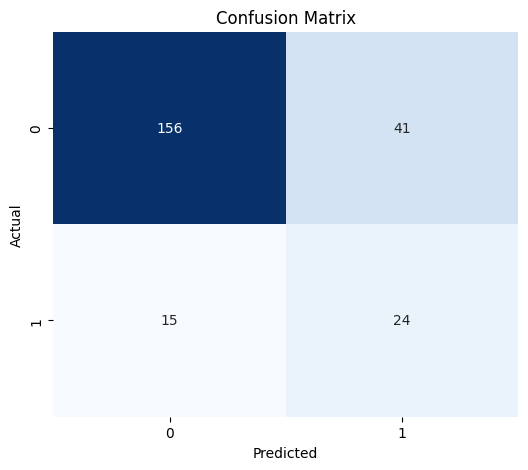

In [ ]:
dataNMexport = gpd.GeoDataFrame(dataNMpositives_polys, geometry = 'geometry', crs = '8857')
dataNMexport.to_parquet('data/us_results/NM_predictions_polys.parquet')
dataNMpredicted_updated.to_parquet('data/us_results/NM_predictions.parquet')


cm = sklearn.metrics.confusion_matrix(nm_ground_truths, nm_updated_predictions)
# Plot 1: Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('data/us_results/nm_cm.png')
plt.show()

In [ ]:
# dissolve into just unique chips
# Create updated prediction column
dataNVpredicted = dataNVpredicted.to_crs(epsg='8857') # Have to convert this one since there are slight differences
dataNVpositives = dataNVpredicted[dataNVpredicted['mine_prob'] > 0.5]
print(f'Check if any geometries are NA: {dataNVpositives.geometry.isna().sum()}')

# Get NDWI for chip and polygons
dataNVpositives_polys = NDWIFilter(dataNVpositives)

# Explode back into individual polygons
dataNVpositives_polys = dissolve_touching_polygons(dataNVpositives_polys)

# dissolve into just unique chips
# Create updated prediction column
dataNVpositives_polys['updated_preds'] = dataNVpositives_polys['geometry'].apply(lambda x: 1 if x is not None else 0)

# Merge back in
dataNVpredicted_updated = gpd.sjoin(dataNVpredicted, dataNVpositives_polys, how = 'left', predicate = 'intersects').drop_duplicates('geometry')
dataNVpredicted_updated.loc[dataNVpredicted_updated['updated_preds'].isna(), 'updated_preds'] = 0 

# Assign old values 
nv_updated_predictions = np.array(dataNVpredicted_updated['updated_preds'])

precision = precision_score(nv_ground_truths, nv_updated_predictions, average='binary')
recall = recall_score(nv_ground_truths, nv_updated_predictions, average='binary')
f1 = f1_score(nv_ground_truths, nv_updated_predictions, average='binary')
accuracy = accuracy_score(nv_ground_truths, nv_updated_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(nv_ground_truths)}')
print(f'True positives: {nv_ground_truths.sum()}')
print(f'Predicted positives: {nv_updated_predictions.sum()}')

dataNVpositives_polys.to_parquet('data/us_results/NV_predictions_polys.parquet')
dataNVpredicted_updated.to_parquet('data/us_results/NV_predictions.parquet')

In [ ]:
import pathlib

# Path to the folder containing Parquet files
folder_path = pathlib.Path("C:/Users/laura/Projects/minemap/aquarry/model/data/aws_results")

# Get all Parquet files in the folder
parquet_files = list(folder_path.glob("*.parquet"))
print(len(parquet_files))

# Read and concatenate all Parquet files into a single GeoDataFrame
gdfs = [gpd.read_parquet(f) for f in parquet_files]
all_predictions_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
all_predictions_gdf.columns

23


Index(['geometry', 'mine_prob', 'ground_truth', 'updated_preds'], dtype='object')

In [262]:
all_predictions_gdf = all_predictions_gdf[['geometry', 'mine_prob', 'ground_truth', 'updated_preds', 'ground_truth_left', 'mine_prob_left']]
all_predictions_gdf

,geometry,mine_prob,ground_truth,updated_preds,ground_truth_left,mine_prob_left
0,"POLYGON ((-9884869.946 4047340.09, -9884869.93...",0.912372,1.0,1.0,NaN,NaN
1,"POLYGON ((-9885440.025 4047750.102, -9885440.0...",0.912372,1.0,1.0,NaN,NaN
2,"POLYGON ((-9885280.062 4047970.085, -9885280.0...",0.912372,1.0,1.0,NaN,NaN
3,"POLYGON ((-9885140.077 4047980.071, -9885140.0...",0.922004,1.0,1.0,NaN,NaN
4,"POLYGON ((-9885080.045 4048110.095, -9885080.0...",0.931635,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...
34201,"POLYGON ((-7977062.924 5323601.792, -7977062.9...",NaN,NaN,1.0,0.0,0.967989
34211,"POLYGON ((-7979622.924 5346641.792, -7979622.9...",NaN,NaN,1.0,0.0,0.513351
34238,"POLYGON ((-7982182.924 5356881.792, -7982182.9...",NaN,NaN,1.0,0.0,0.639270
34282,"POLYGON ((-7987302.924 5341521.792, -7987302.9...",NaN,NaN,1.0,0.0,0.502026


In [443]:
all_predictions_gdf = all_predictions_gdf.rename(columns = {'mine_prob': 'pit_lake_prob', 'updated_preds': 'pit_lake_pred', 'ground_truth': 'previous_pred'})
all_predictions_gdf

,geometry,pit_lake_prob,previous_pred,pit_lake_pred
0,"POLYGON ((-9884869.946 4047340.09, -9884869.93...",0.912372,1.0,1
1,"POLYGON ((-9885440.025 4047750.102, -9885440.0...",0.912372,1.0,1
2,"POLYGON ((-9885280.062 4047970.085, -9885280.0...",0.912372,1.0,1
3,"POLYGON ((-9885140.077 4047980.071, -9885140.0...",0.922004,1.0,1
4,"POLYGON ((-9885080.045 4048110.095, -9885080.0...",0.931635,1.0,1
...,...,...,...,...
69717,"POLYGON ((-8363499.995 4059360.105, -8363499.9...",0.960017,1.0,1
69718,"POLYGON ((-8362479.895 4059639.995, -8362479.8...",0.960017,1.0,1
69719,"POLYGON ((-8363800 4059720.105, -8363790 40597...",0.960017,1.0,1
69720,"POLYGON ((-8362439.922 4059710.07, -8362439.91...",0.960017,1.0,1


In [263]:
all_predictions_gdf.loc[all_predictions_gdf['ground_truth'].isna(), 'ground_truth'] = all_predictions_gdf.loc[all_predictions_gdf['ground_truth'].isna(), 'ground_truth_left']
all_predictions_gdf.loc[all_predictions_gdf['mine_prob'].isna(), 'mine_prob'] = all_predictions_gdf.loc[all_predictions_gdf['mine_prob'].isna(), 'mine_prob_left']

In [264]:
all_predictions_gdf['ground_truth'].sum()
all_predictions_gdf['ground_truth'] = all_predictions_gdf['ground_truth'].astype(int)
all_predictions_gdf = all_predictions_gdf.rename(columns = {'mine_prob': 'pit_lake_prob', 'updated_preds': 'pit_lake_pred', 'ground_truth': 'previous_pred'})
all_predictions_gdf['area'] = all_predictions_gdf.geometry.area


In [257]:
mn_pred = gpd.read_parquet('data/MNfull_predictions.parquet')
mn_pred = mn_pred[mn_pred['mine_prob_left'] >= 0.5]

In [261]:
all_predictions_gdf = pd.concat([all_predictions_gdf, mn_pred])

In [265]:
all_predictions_gdf['pit_lake_pred'].value_counts()
all_predictions_gdf['pit_lake_pred'] = 1

In [266]:
all_predictions_gdf = all_predictions_gdf.sort_values(by = 'pit_lake_prob', ascending = False)
all_predictions_gdf = all_predictions_gdf.reset_index(drop = True)

In [268]:
all_predictions_gdf = all_predictions_gdf.drop(columns = ['ground_truth_left', 'mine_prob_left'])

In [269]:
all_predictions_gdf

,geometry,pit_lake_prob,previous_pred,pit_lake_pred,area
0,"POLYGON ((-7389240.035 4083940.099, -7389240.0...",0.998234,1,1,3926.617010
1,"POLYGON ((-7388470.062 4083420.084, -7388470.0...",0.998234,1,1,13144.917534
2,"POLYGON ((-7387920.016 4084930.104, -7387920.0...",0.998234,1,1,19920.433076
3,"POLYGON ((-7387550.104 4084680.017, -7387550.1...",0.998234,1,1,6588.846413
4,"POLYGON ((-7387970.07 4084050.078, -7387970.06...",0.998234,1,1,11556.016142
...,...,...,...,...,...
57060,"POLYGON ((-6721769.929 5825330.078, -6721769.9...",0.500042,0,1,129831.540161
57061,"POLYGON ((-6722970.005 5825330.105, -6722970 5...",0.500042,0,1,408.074285
57062,"POLYGON ((-6722870.005 5824370.105, -6722869.9...",0.500042,0,1,205.974284
57063,"POLYGON ((-6720689.905 5823730.045, -6720689.9...",0.500042,0,1,1012.770028


<Axes: >

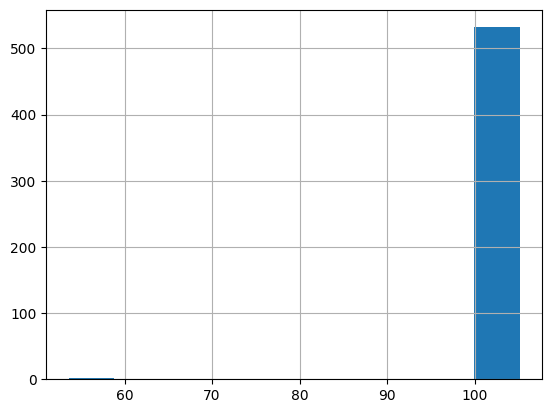

In [ ]:
(all_predictions_gdf.loc[all_predictions_gdf['area'] < 120,'area']).hist()

In [270]:
print(len(all_predictions_gdf))
all_predictions_gdf = all_predictions_gdf[all_predictions_gdf['area'] > 106]
print(len(all_predictions_gdf))


57065
56515


In [273]:
all_predictions_gdf.to_parquet('data/NorthAmericanSamplePitLakes.parquet')